LinkedIn - Find clusters of the accounts

[A] Installing and importing libraries, applying Global settings
---

In [1]:
# Installing libraries not present in colab environment
%pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.0 MB/s eta 0:00:00


In [2]:
# Import Libraries

import os
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from enum import Enum
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import Birch, KMeans, DBSCAN, AffinityPropagation, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram
from google.colab import drive

In [3]:
# Changing the default setting of pandas library to display all the rows and
# columns

pd.options.display.max_columns = None
pd.options.display.max_rows = None

[B] Ethical Considerations
---

The input data only contains the node ids and connections between them. The dataset doesn't contain any personal information. So from maintaining privacy point of view, we don't need to redact or delete any information in the dataset.

[C] Data Collection and reading
---

In [7]:
# Mount the googledrive to retrieve the file.
# Make sure it is stored at following location with name: /content/drive/MyDrive/linkedin.txt
drive.mount('/content/drive')

# Load the linkedin dataset into the graph. It is an undirected graph
igraph_li = ig.Graph.Read_Edgelist('/content/drive/MyDrive/linkedin.txt', directed=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Assign node_id as vertex attribute "node_id"
igraph_li.vs["node_id"] = list(range(igraph_li.vcount()))

# [D] EDA
---

## [1] Graph Data Representation


Visualize the linkedin graph

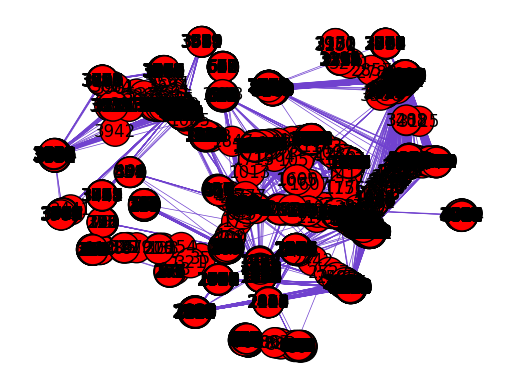

In [6]:
# Visualize the igraph of the nodes and edges
_, ax = plt.subplots()
ig.plot(igraph_li, target=ax, vertex_label=igraph_li.vs['node_id'], edge_width=[0.5], edge_color=["#7142cf"]
)
plt.show()

## [2] Features Creation

[i] Create features for each node in the graph based on different centralities defined in the Graph Theory. The definition of each centrality used in this solution is mentioned as inline comments

In [10]:
# COLUMN - NODE ID
# Create a new dataframe and add node_id as a column from the igraph vertices
df_data = pd.DataFrame(igraph_li.vs['node_id'], columns=["node_id"])

# COLUMN - DEGREE OF NODE
# Append a new column "degree" to each node in the dataset
# Degree centrality, is defined as the number of links incident upon a node (i.e., the number of ties that a node has)
df_data = pd.concat([df_data, pd.DataFrame(igraph_li.degree(), columns=["degree"])], axis=1)

# COLUMN - CLOSENESS CENTRALITY
# closeness centrality (or closeness) of a node is the average length of the shortest path between the node and all
# other nodes in the graph. Thus the more central a node is, the closer it is to all other nodes.
df_data = pd.concat([df_data, pd.DataFrame(igraph_li.closeness(mode='all'), columns=["closeness"])], axis=1)


# COLUMN - HARMONIC CENTRALITY
# The harmonic centerality of a vertex measures how easily other vertices can be reached from it (or the other way:
# how easily it can be reached from the other vertices). It is defined as the mean inverse distance to all other
# vertices.
df_data = pd.concat([df_data, pd.DataFrame(igraph_li.harmonic_centrality(mode='all'), columns=["harmonic"])],
                    axis=1)

# COLUMN - BETWEENNESS CENTRALITY
#  Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two
#  other nodes.
df_data = pd.concat([df_data, pd.DataFrame(igraph_li.betweenness(directed=False), columns=["betweenness"])],
                    axis=1)

# COLUMN - PAGE RANK EXACT
#  Page Rank assigns a score of importance to each node. Important nodes are those with many inlinks from important
#  pages.
df_data = pd.concat([df_data, pd.DataFrame(igraph_li.pagerank(directed=False, damping=0.85),
                                           columns=["pagerank"])], axis=1)

[ii] Create features for each node and its immediate neighborhood (2 hops and 3 hops) in the graph based on different centralities. The definitions of some centrailities not used before are mentioned as inline comments

In [11]:
# Function that returns the centralities of all nodes in their immediate
# neighborhood, given the number of hops to find the immediate neighborhood

def get_sub_graph_centrality_metrics(n_hop_neighbors):
    sub_graph_num_of_nodes =[]
    sub_graph_num_of_edges =[]
    sub_graph_mean_degree = []
    sub_graph_density = []
    sub_graph_mean_closeness_centrality = []
    sub_graph_mean_harmonic_centrality = []
    sub_graph_mean_betweenness_centrality = []
    sub_graph_page_rank = []
    sub_graph_count_motifs = []
    sub_graph_average_local_clustering_coefficient = []
    sub_graph_average_global_clustering_coefficient = []

    for vertex in igraph_li.vs:
        neighbors_within_n_hops = igraph_li.neighborhood(vertex, order=n_hop_neighbors)
        subgraph = igraph_li.subgraph(neighbors_within_n_hops)

        sub_graph_num_of_nodes.append(subgraph.vcount())
        sub_graph_num_of_edges.append(subgraph.ecount())


        sub_graph_mean_degree.append(np.array(subgraph.degree()).mean())
        sub_graph_density.append(subgraph.density(loops=False))
        sub_graph_mean_closeness_centrality.append(np.array(subgraph.closeness(mode='all')).mean())
        sub_graph_mean_harmonic_centrality.append(np.array(subgraph.harmonic_centrality(mode='all')).mean())
        sub_graph_mean_betweenness_centrality.append(np.array(subgraph.betweenness(directed=False)).mean())
        sub_graph_page_rank.append(np.array(subgraph.pagerank(directed=False, damping=0.85)).mean())

        # Network motifs are sub-graphs that repeat themselves in a specific network or even among various networks.
        sub_graph_count_motifs.append(subgraph.motifs_randesu_no(size=3))

        # The local clustering coefficient of a vertex (node) in a graph quantifies how close its neighbours are to
        # being a clique (complete graph)
        sub_graph_average_local_clustering_coefficient.append(subgraph.transitivity_avglocal_undirected(mode='nan'))

        # The global clustering coefficient is based on triplets of nodes. A triplet is three nodes that are connected
        # by either two (open triplet) or three (closed triplet) undirected ties. A triangle graph therefore includes
        # three closed triplets, one centered on each of the nodes (n.b. this means the three triplets in a triangle
        # come from overlapping selections of nodes). The global clustering coefficient is the number of closed
        # triplets (or 3 x triangles) over the total number of triplets (both open and closed).
        sub_graph_average_global_clustering_coefficient.append(subgraph.transitivity_undirected(mode='nan'))

    df = pd.DataFrame({"node_id": igraph_li.vs["node_id"],
                         "sub_graph_num_of_nodes_" + str(n_hop_neighbors) + "_hops": sub_graph_num_of_nodes,
                         "sub_graph_num_of_edges_" + str(n_hop_neighbors) + "_hops": sub_graph_num_of_edges,
                         "sub_graph_mean_degree_" + str(n_hop_neighbors) + "_hops": sub_graph_mean_degree,
                         "sub_graph_density_" + str(n_hop_neighbors) + "_hops": sub_graph_density,
                         "sub_graph_mean_closeness_centrality_" + str(n_hop_neighbors) + "_hops": sub_graph_mean_closeness_centrality,
                         "sub_graph_mean_harmonic_centrality" + str(n_hop_neighbors) + "_hops": sub_graph_mean_harmonic_centrality,
                         "sub_graph_mean_betweenness_centrality_" + str(n_hop_neighbors) + "_hops": sub_graph_mean_betweenness_centrality,
                         "sub_graph_page_rank_" + str(n_hop_neighbors) + "_hops": sub_graph_page_rank,
                         "sub_graph_average_local_clustering_coefficient_" + str(n_hop_neighbors) + "_hops" : sub_graph_average_local_clustering_coefficient,
                         "sub_graph_average_global_clustering_coefficient_" + str(n_hop_neighbors) + "_hops": sub_graph_average_global_clustering_coefficient,
                         "sub_graph_count_motifs_" + str(n_hop_neighbors) + "_hops": sub_graph_count_motifs})
    return df

In [12]:
# Extract Local Features based on subgraphs - 2 hops away
df_data_subgraph_2_hops = get_sub_graph_centrality_metrics(2)

# # Extract Local Features based on subgraphs - 3 hops away
df_data_subgraph_3_hops = get_sub_graph_centrality_metrics(3)

In [13]:
# Combine all the features into a single dataframe with name "df_data"

df_data_subgraph = pd.concat([df_data_subgraph_2_hops, df_data_subgraph_3_hops], axis=1, join="inner")
df_data = pd.concat([df_data, df_data_subgraph], axis=1, join="inner")

In [14]:
# Inspect the columns of the dataset

print(df_data.columns)
print(df_data.info())

Index(['node_id', 'degree', 'closeness', 'harmonic', 'betweenness', 'pagerank',
       'node_id', 'sub_graph_num_of_nodes_2_hops',
       'sub_graph_num_of_edges_2_hops', 'sub_graph_mean_degree_2_hops',
       'sub_graph_density_2_hops',
       'sub_graph_mean_closeness_centrality_2_hops',
       'sub_graph_mean_harmonic_centrality2_hops',
       'sub_graph_mean_betweenness_centrality_2_hops',
       'sub_graph_page_rank_2_hops',
       'sub_graph_average_local_clustering_coefficient_2_hops',
       'sub_graph_average_global_clustering_coefficient_2_hops',
       'sub_graph_count_motifs_2_hops', 'node_id',
       'sub_graph_num_of_nodes_3_hops', 'sub_graph_num_of_edges_3_hops',
       'sub_graph_mean_degree_3_hops', 'sub_graph_density_3_hops',
       'sub_graph_mean_closeness_centrality_3_hops',
       'sub_graph_mean_harmonic_centrality3_hops',
       'sub_graph_mean_betweenness_centrality_3_hops',
       'sub_graph_page_rank_3_hops',
       'sub_graph_average_local_clustering_coeffic

All columns and numeric and all the cells in the dataset are not nulls

## [3] Data Cleaning
--
Remove the nodes that are not connected to any other nodes in the graph

In [15]:
# Look at the averages of all columns

print(df_data.describe())

           node_id       degree    closeness     harmonic   betweenness  \
count  4039.000000  4039.000000  4039.000000  4039.000000  4.039000e+03   
mean   2019.000000    43.691013     0.276168     0.306578  5.436171e+03   
std    1166.103197    52.420605     0.036124     0.041342  9.492587e+04   
min       0.000000     1.000000     0.178255     0.190707  0.000000e+00   
25%    1009.500000    11.000000     0.260348     0.284279  3.258249e+00   
50%    2019.000000    25.000000     0.282457     0.312275  2.378620e+01   
75%    3028.500000    57.000000     0.315001     0.344680  1.235069e+02   
max    4038.000000  1045.000000     0.459699     0.566489  3.916560e+06   

          pagerank      node_id  sub_graph_num_of_nodes_2_hops  \
count  4039.000000  4039.000000                    4039.000000   
mean      0.000248  2019.000000                     717.167863   
std       0.000258  1166.103197                     310.813292   
min       0.000041     0.000000                      60.0000

For a node, there are features ('sub_graph_num_of_edges_2_hops' and 'sub_graph_num_of_edges_3_hops') in the graph where minimum value for the number of edges is 0. It means there exists some nodes that are not connected to any other nodes. These node won't be useful in clustering because they don't offer any information about the network. Hence deleting those nodes.

In [16]:
# Deleting the nodes that are not connected to any other nodes in the graph.
# Because we cannot extract any information from them
isolated_nodes = [v.index for v in igraph_li.vs if v.degree() == 0]
igraph_li.delete_vertices(isolated_nodes)

In [17]:
# Saving the data in a file as a checkpoint (This is to reduce the time to
# retrieve the features from the graph, when the session is restarted)
df_data.to_csv(path_or_buf="/content/drive/MyDrive/graph_features.csv")

## [4] Data Exploration with Visualization
--
Take a look at the data and understand the patterns. Remove outliers.

In [18]:
# Load data into pandas dataframe from checkpoint
df_data = pd.read_csv("/content/drive/MyDrive/graph_features.csv")

In [19]:
# Drop columns "Unnamed: 0", "node_id.1", and "node_id.2" because they are ids
# and indices.
# Note: Not deleting column 'node_id' for now (we will remove this column later)
df_data.drop('Unnamed: 0', axis=1, inplace=True)
df_data.drop('node_id.1', axis=1, inplace=True)
df_data.drop('node_id.2', axis=1, inplace=True)

In [20]:
# Check the datatypes of all the extracted features (ignore 'node_id' for now):
# They all are numeric. None of them are categorical
print(df_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4039 entries, 0 to 4038
Data columns (total 28 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   node_id                                                 4039 non-null   int64  
 1   degree                                                  4039 non-null   int64  
 2   closeness                                               4039 non-null   float64
 3   harmonic                                                4039 non-null   float64
 4   betweenness                                             4039 non-null   float64
 5   pagerank                                                4039 non-null   float64
 6   sub_graph_num_of_nodes_2_hops                           4039 non-null   int64  
 7   sub_graph_num_of_edges_2_hops                           4039 non-null   int64  
 8   sub_graph_mean_degree_2_hops          

In [21]:
# Build the list of columns except column node_id
columns_except_node_id = list(df_data.columns)
columns_except_node_id.remove('node_id')

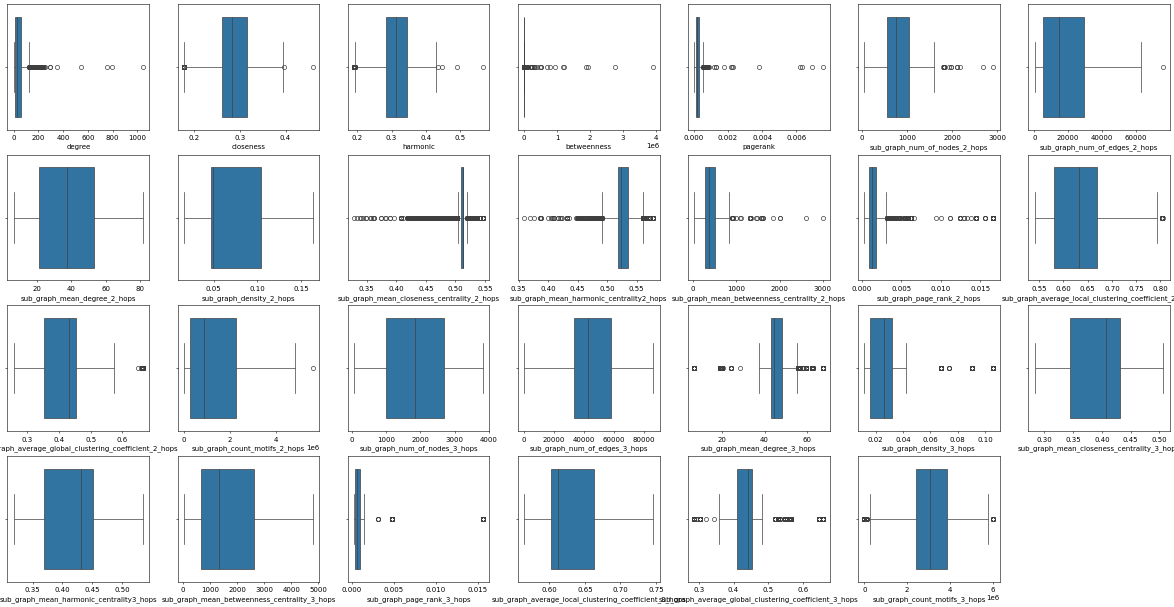

In [22]:
# Plotting the outliers using Boxplot
plt.figure(figsize=(30,15), dpi=50)

i = 1
for col in columns_except_node_id:
    plt.subplot(4, 7, i)
    i += 1
    sns.boxplot(x=col, data=df_data)
plt.show()

In [23]:
# Getting the z-scores for the data (i.e. converting the data into standard normalized form)

z = np.abs(stats.zscore(df_data[columns_except_node_id]))
z_scores = pd.DataFrame(z)

selecting 3 as the threshold to identify outliers in the data. Z-scores generally range from -3 standard deviations up to +3 standard deviations

In [24]:
# Print outliers that are 3 std deviations away
threshold = 3
print('Outlier points along with the respective column numbers in the second array')
print(np.where(z > threshold))

Outlier points along with the respective column numbers in the second array
(array([   0,    0,    0,    0,    0,    0,    7,   21,   34,   34,   56,
         58,   58,   58,   58,   58,   58,   58,   58,   58,   67,   87,
        103,  107,  107,  107,  107,  107,  107,  107,  107,  107,  107,
        107,  120,  122,  125,  136,  136,  136,  146,  156,  169,  171,
        171,  171,  171,  173,  173,  198,  198,  213,  246,  285,  304,
        308,  315,  322,  324,  339,  348,  348,  348,  348,  348,  348,
        348,  353,  363,  370,  370,  373,  373,  374,  374,  376,  376,
        376,  376,  378,  378,  391,  391,  394,  395,  395,  397,  400,
        400,  412,  412,  414,  414,  414,  414,  414,  414,  419,  420,
        422,  422,  423,  423,  428,  428,  428,  428,  428,  428,  428,
        428,  428,  431,  431,  434,  436,  436,  438,  438,  461,  461,
        465,  465,  475,  475,  475,  475,  483,  483,  483,  483,  483,
        483,  484,  492,  492,  496,  496,  497

In [25]:
# Removing the outliers
print("Datashape, before outliers removal: ",df_data.shape)
df_data = df_data[(z<threshold).all(axis=1)]
print("Datashape, after outliers removal: ", df_data.shape)
print("Data info, after outliers removal: ", df_data.info())

Datashape, before outliers removal:  (4039, 28)
Datashape, after outliers removal:  (3799, 28)
<class 'pandas.core.frame.DataFrame'>
Index: 3799 entries, 1 to 3979
Data columns (total 28 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   node_id                                                 3799 non-null   int64  
 1   degree                                                  3799 non-null   int64  
 2   closeness                                               3799 non-null   float64
 3   harmonic                                                3799 non-null   float64
 4   betweenness                                             3799 non-null   float64
 5   pagerank                                                3799 non-null   float64
 6   sub_graph_num_of_nodes_2_hops                           3799 non-null   int64  
 7   sub_graph_num_of_edges_2_hops    

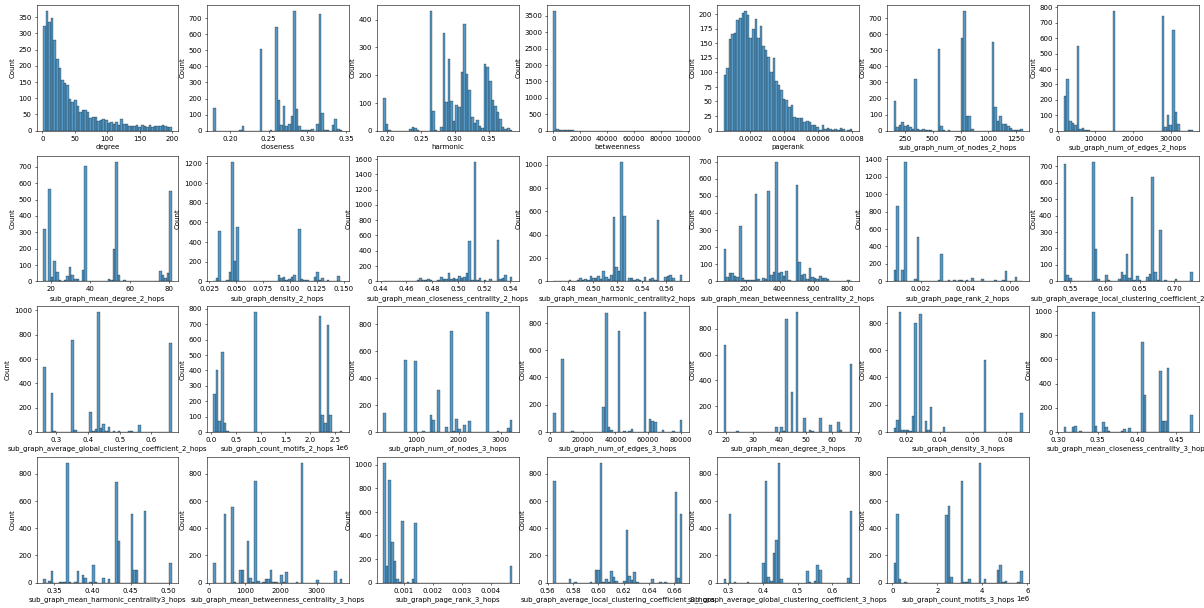

In [26]:
# Plot the histogram for the features in the data
plt.figure(figsize=(30,15), dpi=50)
i = 1
for col in columns_except_node_id:
    plt.subplot(4, 7, i)
    i += 1
    sns.histplot(df_data[col], bins=50, label=col)
plt.show()

In [27]:
# Find the correlation matrix for the features
print(df_data.corr())

                                                     node_id    degree  \
node_id                                             1.000000  0.031965   
degree                                              0.031965  1.000000   
closeness                                          -0.184076  0.225354   
harmonic                                           -0.108877  0.372451   
betweenness                                        -0.052633  0.124199   
pagerank                                            0.052657  0.687468   
sub_graph_num_of_nodes_2_hops                       0.168916  0.319118   
sub_graph_num_of_edges_2_hops                      -0.001934  0.465414   
sub_graph_mean_degree_2_hops                        0.012572  0.483160   
sub_graph_density_2_hops                           -0.335560  0.163149   
sub_graph_mean_closeness_centrality_2_hops          0.059663  0.012407   
sub_graph_mean_harmonic_centrality2_hops           -0.126159  0.092933   
sub_graph_mean_betweenness_centrality_

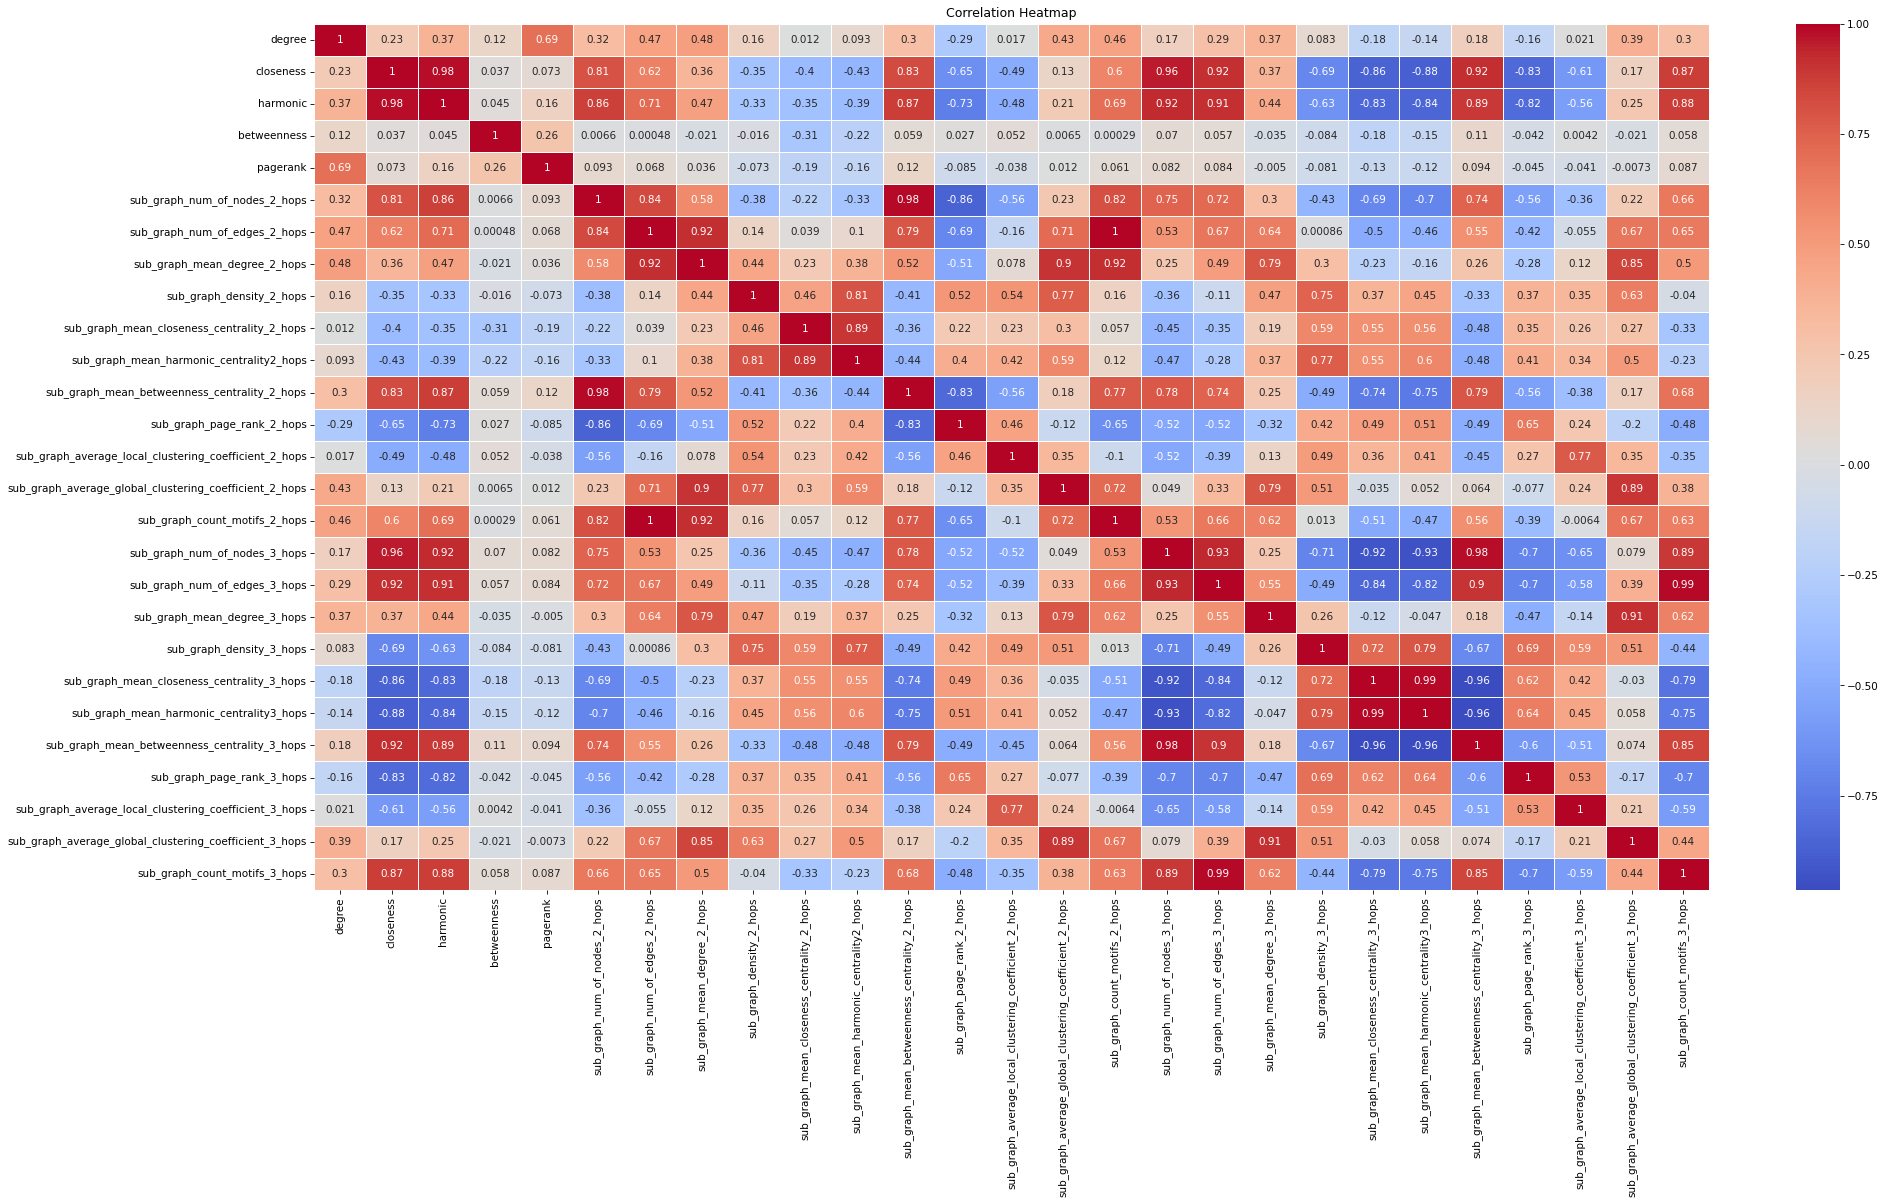

In [28]:
# Display correlation matrix in a heatmap

plt.figure(figsize=(30,15), dpi=75)
sns.heatmap(df_data[columns_except_node_id].corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.savefig(fname='correlation_matrix.png')
plt.show()

In [29]:
# Separate the node_id column from rest of the columns (features) in the data.
# Because node_id is not a feature but an id.
# Later column Node_id will be used for plotting the graph

df_node_id = pd.DataFrame(df_data['node_id'], columns=['node_id'])
print(df_node_id.shape)

df_features = pd.DataFrame(df_data[columns_except_node_id], columns=columns_except_node_id)
print(df_features.shape)

(3799, 1)
(3799, 27)


## [5] Data Scaling and PCA
--
Scale the data and perform Principle Component Analysis for dimensionality Reduction

In [30]:
# Using Standard Scaler for scaling the data
# Because the data is Normally distributed (single and multi modal Normal
# Distribution)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_features)

df_featurs_scaled = pd.DataFrame(features_scaled, columns=df_features.columns)

In [31]:
# Initialize PCA and then fit the scaled data to reduce the number of dimensions
pca = PCA(random_state=123)
pca.fit(df_featurs_scaled)

PCA(random_state=123)

In [32]:
# Variation explained by each component extracted by PCA (First component
# explains most variance and last component explains least variance)

print(pca.explained_variance_ratio_)

[4.70690240e-01 2.39780035e-01 6.75647699e-02 6.28242942e-02
 4.75098184e-02 3.53647560e-02 3.02192070e-02 2.11572721e-02
 8.84357921e-03 7.08740333e-03 4.00010697e-03 2.35027520e-03
 1.30616329e-03 5.79609165e-04 3.44786196e-04 1.32317433e-04
 1.06269709e-04 9.11841776e-05 2.13488514e-05 1.06801663e-05
 6.66484776e-06 3.29733385e-06 2.46504529e-06 1.72291365e-06
 8.84749345e-07 5.47244875e-07 3.01906460e-07]


In [33]:
# PCA cumulative variance ratios

var_cumu = np.cumsum(pca.explained_variance_ratio_)
print(var_cumu)

[0.47069024 0.71047027 0.77803504 0.84085934 0.88836916 0.92373391
 0.95395312 0.97511039 0.98395397 0.99104137 0.99504148 0.99739176
 0.99869792 0.99927753 0.99962232 0.99975463 0.9998609  0.99995209
 0.99997344 0.99998412 0.99999078 0.99999408 0.99999654 0.99999827
 0.99999915 0.9999997  1.        ]


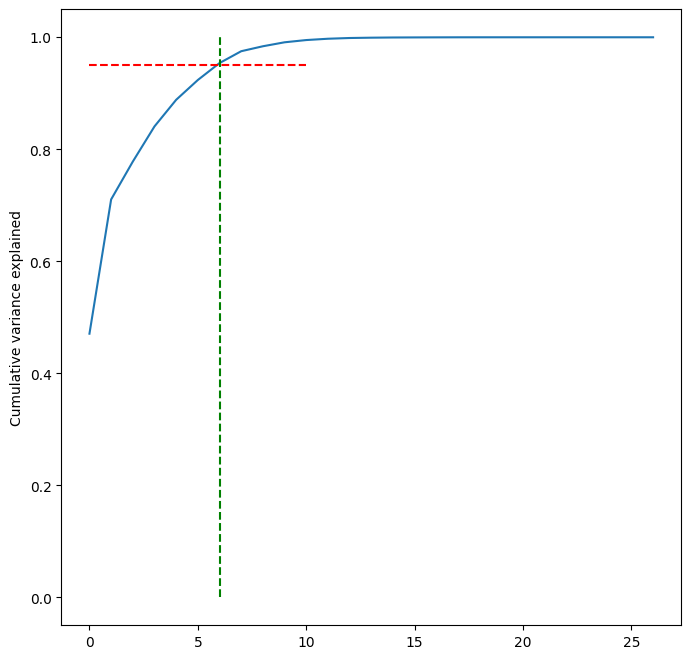

In [34]:
# Plot the cumulative variance captured by PCA components. Draw a horizontal
# line marking 95% of the variance in the data

fig = plt.figure(figsize=[8,8],dpi=100)
plt.plot(var_cumu)
plt.vlines(x=6, ymax=1, ymin=0, colors="green", linestyles="--")
plt.hlines(y=0.95, xmax=10, xmin=0, colors="red", linestyles="--")
plt.ylabel("Cumulative variance explained")
plt.show()

It is observed that, first 7 components of PCA explain more than 95% variance in the input features, so selecting first 7 components
Note: The features selected after PCA are not interpretable. So for the final interpretation of the clusters, I'm going to compare the the features before PCA

In [35]:
# Select first 7 PCA components

pca_final = PCA(n_components=7, random_state=123)
df_data_pca_final = pca_final.fit_transform(df_featurs_scaled)

In [36]:
# Convert to dataframe. We will use dataframe "X" for clustering

X = pd.DataFrame(df_data_pca_final)

# [E] Clustering
---

## [1] Utility functions
--

### [i] Utility functions to add attributes to vertices and plot the graphs

In [37]:
# Function to build the dictionary of "node_id" to "label"
def build_labels_dict(classification_labels):
    df_classification_labels = pd.Series(classification_labels, name='label').to_frame()

    labels_dict = dict()
    for i in range(df_classification_labels.shape[0]):
        labels_dict[df_node_id.iloc[i]['node_id']] = df_classification_labels.iloc[i]['label']

    return labels_dict


# Function to add label and color attributes to vertices and plot the clustering
# graph when the attribute name and labels dictionary is given
def add_attributes_and_plot_clustering_graph(vertex_label_attribute_name, labels_dict, num_of_clusters):
    color_list = ig.drawing.colors.RainbowPalette(num_of_clusters)

    for vertex in igraph_li.vs:
        if vertex['node_id'] in labels_dict.keys():
            vertex[vertex_label_attribute_name] = labels_dict[vertex['node_id']]
            vertex['color'] = color_list[vertex[vertex_label_attribute_name]]

    _, ax = plt.subplots(figsize=(30, 15), dpi=50)
    ig.plot(igraph_li, target=ax, vertex_label=igraph_li.vs['node_id'], vertex_color=igraph_li.vs['color'],
            edge_width=[0.5], edge_color=["grey"])
    plt.savefig(fname=vertex_label_attribute_name + "_graph.png")
    plt.show()

### [ii] Utility functions to plot the sub-graphs of each cluster

In [38]:
# Function that creates the dictionary of label as key and list of node_id as value
def build_label_to_vertices_dict(vertex_label_attribute):

    label_to_vertices_dict = dict()
    for vertex in igraph_li.vs:
        if vertex[vertex_label_attribute] is not None:
            vertex_list = label_to_vertices_dict.get(vertex[vertex_label_attribute], [])
            vertex_list.append(vertex['node_id'])
            label_to_vertices_dict[vertex[vertex_label_attribute]] = vertex_list

    return label_to_vertices_dict


# Function to plot the subgraphs of all clusters for an algorithm
def plot_clustered_subgraphs(num_of_clusters, label_to_vertices_dict, algorithm_name):
    cols_for_plot = round(num_of_clusters / 5)
    rows_for_plot = round(num_of_clusters / cols_for_plot) + 1
    plt.figure(figsize=(30, 15), dpi=50)
    i = 1
    for label, vertices in label_to_vertices_dict.items():
        subgraph = igraph_li.subgraph(vertices)
        ax = plt.subplot(rows_for_plot, cols_for_plot, i)
        ax.title.set_text("Cluster label: " + str(label))
        i += 1
        ig.plot(subgraph, target=ax, vertex_label=subgraph.vs['node_id'], vertex_color=subgraph.vs['color'],
                edge_width=[0.5], edge_color=["grey"])

    plt.savefig(fname="/content/drive/MyDrive/" + algorithm_name + "_cluster_subgraphs.png")
    plt.show()

### [iii] Utility function to create the data for cluster analysis

In [39]:
# Function to create cluster analysis data

def create_cluster_analysis_data(algorithm_name, label_to_vertices_dict):
    report_file_name = "/content/drive/MyDrive/project_report_for_" + algorithm_name + ".txt"

    if os.path.exists(report_file_name):
        os.remove(report_file_name)

    with open(report_file_name, 'a') as report_file:

        for label, vertices in label_to_vertices_dict.items():
            nodes_in_cluster = df_data[df_data['node_id'].isin(vertices)]

            report_file.write("\n****************" + algorithm_name + " vertices in cluster " + str(label) + "****************\n\n")
            means_cluster = nodes_in_cluster.mean()
            entire_graph = df_data.mean()
            report_file.write("Feature name : inside cluster : entire graph : observation \n\n")
            for index, feature in means_cluster.items():
                if index != 'node_id':
                    report_file.write(str(index) + " : " + str(feature) + " : " + str(entire_graph[index]) + ". \n Hence, ")
                    if feature > entire_graph[index]:
                        report_file.write(str(index).replace("sub_graph_", "") + " of nodes in this cluster is at least " + str(round(feature/entire_graph[index])) + " times more than global equivalent \n\n")
                    elif feature < entire_graph[index]:
                        report_file.write(str(index).replace("sub_graph_", "") + " of nodes in this cluster is at least " + str(round(entire_graph[index]/feature)) + " times less than global equivalent \n\n")

            report_file.write("===============================================================\n")

### [iv] Utility functions to calculate Dunn Index

In [40]:
# Function that returns the Euclidean distance between two multidimensional features
def euclidean_distance(pt1, pt2):
    if len(pt1) != len(pt2):
        raise Exception("Length of points i.e. number of coordinates should be same")
    return np.power(np.sum(np.power(np.subtract(pt1, pt2), 2)), 0.5)

# Function that returns the maximum distance between the centroid of the cluster and each point within the same cluster
def get_intra_cluster_distance(cluster_center, cluster_label , features_labels_combined):
    nodes_in_cluster = features_labels_combined[features_labels_combined['label'] == cluster_label]

    max_distance = 0
    for _, row in nodes_in_cluster.iterrows():
        distance = euclidean_distance(np.array(cluster_center), np.array(row)[ :-1])

        # This condition is added to ignore the distance if centroid is same as the node
        if distance > 0:
            max_distance = max(distance, max_distance)
    return max_distance

# Function that returns the minimum distance between the selected cluster center and all other cluster centers
def get_inter_cluster_distance(cluster_center, all_cluster_centers):

    min_distance = np.inf
    for neighbor_cluster_center in all_cluster_centers:
        distance = euclidean_distance(cluster_center, neighbor_cluster_center)

        # This condition is added to ignore the distance of a cluster center from itself
        if distance > 0:
            min_distance = min(min_distance, distance)

    return min_distance

# Function that returns the dunn index of the clusters
def get_dunn_index(centroids, labels, input_features):

    df_features_labels_combined = pd.concat([input_features, pd.DataFrame(labels, columns=["label"])], axis=1)

    max_intra_cluster_distance = 0
    min_inter_cluster_distance = np.inf
    for label in np.unique(labels):
        intra_cluster_distance = get_intra_cluster_distance(centroids[label], label, df_features_labels_combined)
        max_intra_cluster_distance = max(max_intra_cluster_distance, intra_cluster_distance)

        inter_cluster_distance = get_inter_cluster_distance(centroids[label], centroids)
        min_inter_cluster_distance = min(min_inter_cluster_distance, inter_cluster_distance)

    return min_inter_cluster_distance/ max_intra_cluster_distance

## [2] BIRCH
--

Advantages of Birch:
1. Time complexity is O(n) (one pass), hence is very fast and scalable
2. It can be used with other clustering algorithms. Usually Birch is used as a first step because of its high speed
3. High accuracy
4. Less memory consumption

Disadvantages of Birch:
1. Birch assumes the spherical shape of the clusters
2. Less robust to the outliers (this will be a separate cluster in the result)

Minimum number of features required for Birch is = 1, and we have 7 features (after PCA).
Tree pruning is done to reduce the number of clusters to the given number. In out example we are tuning the value of
number of clusters (i.e. the pruning factor for the tree).
Higher value of branching factor creates flatter tree, and lower value of branching factor creates the taller tree
Threshold defines the distance above which the algorithm should create a new node in the tree.

Since Birch is fast and offers high accuracy I'm using this for linkedin dataset.

### [i] Hyperparameter selection/ tuning

In [41]:
# For different values of hyperparameters, find different scores

thresholds = [1, 1.5, 2]
branching_factors = [5, 10]
num_of_clusters = [10, 15, 18, 20]

birch_calinski_harabasz_scores = []
birch_davies_bouldin_scores = []
birch_silhouette_scores_euclidean =[]
birch_silhouette_scores_manhattan = []
x_labels_for_scores = []

for threshold in thresholds:
    for branching_factor in branching_factors:
        for num in num_of_clusters:
            birch = Birch(threshold=threshold, branching_factor=branching_factor, n_clusters=num)
            birch.fit(X)
            birch_classification_labels = birch.predict(X)
            birch_calinski_harabasz_scores.append(calinski_harabasz_score(X, birch_classification_labels))
            birch_davies_bouldin_scores.append(davies_bouldin_score(X, birch_classification_labels))
            birch_silhouette_scores_euclidean.append(silhouette_score(X, birch_classification_labels, metric='euclidean'))
            birch_silhouette_scores_manhattan.append(silhouette_score(X, birch_classification_labels, metric='manhattan'))
            x_labels_for_scores.append(str(threshold) + "_" + str(branching_factor) + "_" + str(num))

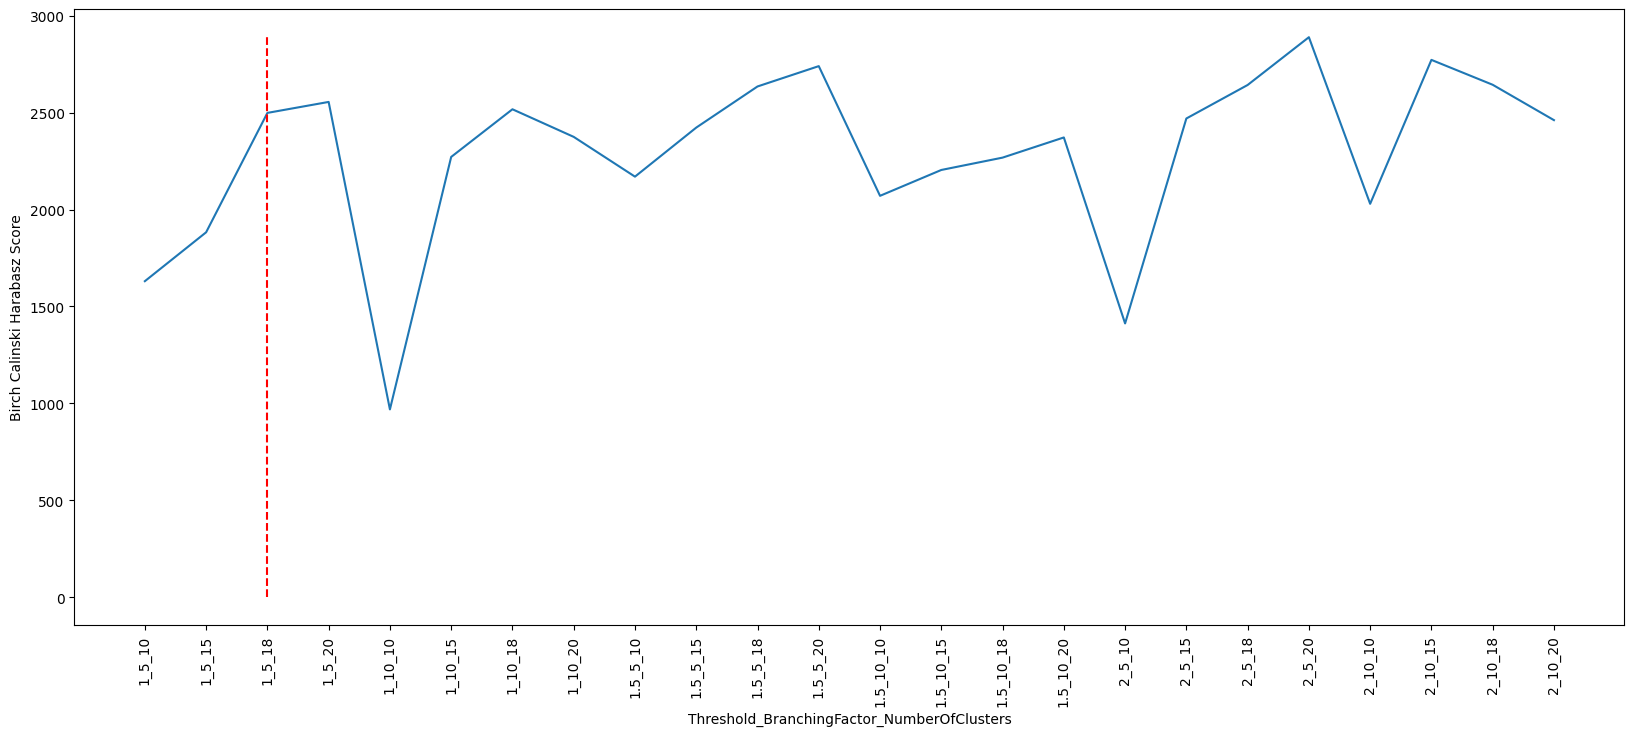

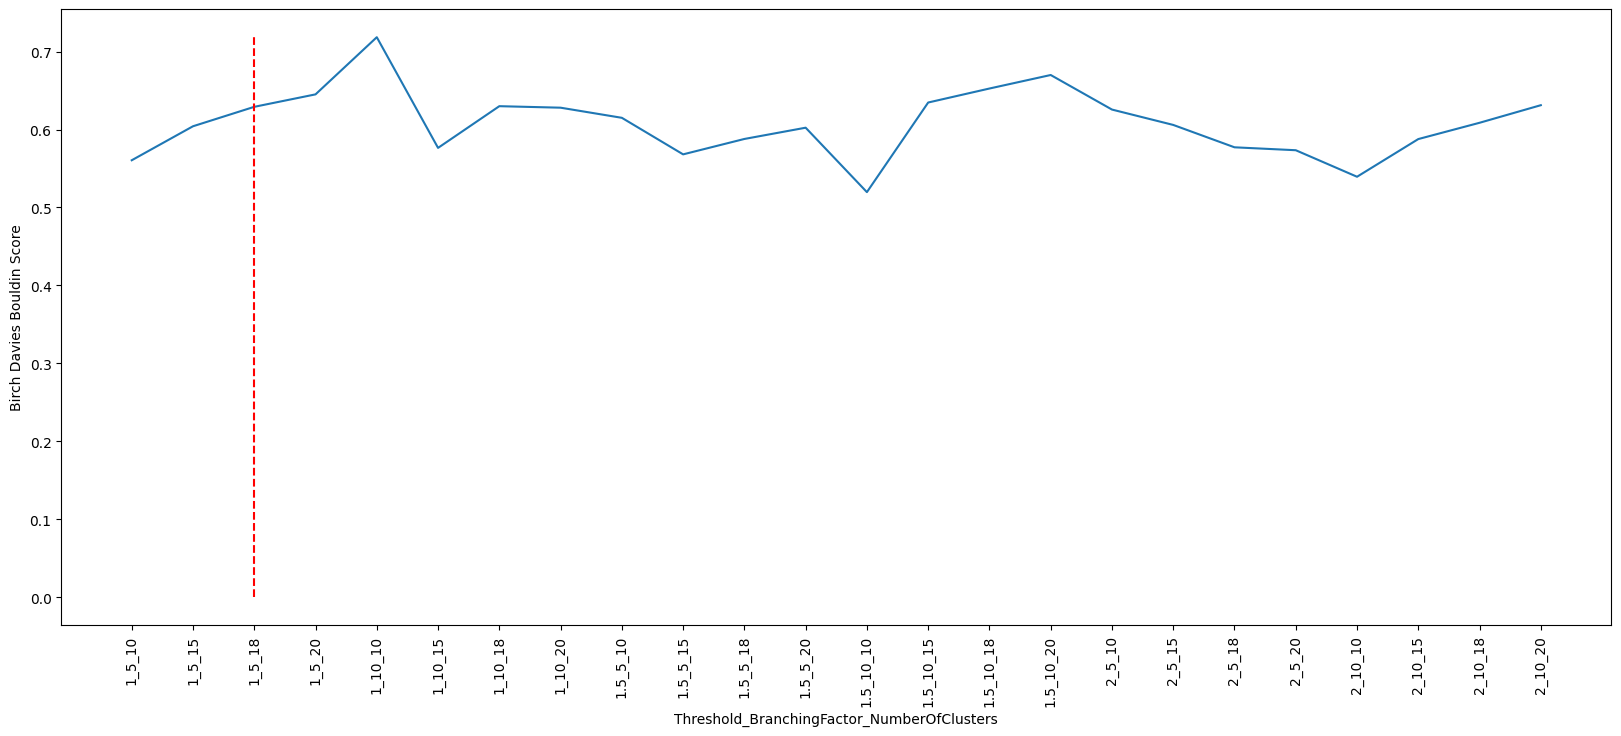

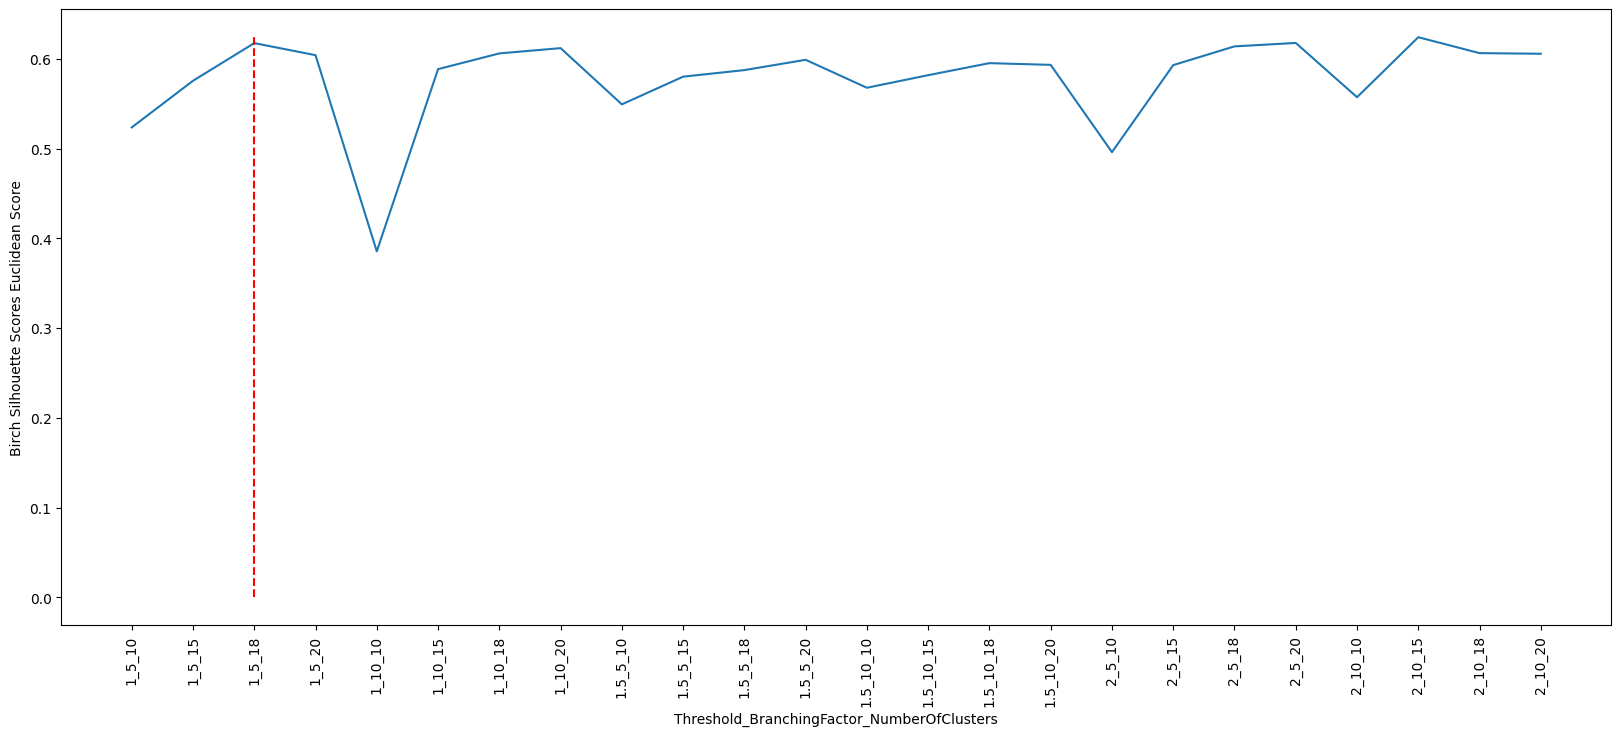

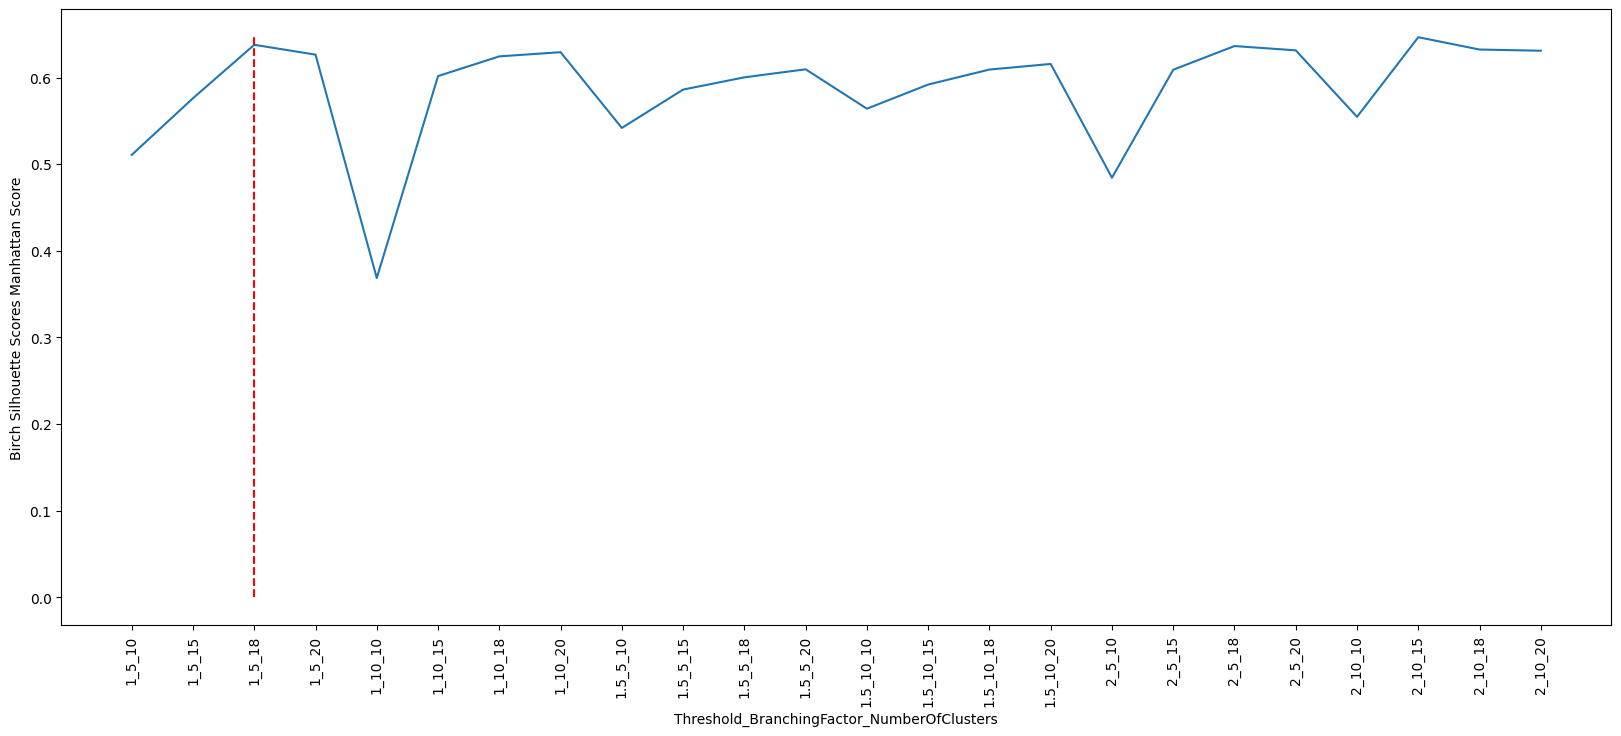

In [42]:
# Plot Calinski Harabasz Scores
plt.figure(figsize=[20,8],dpi=100)
plt.plot(x_labels_for_scores, birch_calinski_harabasz_scores)
plt.ylabel("Birch Calinski Harabasz Score")
plt.xlabel("Threshold_BranchingFactor_NumberOfClusters")
plt.xticks(rotation=90)
plt.vlines(x="1_5_18", ymax=np.array(birch_calinski_harabasz_scores).max(), ymin=0, colors="red", linestyles="--")
plt.show()

# Plot Davies Bouldin Scores
plt.figure(figsize=[20,8],dpi=100)
plt.plot(x_labels_for_scores, birch_davies_bouldin_scores)
plt.ylabel("Birch Davies Bouldin Score")
plt.xlabel("Threshold_BranchingFactor_NumberOfClusters")
plt.xticks(rotation=90)
plt.vlines(x="1_5_18", ymax=np.array(birch_davies_bouldin_scores).max(), ymin=0, colors="red", linestyles="--")
plt.show()

# Plot Silhouette Scores Euclidean
plt.figure(figsize=[20,8],dpi=100)
plt.plot(x_labels_for_scores, birch_silhouette_scores_euclidean)
plt.ylabel("Birch Silhouette Scores Euclidean Score")
plt.xlabel("Threshold_BranchingFactor_NumberOfClusters")
plt.xticks(rotation=90)
plt.vlines(x="1_5_18", ymax=np.array(birch_silhouette_scores_euclidean).max(), ymin=0, colors="red", linestyles="--")
plt.show()

# Plot Silhouette Scores Manhattan
plt.figure(figsize=[20,8],dpi=100)
plt.plot(x_labels_for_scores, birch_silhouette_scores_manhattan)
plt.ylabel("Birch Silhouette Scores Manhattan Score")
plt.xlabel("Threshold_BranchingFactor_NumberOfClusters")
plt.xticks(rotation=90)
plt.vlines(x="1_5_18", ymax=np.array(birch_silhouette_scores_manhattan).max(), ymin=0, colors="red", linestyles="--")
plt.show()

All 3 metrics above are distance based however prioritizing Silhouette score over other scores because unlike Calinski
Harabasz score and Davies Bouldin score it has the upper and lower bound so you can accurately gauge the overall
performance of the clustering.\
Silhouette score = -1 => Incorrect clusters\
Silhouette score = 0 => Overlapping clusters\
Silhouette score = +1 => Highly dense clusters



Considering plots of all the scores above, I think Silhouette Score should be given a priority over other scores
because Birch assumes the circular shape of the clusters and Silhouette Score gives better scores if the clusters are
convex shaped (as compared to the irregular shapes).
In this plot the Silhouette score peaks at threshold=1, branching_factor=5, num_of_clusters = 18. Hence, will use
these values for our clustering

### [ii] Build clusters with best Hyperparameters

In [43]:
# Birch with threshold=1, branching_factor=5, num_of_clusters = 18
num_of_clusters = 18
threshold = 1
branching_factor = 5
birch = Birch(threshold=threshold, branching_factor=branching_factor, n_clusters=num_of_clusters)
birch.fit(X)
birch_classification_label = birch.predict(X)

### [iii] Evaluation

In [44]:
# Calinski Harabasz Score: (threshold: higher values indicate better clustering)
# For Calinski Harabasz Score, we should choose the num of clusters that give peak of the score or at least the
# elbow on the plot. Lesser value means well separated and dense clusters
birch_calinski_harabasz_score = calinski_harabasz_score(X, birch_classification_label)
print("Birch Calinski Harabasz Score: ", birch_calinski_harabasz_score)
# 2498.393870351795

# Davies Bouldin Score: (threshold: lower values indicate better clustering)
# For Davies Bouldin Score, we should choose the num of clusters that gives the least value. Lesser value means well
# separated and more compact clusters
birch_davies_bouldin_score = davies_bouldin_score(X, birch_classification_label)
print("Birch Davies Bouldin Score: ", birch_davies_bouldin_score)
# 0.6291014366523631

# Silhouette Score: (threshold: >0.5)
# For Silhouette Score, the value of score should be as close to +1 as possible. Score close to +1 indicates that the
# vertices are well-matched to its own cluster and poorly matched to the neighboring cluster. For Silhouette score we
# are using 2 distance metrics, viz Euclidean distance and Manhattan distance. Euclidean distance is good for when
# features are normally distributed and Manhattan distance is good for discrete features. Since our data is normally
# distributed (single modal and multi-modal) we will prioritize Silhouette score using Euclidean distance over
# Silhouette score using Manhattan distance.
# Note: cosine distance not considered because it is not good for capturing the relative distance. Cosine distance is
# mostly use in NLP use cases when words are related to each other based on angles.

# Silhouette Score Euclidean
birch_silhouette_score_euclidean = silhouette_score(X, birch_classification_label, metric='euclidean')
print("Birch Silhouette Euclidean Score: ", birch_silhouette_score_euclidean)
# 0.6178413179638821

# Silhouette Score Manhattan
birch_silhouette_score_manhattan = silhouette_score(X, birch_classification_label, metric='manhattan')
print("Birch Silhouette Manhattan Score: ", birch_silhouette_score_manhattan)
# 0.6377725532432912

Birch Calinski Harabasz Score:  2498.393870351828
Birch Davies Bouldin Score:  0.6291014380980081
Birch Silhouette Euclidean Score:  0.6178413179622086
Birch Silhouette Manhattan Score:  0.6377725532432583


### [iv] Visualization

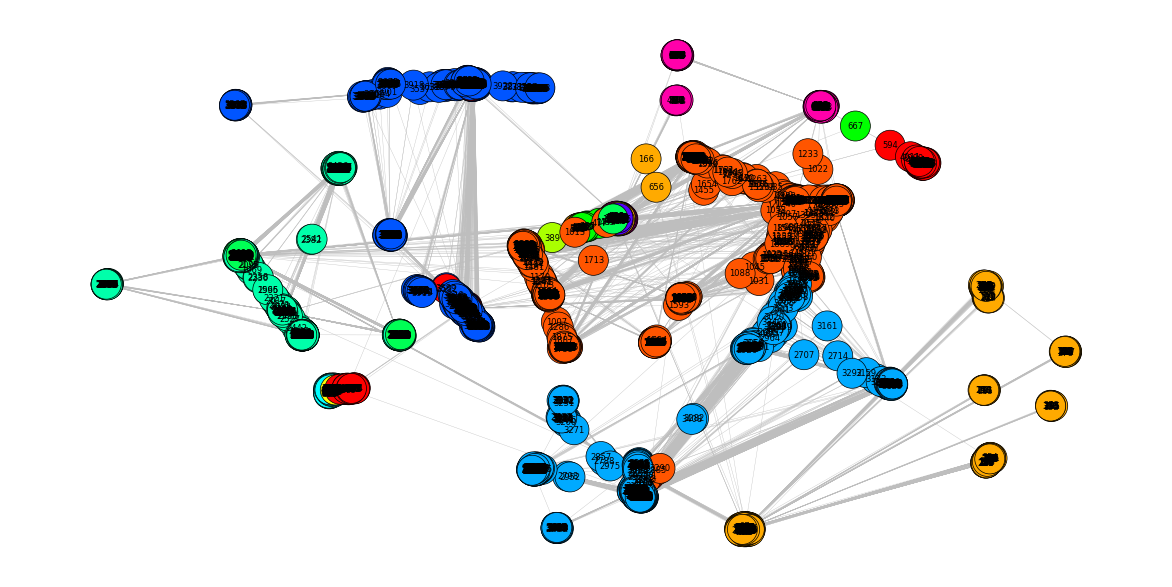

In [45]:
# Plot graph of the nodes in this cluster
labels_dict = build_labels_dict(birch_classification_label)
add_attributes_and_plot_clustering_graph("birch_label", labels_dict, num_of_clusters)


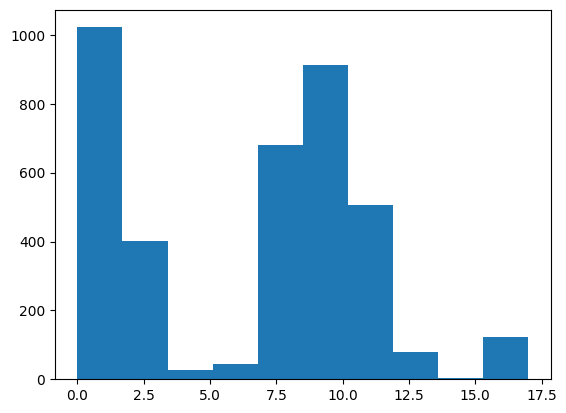

In [46]:
# Histogram of labels show us how many nodes are in each cluster
plt.hist(birch_classification_label)
plt.show()

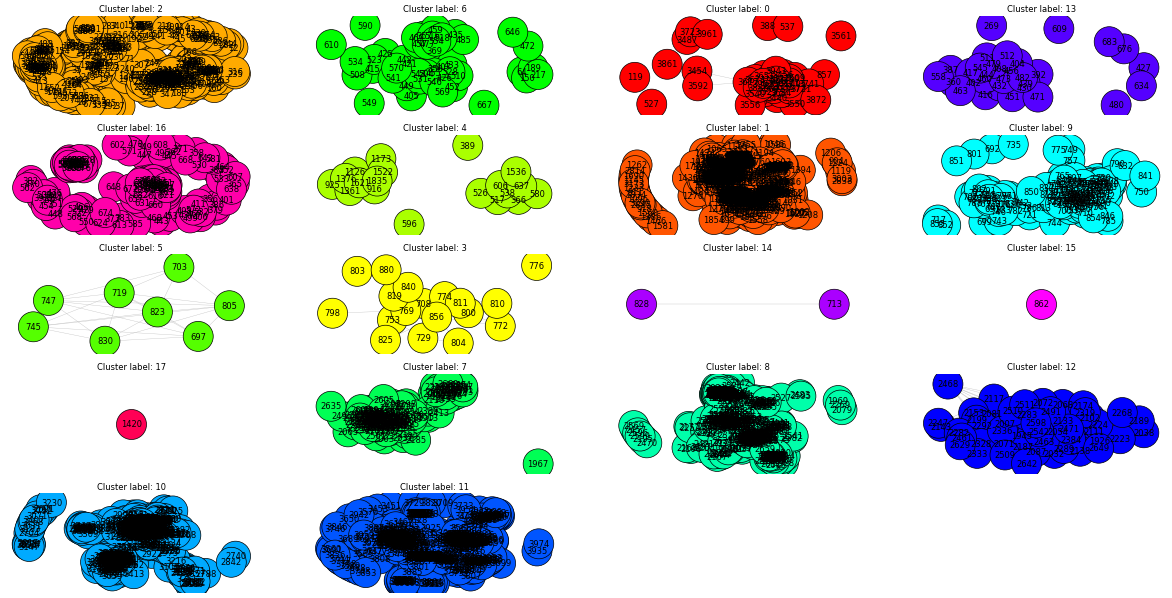

In [47]:
algorithm_name = 'birch'

label_to_vertices_dict = build_label_to_vertices_dict('birch_label')

# Plot subgraphs for the cluster analysis
plot_clustered_subgraphs(num_of_clusters, label_to_vertices_dict, algorithm_name)

## [2] KMeans
---

Advantages of KMeans:
1. KMeans is a simple algorithm
2. Results of this algorithm are interpretable (however in our linkedin dataset, because of PCA features and results
   are not interpretable).
3. It scales easily for large datasets
4. It is flexible algorithm that can easily adjust to changes in the data
5. KMeans always converges

Disadvantages of KMeans:
1. KMeans is sensitive to the initial centroid of the cluster selection
2. We need to input the number of clusters
3. It is slow because you have to iterate over all the data several times
4. Boundaries of the cluster are always linear, so clusters with the curve shaped boundaries are hard to fit
5. Sensitive to outliers
6. Hard to handle different cluster densities

Minimum number of features required for KMeans is = 1, and we have > 1 number of features.

For the linkedin dataset, we use KMeans because of its simplicity and scalability.
We also have removed some of the outliers by z-scaling, hence KMeans may not struggle with a lot of outliers.

### [i] Hyperparameter selection/ tuning

In [48]:
# For different values of number of clusters, find different scores

num_of_clusters = np.arange(5, 50, 1)

kmeans_ssd = []
kmeans_silhouette_scores_euclidean = []
kmeans_silhouette_scores_manhattan = []
kmeans_dunn_index = []
for num in num_of_clusters:
    kmeans = KMeans(n_clusters=num, max_iter=1000, random_state=123)
    kmeans.fit(X)
    kmeans_ssd.append(kmeans.inertia_)
    kmeans_silhouette_scores_euclidean.append(silhouette_score(X, kmeans.labels_, metric='euclidean'))
    kmeans_silhouette_scores_manhattan.append(silhouette_score(X, kmeans.labels_, metric='manhattan'))
    kmeans_dunn_index.append(get_dunn_index(kmeans.cluster_centers_, kmeans.labels_, X))

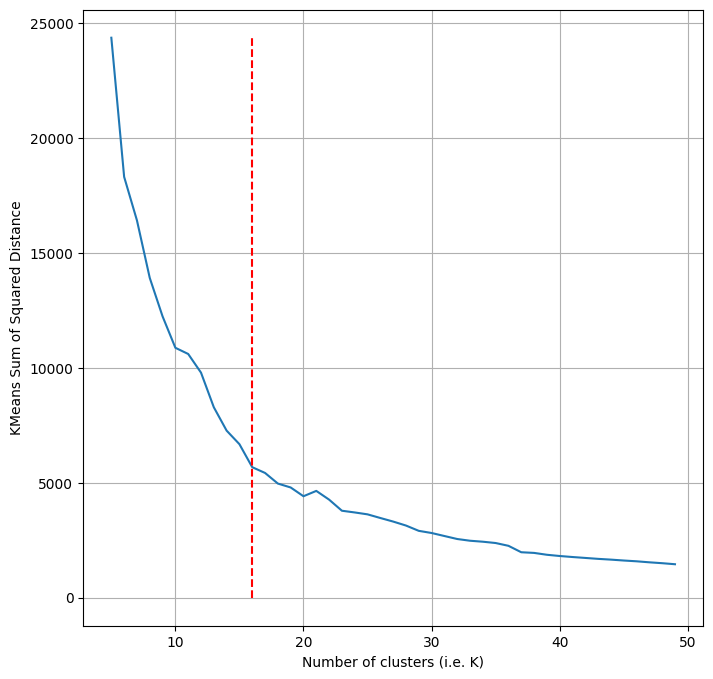

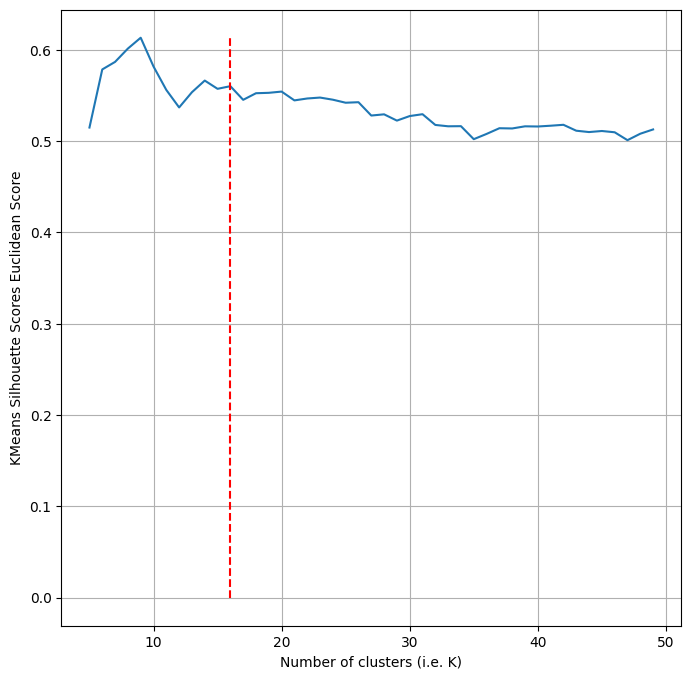

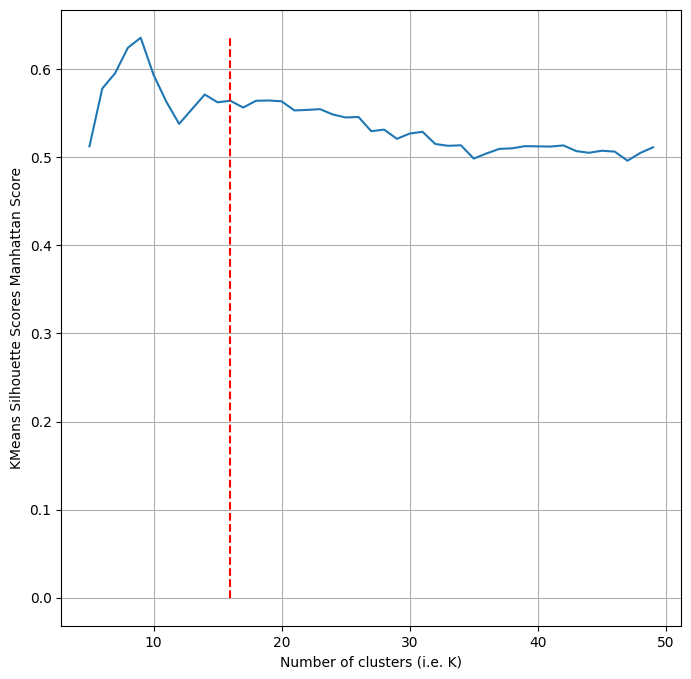

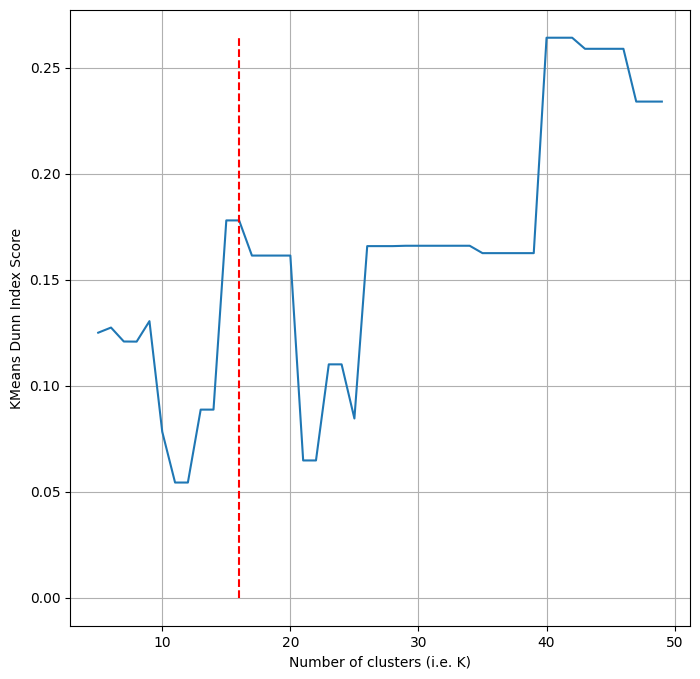

In [49]:
# Plot Sum of Squared Distance
plt.figure(figsize=[8,8],dpi=100)
plt.plot(num_of_clusters, kmeans_ssd)
plt.ylabel("KMeans Sum of Squared Distance")
plt.xlabel("Number of clusters (i.e. K)")
plt.vlines(x=16, ymax=np.array(kmeans_ssd).max(), ymin=0, colors="red", linestyles="--")
plt.grid(True)
plt.show()

# Plot Silhouette Scores Euclidean
plt.figure(figsize=[8,8],dpi=100)
plt.plot(num_of_clusters, kmeans_silhouette_scores_euclidean)
plt.ylabel("KMeans Silhouette Scores Euclidean Score")
plt.xlabel("Number of clusters (i.e. K)")
plt.vlines(x=16, ymax=np.array(kmeans_silhouette_scores_euclidean).max(), ymin=0, colors="red", linestyles="--")
plt.grid(True)
plt.show()

# Plot Silhouette Scores Manhattan
plt.figure(figsize=[8,8],dpi=100)
plt.plot(num_of_clusters, kmeans_silhouette_scores_manhattan)
plt.ylabel("KMeans Silhouette Scores Manhattan Score")
plt.xlabel("Number of clusters (i.e. K)")
plt.vlines(x=16, ymax=np.array(kmeans_silhouette_scores_manhattan).max(), ymin=0, colors="red", linestyles="--")
plt.grid(True)
plt.show()

# Plot Dunn Index score
plt.figure(figsize=[8,8],dpi=100)
plt.plot(num_of_clusters, kmeans_dunn_index)
plt.ylabel("KMeans Dunn Index Score")
plt.xlabel("Number of clusters (i.e. K)")
plt.vlines(x=16, ymax=np.array(kmeans_dunn_index).max(), ymin=0, colors="red", linestyles="--")
plt.grid(True)
plt.show()

Considering all the plots above,
For SSD, I see elbows at num of clusters = 10, 16, 18, 23.
For Silhouette score Euclidean, plot peaks at num of clusters = 9, 14, 16, and after that score slowly goes down (with
some hills in between)
For Silhouette score Manhattan, plot peaks at num of clusters = 9, 14, 16, 18, 19, 20 and after that score slowly goes
down (with some hills in between)
For Dunn Index the value of Index is high at num of clusters = 15, 16, and then even higher at num of clusters from
40 to 50.

The plots above give us many choices to select num of clusters, but I think num of clusters = 16 is a good compromise

### [ii] Build clusters with best Hyperparameters

In [50]:
# KMeans with num_of_clusters = 16
num_of_clusters = 16
kmeans = KMeans(n_clusters=num_of_clusters, max_iter=1000, random_state=123)
kmeans.fit(X)

KMeans(max_iter=1000, n_clusters=16, random_state=123)

### [iii] Evaluation

In [51]:
# Sum of Squared Distance: (threshold: lower values indicate better clustering)
# For sum of squared distance, we should choose the num of clusters that minimize the ssd or result in an elbow plot.
# SSD measures the cluster compactness
kmeans_sum_of_squared_distance = kmeans.inertia_
print("KMeans Sum of Squared Distance: ", kmeans_sum_of_squared_distance)
# 5679.2371225265215

# Silhouette Score: (threshold: >0.5)
# For Silhouette Score, the value of score should be as close to +1 as possible. Score close to +1 indicates that the
# vertices are well-matched to its own cluster and poorly matched to the neighboring cluster. For Silhouette score we
# are using 2 distance metrics, viz Euclidean distance and Manhattan distance. Euclidean distance is good for when
# features are normally distributed and Manhattan distance is good for discrete features. Since our data is normally
# distributed (single modal and multi-modal) we will prioritize Silhouette score using Euclidean distance over
# Silhouette score using Manhattan distance.
# Note: cosine distance not considered because it is not good for capturing the relative distance. Cosine distance is
# mostly use in NLP use cases when words are related to each other based on angles.

# Silhouette Score Euclidean
kmeans_silhouette_score_euclidean = silhouette_score(X, kmeans.labels_, metric='euclidean')
print("KMeans Silhouette Euclidean Score: ", kmeans_silhouette_score_euclidean)
# 0.5601172444252062

# Silhouette Score Manhattan
kmeans_silhouette_score_manhattan = silhouette_score(X, kmeans.labels_, metric='manhattan')
print("KMeans Silhouette Manhattan Score: ", kmeans_silhouette_score_manhattan)
# 0.5641879185038096

# Dunn Index: (threshold: higher values indicate better clustering)
# Dunn index identifies the sets of compact clusters having low variance between nodes in the cluster. The clusters
# are well separated. The means of different clusters are far apart, as compared to the within cluster variance.
kmeans_dunn_index_score = get_dunn_index(kmeans.cluster_centers_, kmeans.labels_, X)
print("Dunn Index Score: ", kmeans_dunn_index_score)
# 0.17796436329496051

KMeans Sum of Squared Distance:  5679.237122526482
KMeans Silhouette Euclidean Score:  0.5601172444225199
KMeans Silhouette Manhattan Score:  0.564187918503792
Dunn Index Score:  0.17796436329490345


### [iv] Visualization

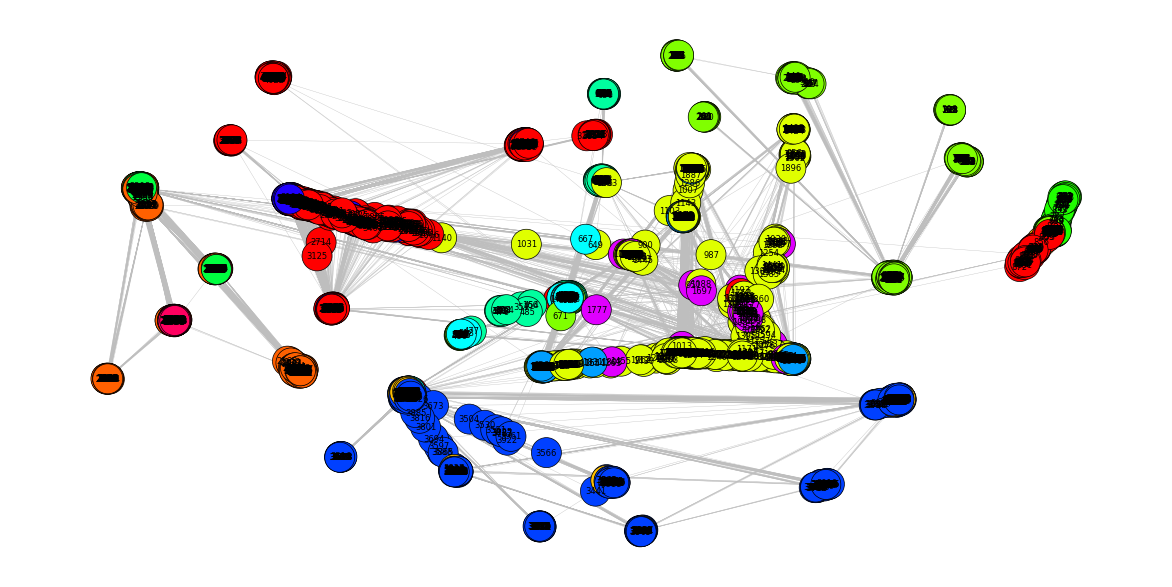

In [52]:
# Plot graph
labels_dict = build_labels_dict(kmeans.labels_)
add_attributes_and_plot_clustering_graph("kmeans_label", labels_dict, num_of_clusters)

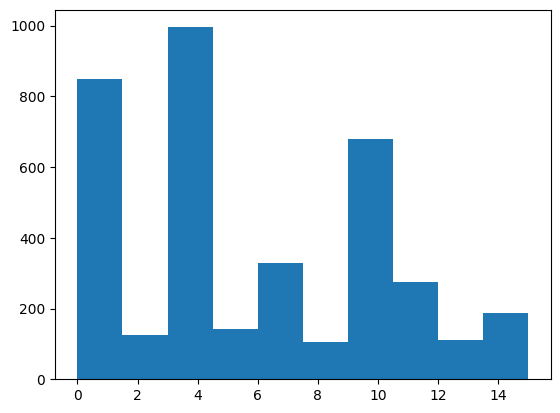

In [53]:
# Histogram of labels show us how many nodes are in each cluster
plt.hist(kmeans.labels_)
plt.show()

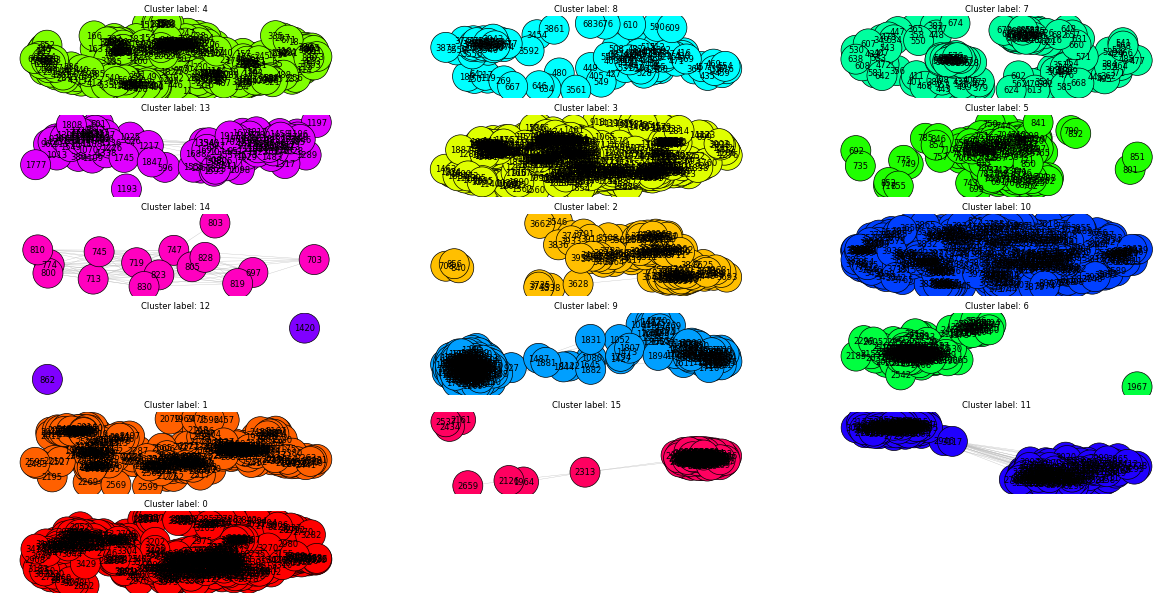

In [54]:
algorithm_name = 'kmeans'

label_to_vertices_dict = build_label_to_vertices_dict('kmeans_label')

# Plot subgraphs for the cluster analysis
plot_clustered_subgraphs(num_of_clusters, label_to_vertices_dict, algorithm_name)

## [3] DBScan

Advantages of DBScan:
1. DBScan can handle irregular shapes of clusters
2. Robust to outliers
4. We don't need to input number of clusters to the algorithm

Disadvantages of DBScan:
1. We have to input values of parameters epsilon and minimum points. Clustering by DBScan is very sensitive to the
   selection of these parameters and this is one of the limitations of DBScan. (Heuristics me)
2. It can have difficulty handling the clusters of different densities (dense to sparse)
3. DBScan struggles with high-dimensional data.
4. It may not always find all clusters
5. High computational cost when the dataset is large


We tried to use Birch above but the limitation of Birch is that they assume the circular shape of the cluster.
We also tried to use the KMeans above which has linear boundaries.
Now we are going to use DBScan which handles irregular shapes of the clusters

DBScan struggles with higher dimensional data, but we have only 7 features after PCA.
Minimum number of nodes required for DBScan algo = 3, and we have plenty of nodes in the graph.

Select the best value of number of clusters based on Calinski Harabasz Score, Davies Bouldin Score, Silhouette Score
using Euclidean distance, and Silhouette Score using Manhattan distance

### [i] Hyperparameter Selection/ Tuning

There are 2 Hyperparameters\
[1] Minimum Distance:
The choice of min distance mainly depends on the domain. But there are different suggestions about minimum distance, for generic cases. I have chosen min_dist = num of features * 2

However we can also choose min_dist >= num of features + 1

[2] Epsilon
A Heuristic method to find the optimum value of epsilon is by using KNN (K Nearest Neighbors) algorithm with Elbow plot.

Below is how we are using KNN to select the optimum value of Epsilon


In [55]:
# [1] Minimum distance selection
min_dist = 14 # Selecting min_dist = num of features * 2


# [2] Epsilon selection using KNN and Elbow plot
# Initialize KNN with min_dist = 14
knn = NearestNeighbors(n_neighbors=min_dist).fit(X)
distances, indices = knn.kneighbors(X)

In [56]:
# Create a copy of the input data
df_knn = X.copy(deep=True)

# dataframe df_knn will contain the list of distances that are 14 nodes away from the current node
df_knn["knn_farthest_distance"] = distances[:,-1]

# Sort the distances in descending order
df_knn_sorted_by_distance = df_knn.sort_values("knn_farthest_distance", ascending=False).reset_index()

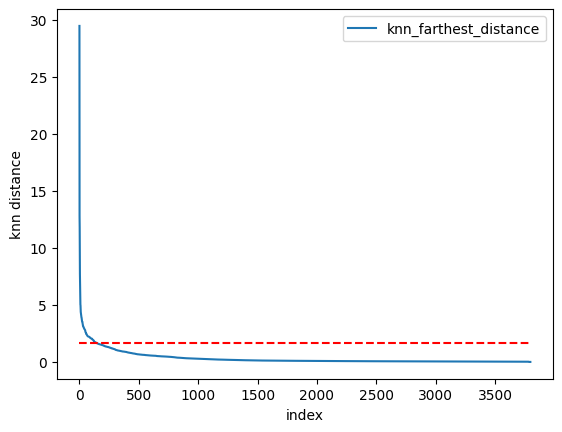

In [57]:
# Plot the graph to see Elbow
df_knn_sorted_by_distance[["knn_farthest_distance"]].plot()
plt.hlines(y=1.65, xmax=indices.max(), xmin=0, colors="red", linestyles="--")
plt.xlabel("index")
plt.ylabel("knn distance")
plt.show()

From the plot above selecting the epsilon value (knn distance) as 1.65 where an Elbow is observed.

Also the Silhouette score for clustering with epsilon = 1.65, is > 0.5 (threshold)

### [ii] Build clusters with best Hyperparameters

In [58]:
# DBScan with epsilon = 1.65
# Choosing the metric as Euclidean, because the features are Normally distributed (Single and multi-modal)
dbscan = DBSCAN(eps=1.65, min_samples=min_dist, metric='euclidean')
dbscan.fit(X)

DBSCAN(eps=1.65, min_samples=14)

### [iii] Evaluation

In [59]:
# Make a new dataframe with outliers removed, because outliers are not clusters,
# and they will mess up the distances between clusters while finding the scores.
df_scoring = X.copy(deep=True)
df_scoring["label"] = dbscan.labels_
df_scoring = df_scoring[df_scoring['label'] != -1]

X_scoring = df_scoring.loc[:, df_scoring.columns != 'label']
labels_scoring = df_scoring.loc[:, df_scoring.columns == 'label']

print("DBScan clusters (excluding outliers): ", np.unique(labels_scoring['label']))
# [0 1 2 3 4 5 6 7 8 9]

num_of_clusters = len(np.unique(labels_scoring['label']))
print("DBScan Num of clusters (excluding outliers): ", num_of_clusters)
# 10


DBScan clusters (excluding outliers):  [0 1 2 3 4 5 6 7 8 9]
DBScan Num of clusters (excluding outliers):  10


In [60]:
# Calinski Harabasz Score: (threshold: higher values indicate better clustering)
# For Calinski Harabasz Score, we should choose the num of clusters that give peak of the score or at least the
# elbow on the plot. Lesser value means well separated and dense clusters
dbscan_calinski_harabasz_score = calinski_harabasz_score(X_scoring, np.array(labels_scoring["label"]))
print("DBScan Calinski Harabasz Score: ", dbscan_calinski_harabasz_score)
# 3537.5335389471506

# Davies Bouldin Score: (threshold: lower values indicate better clustering)
# For Davies Bouldin Score, we should choose the num of clusters that gives the least value. Lesser value means well
# separated and more compact clusters
dbscan_davies_bouldin_score = davies_bouldin_score(X_scoring, np.array(labels_scoring["label"]))
print("DBScan Davies Bouldin Score: ", dbscan_davies_bouldin_score)
# 0.6731024122502939

# Silhouette Score: (threshold: >0.5)
# For Silhouette Score, the value of score should be as close to +1 as possible. Score close to +1 indicates that the
# vertices are well-matched to its own cluster and poorly matched to the neighboring cluster. For Silhouette score we
# are using 2 distance metrics, viz Euclidean distance and Manhattan distance. Euclidean distance is good for when
# features are normally distributed and Manhattan distance is good for discrete features. Since our data is normally
# distributed (single modal and multi-modal) we will prioritize Silhouette score using Euclidean distance over
# Silhouette score using Manhattan distance.
# Note: cosine distance not considered because it is not good for capturing the relative distance. Cosine distance is
# mostly use in NLP use cases when words are related to each other based on angles.

# Silhouette Score Euclidean
dbscan_silhouette_score_euclidean = silhouette_score(X_scoring, np.array(labels_scoring["label"]), metric='euclidean')
print("DBScan Silhouette Euclidean Score: ", dbscan_silhouette_score_euclidean)
# 0.5890346476124516

# Silhouette Score Manhattan
dbscan_silhouette_score_manhattan = silhouette_score(X_scoring, np.array(labels_scoring["label"]), metric='manhattan')
print("DBScan Silhouette Manhattan Score: ", dbscan_silhouette_score_manhattan)
# 0.6095102256970758

DBScan Calinski Harabasz Score:  3537.5335389471593
DBScan Davies Bouldin Score:  0.6731024122503062
DBScan Silhouette Euclidean Score:  0.5890346476121835
DBScan Silhouette Manhattan Score:  0.6095102256970316


### [iv] Visualization

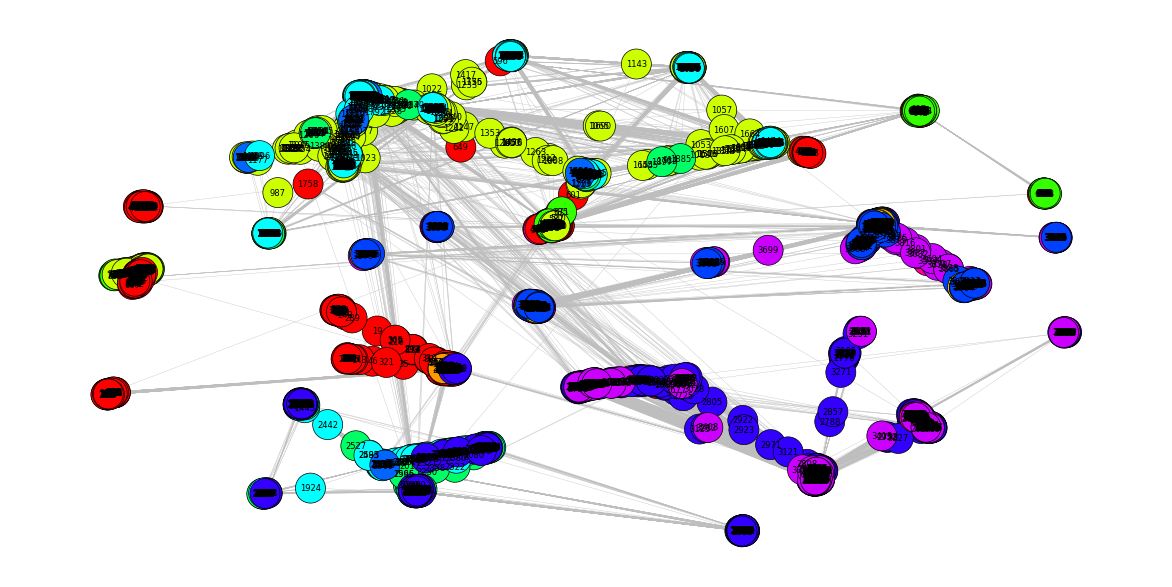

In [61]:
# Plot graph
labels_dict = build_labels_dict(np.array(labels_scoring["label"]))
add_attributes_and_plot_clustering_graph("dbscan_label", labels_dict, num_of_clusters)

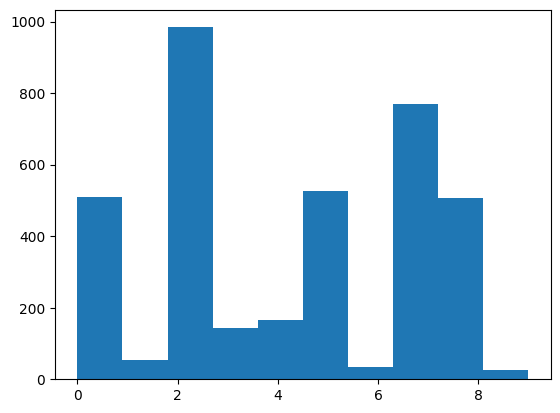

In [62]:
# Histogram of labels show us how many nodes are in each cluster
plt.hist(labels_scoring["label"])
plt.show()

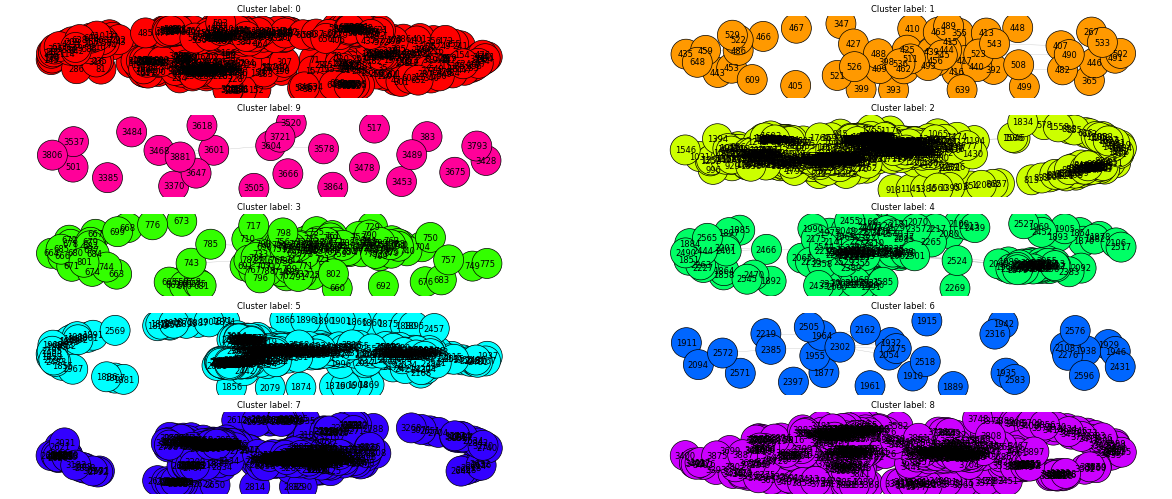

In [63]:
algorithm_name = 'dbscan'

label_to_vertices_dict = build_label_to_vertices_dict('dbscan_label')

# Plot subgraphs for the cluster analysis
plot_clustered_subgraphs(num_of_clusters, label_to_vertices_dict, algorithm_name)

## [4] Affinity Propogation

Advantages of Affinity Propagation:
1. We don't need to provide number of clusters as an input
2. It can be used with any similarity metric (eg. Euclidean distance, Manhattan distance or edit distance for
   text)

Disadvantages of Affinity Propagation:
1. It is computationally very expensive and slow. Hence, not really used for large datasets

It is used in clustering for highly aggregated datasets. One of the best use case of Affinity propagation algorithm
is in Social media. Hence, using Affinity Propagation for linkedin dataset.

The algorithm finds the clusters by selecting the exemplar which is selected by voting between the nodes. It uses
message passing between nodes to build Responsibility and Availability matrix. These matrices are then used for
finding the cluster and its exemplar

### [i] Hyperparameter Selection/ Tuning

In [64]:
# damping: When updating the message, the influence of incoming messages is
# weighted down by the damping factor.
# Damping factor should be in range 0.5 to 1
# Note: I tried different values for da

aff_prop = AffinityPropagation(damping = 0.9, max_iter = 1000, random_state=123)
aff_prop.fit(X)

damping_factors = [0.8, 0.85, 0.9, 0.95]


aff_prop_calinski_harabasz_scores = []
aff_prop_davies_bouldin_scores = []
aff_prop_silhouette_scores_euclidean =[]
aff_prop_silhouette_scores_manhattan = []

for damping_factor in damping_factors:
  aff_prop = AffinityPropagation(damping = damping_factor, max_iter = 1000, random_state=123)
  aff_prop.fit(X)

  aff_prop_calinski_harabasz_scores.append(calinski_harabasz_score(X, aff_prop.labels_))
  aff_prop_davies_bouldin_scores.append(davies_bouldin_score(X, aff_prop.labels_))
  aff_prop_silhouette_scores_euclidean.append(silhouette_score(X, aff_prop.labels_, metric='euclidean'))
  aff_prop_silhouette_scores_manhattan.append(silhouette_score(X, aff_prop.labels_, metric='manhattan'))


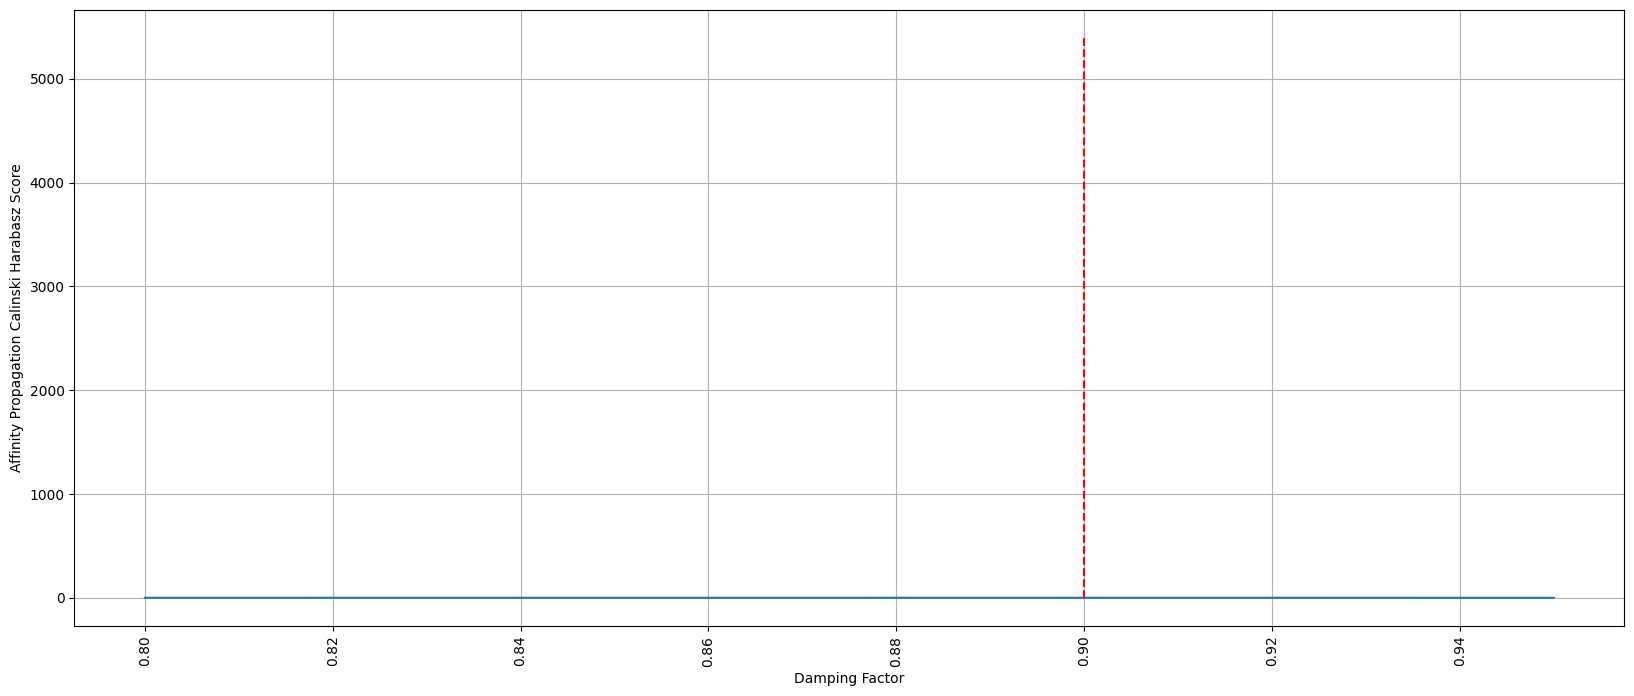

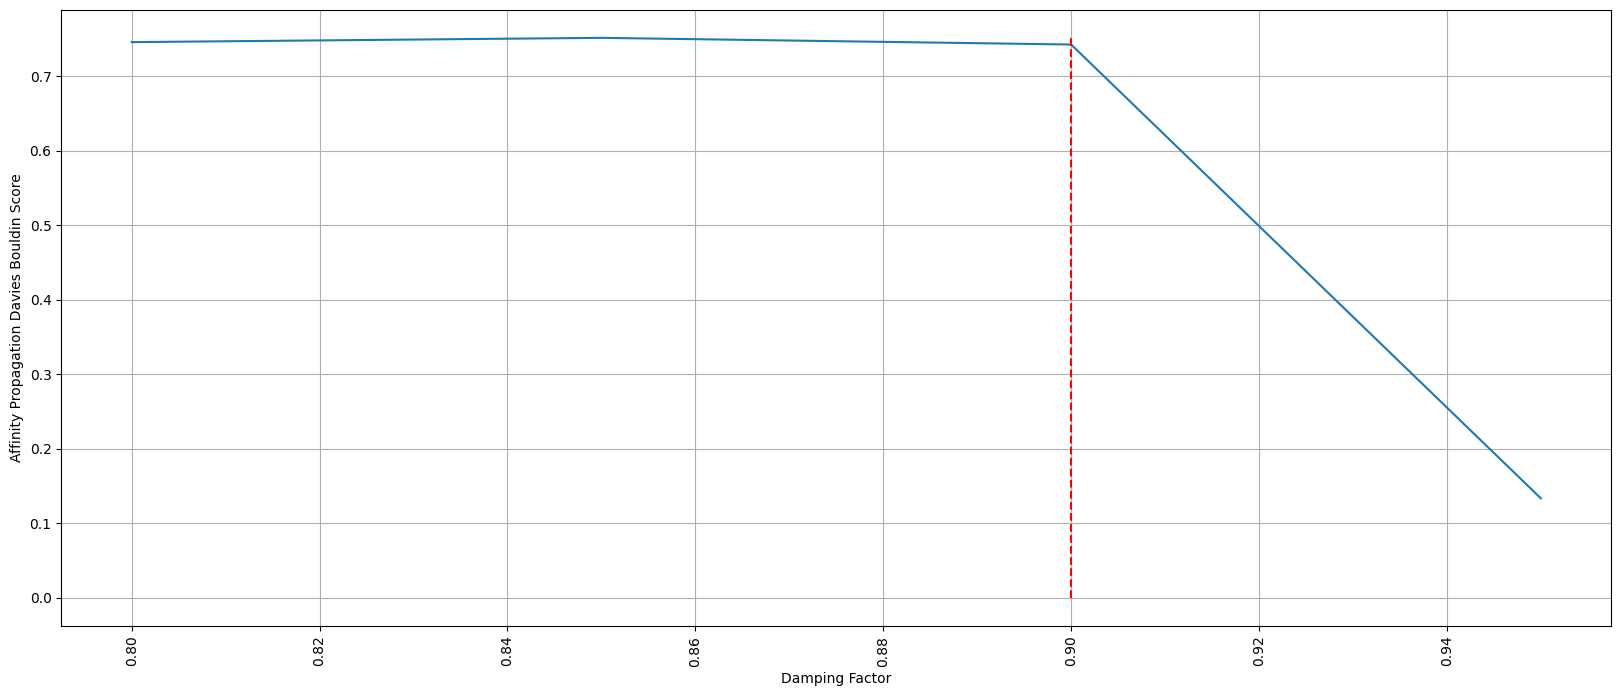

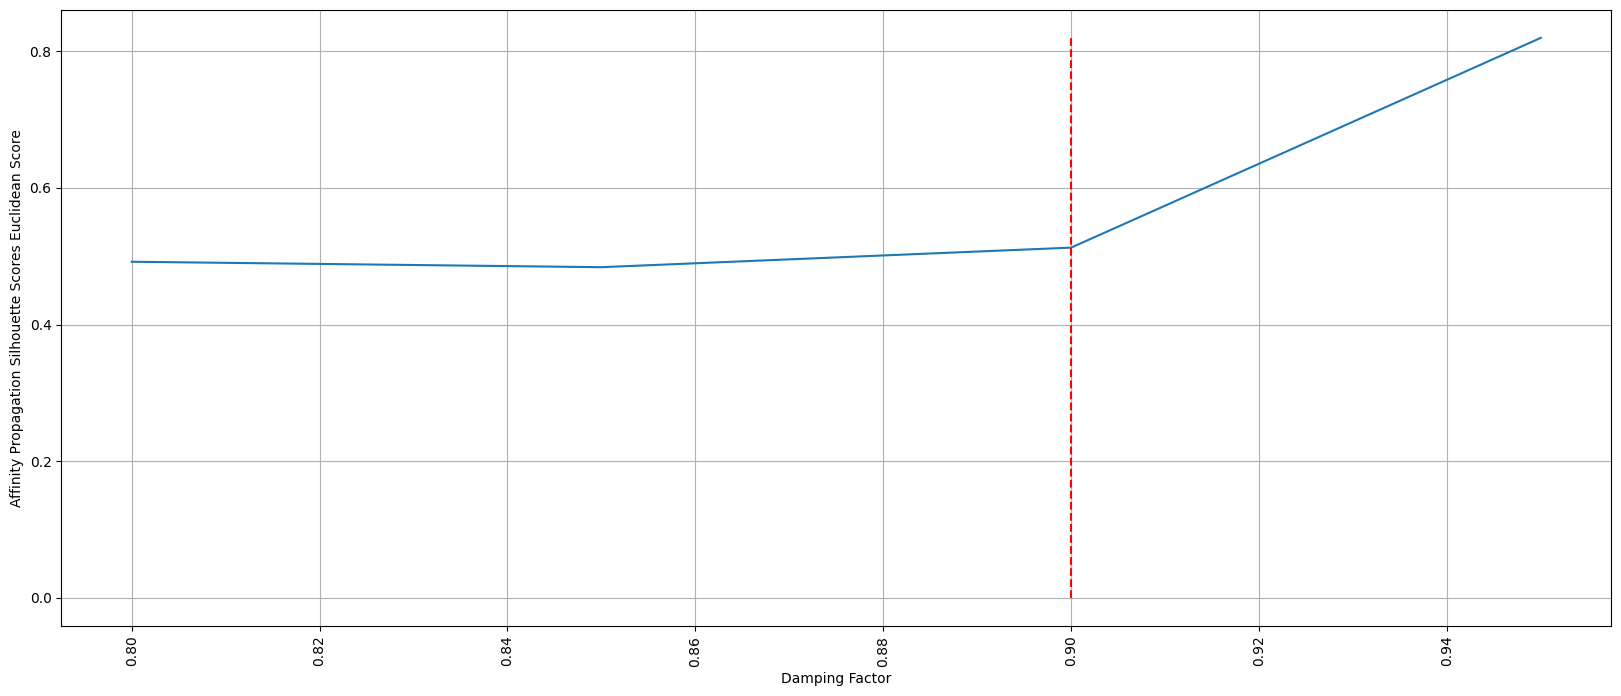

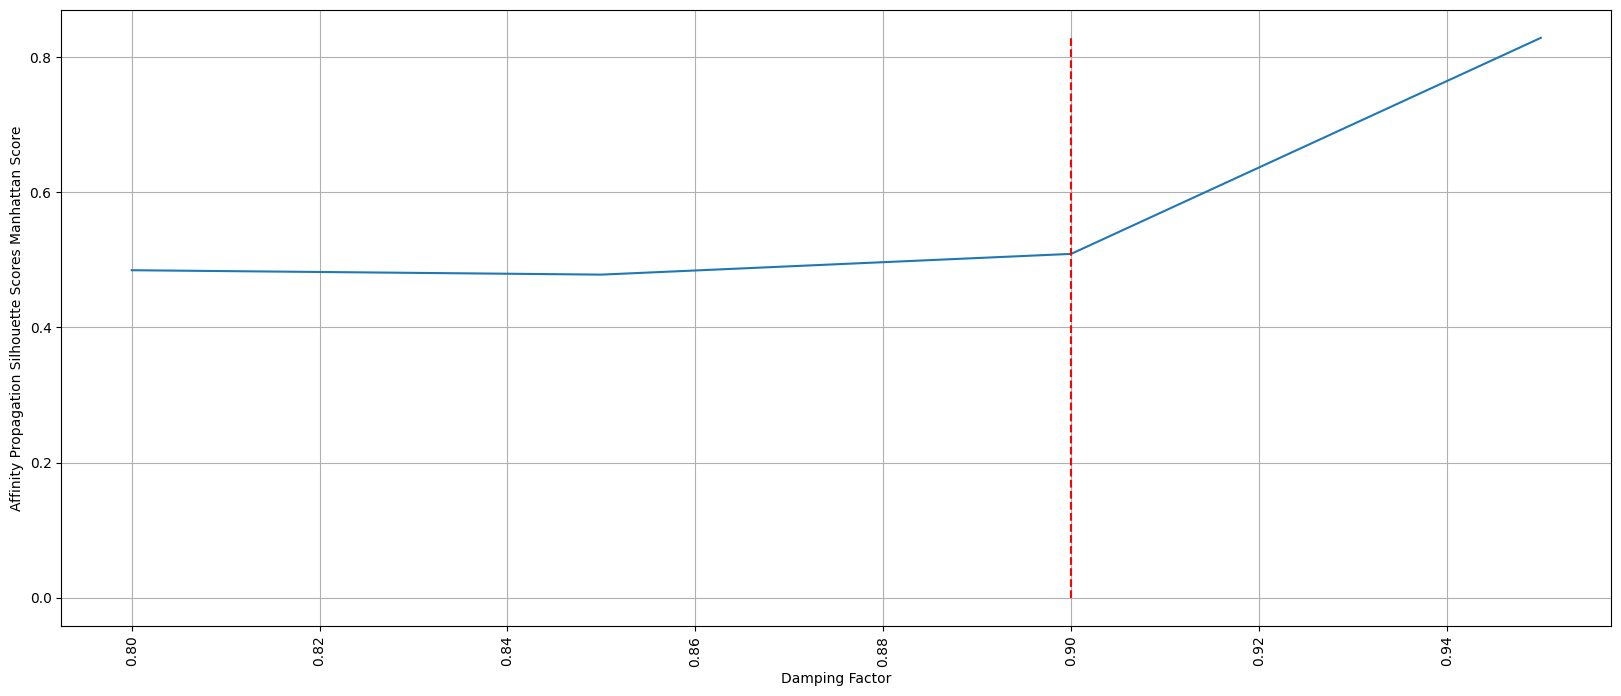

In [65]:
# Plot Calinski Harabasz Scores
plt.figure(figsize=[20,8],dpi=100)
plt.plot(damping_factors, aff_prop_davies_bouldin_scores)
plt.ylabel("Affinity Propagation Calinski Harabasz Score")
plt.xlabel("Damping Factor")
plt.xticks(rotation=90)
plt.grid(True)
plt.vlines(x=0.9, ymax=np.array(aff_prop_calinski_harabasz_scores).max(), ymin=0, colors="red", linestyles="--")
plt.show()

# Plot Davies Bouldin Scores
plt.figure(figsize=[20,8],dpi=100)
plt.plot(damping_factors, aff_prop_davies_bouldin_scores)
plt.ylabel("Affinity Propagation Davies Bouldin Score")
plt.xlabel("Damping Factor")
plt.xticks(rotation=90)
plt.grid(True)
plt.vlines(x=0.9, ymax=np.array(aff_prop_davies_bouldin_scores).max(), ymin=0, colors="red", linestyles="--")
plt.show()

# Plot Silhouette Scores Euclidean
plt.figure(figsize=[20,8],dpi=100)
plt.plot(damping_factors, aff_prop_silhouette_scores_euclidean)
plt.ylabel("Affinity Propagation Silhouette Scores Euclidean Score")
plt.xlabel("Damping Factor")
plt.xticks(rotation=90)
plt.grid(True)
plt.vlines(x=0.9, ymax=np.array(aff_prop_silhouette_scores_euclidean).max(), ymin=0, colors="red", linestyles="--")
plt.show()

# Plot Silhouette Scores Manhattan
plt.figure(figsize=[20,8],dpi=100)
plt.plot(damping_factors, aff_prop_silhouette_scores_manhattan)
plt.ylabel("Affinity Propagation Silhouette Scores Manhattan Score")
plt.xlabel("Damping Factor")
plt.xticks(rotation=90)
plt.grid(True)
plt.vlines(x=0.9, ymax=np.array(aff_prop_silhouette_scores_manhattan).max(), ymin=0, colors="red", linestyles="--")
plt.show()

Considering all the scores above, it looks like damping factor = 0.95 gives the best result. Hence lets try the clustering with damping factor 0.95

In [66]:
# Trying with Damping factor = 0.95

aff_prop = AffinityPropagation(damping = 0.95, max_iter = 1000, random_state=123)
aff_prop.fit(X)

print("Affinity Propagation clusters: ", np.unique(aff_prop.labels_))
# [ 0  1]

num_of_clusters = len(np.unique(aff_prop.labels_))
print("Affinity Propagation  Num of clusters (excluding outliers): ", num_of_clusters)
# 2

Affinity Propagation clusters:  [0 1]
Affinity Propagation  Num of clusters (excluding outliers):  2


So the damping factor = 0.95 created only 2 clusters from this big dataset. Hence I'm going lower on the damping factor hoping to improve the number of clusters.

Let's try damping factor = 0.9
For this selection of damping factor the Silhoutte score is above threshold and other scores are reasonable too.

In [67]:
aff_prop = AffinityPropagation(damping = 0.9, max_iter = 1000, random_state=123)
aff_prop.fit(X)

print("Affinity Propagation clusters: ", np.unique(aff_prop.labels_))
# [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
#  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]

num_of_clusters = len(np.unique(aff_prop.labels_))
print("Affinity Propagation  Num of clusters (excluding outliers): ", num_of_clusters)
# 43


Affinity Propagation clusters:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
Affinity Propagation  Num of clusters (excluding outliers):  43


Hence I'm choosing the damping factor = 0.9 for Affinity Propagation

### [ii] Build clusters with best Hyperparameters

In [68]:
# Damping factor = 0.9
aff_prop = AffinityPropagation(damping = 0.9, max_iter = 1000, random_state=123)
aff_prop.fit(X)

AffinityPropagation(damping=0.9, max_iter=1000, random_state=123)

### [iii] Evaluation

In [69]:
# Calinski Harabasz Score: (threshold: higher values indicate better clustering)
# For Calinski Harabasz Score, we should choose the num of clusters that give peak of the score or at least the
# elbow on the plot. Lesser value means well separated and dense clusters
aff_prop_calinski_harabasz_score = calinski_harabasz_score(X, aff_prop.labels_)
print("Affinity Propagation: Calinski Harabasz Score: ", aff_prop_calinski_harabasz_score)
# 5201.150792359589

# Davies Bouldin Score: (threshold: lower values indicate better clustering)
# For Davies Bouldin Score, we should choose the num of clusters that gives the least value. Lesser value means well
# separated and more compact clusters
aff_prop_davies_bouldin_score = davies_bouldin_score(X, aff_prop.labels_)
print("Affinity Propagation: Davies Bouldin Score: ", aff_prop_davies_bouldin_score)
# 0.7424460474738616

# Silhouette Score: (threshold: >0.5)
# For Silhouette Score, the value of score should be as close to +1 as possible. Score close to +1 indicates that the
# vertices are well-matched to its own cluster and poorly matched to the neighboring cluster. For Silhouette score we
# are using 2 distance metrics, viz Euclidean distance and Manhattan distance. Euclidean distance is good for when
# features are normally distributed and Manhattan distance is good for discrete features. Since our data is normally
# distributed (single modal and multi-modal) we will prioritize Silhouette score using Euclidean distance over
# Silhouette score using Manhattan distance.
# Note: cosine distance not considered because it is not good for capturing the relative distance. Cosine distance is
# mostly use in NLP use cases when words are related to each other based on angles.

# Silhouette Score Euclidean
aff_prop_silhouette_score_euclidean = silhouette_score(X, aff_prop.labels_, metric='euclidean')
print("Affinity Propagation: Silhouette Euclidean Score: ", aff_prop_silhouette_score_euclidean)
# 0.5124953984281666
# Silhouette Score is > 0.5 (threshold)

# Silhouette Score Manhattan
aff_prop_silhouette_score_manhattan = silhouette_score(X, aff_prop.labels_, metric='manhattan')
print("Affinity Propagation: Silhouette Manhattan Score: ", aff_prop_silhouette_score_manhattan)
# 0.5086701322366786

Affinity Propagation: Calinski Harabasz Score:  5201.150792359462
Affinity Propagation: Davies Bouldin Score:  0.7424460480716373
Affinity Propagation: Silhouette Euclidean Score:  0.5124953984177664
Affinity Propagation: Silhouette Manhattan Score:  0.5086701322366819


### [iv] Visualization

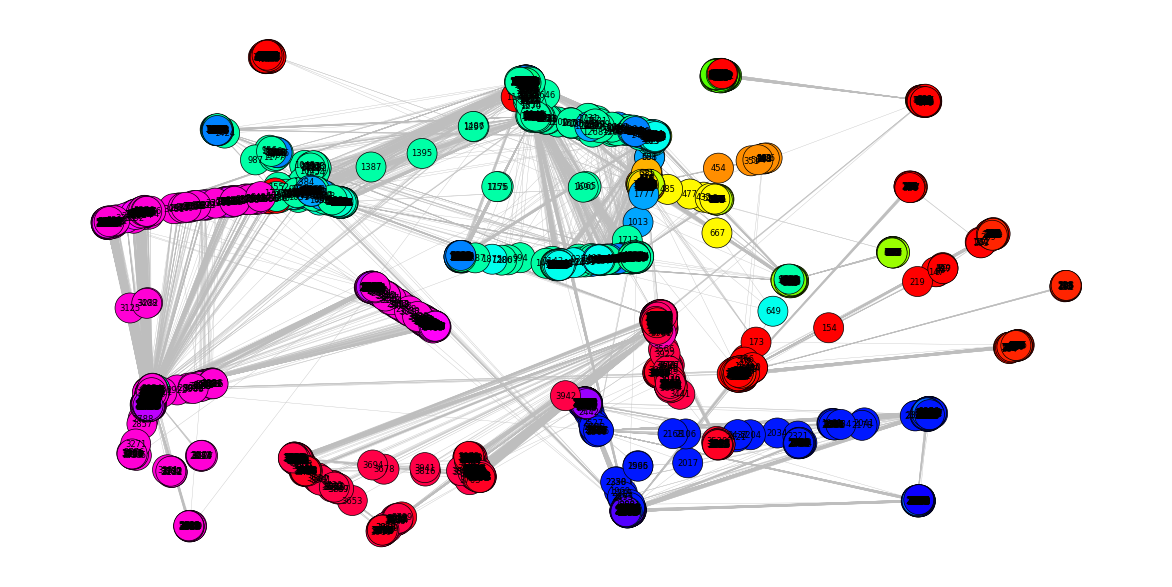

In [70]:
# Plot graph
labels_dict = build_labels_dict(aff_prop.labels_)
add_attributes_and_plot_clustering_graph("aff_prop_label", labels_dict, num_of_clusters)

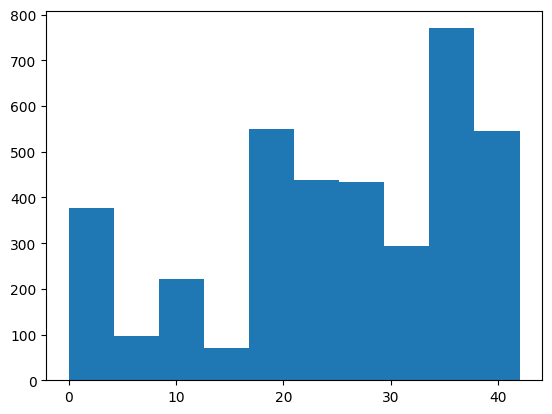

In [71]:
# Histogram of labels show us how many nodes are in each cluster
plt.hist(aff_prop.labels_)
plt.show()

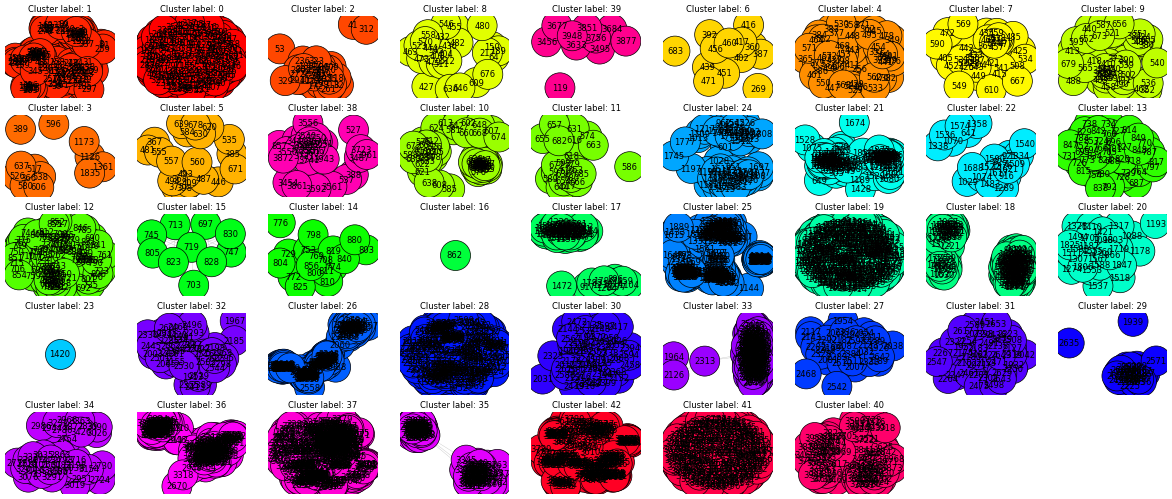

In [72]:
algorithm_name = 'aff_prop'

label_to_vertices_dict = build_label_to_vertices_dict('aff_prop_label')

# Plot subgraphs for the cluster analysis
plot_clustered_subgraphs(num_of_clusters, label_to_vertices_dict, algorithm_name)

## [5] Hierarchical Clustering
---
Advantages of Hierarchical Clustering:
1. It doesn't need number of clusters as an input
2. Hierarchical Clustering results in Dendrogram which is illustration of a tree based on the similarities between nodes
3. Easy to understand mathematics behind the algorithm

Disadvantages of Hierarchical Clustering:
1. Hierarchical clustering is not suitable for large datasets
2. Rarely outputs the best solution
3. It is sensitive to outliers

It is a simple clustering technique, easy to understand. There are 2 methods in this technique viz. Agglomerative and Divisive. We will use Agglomerative technique here which starts from bottom up.

### [i] Hyperparameter Selection/ Tuning

In [73]:
# It has 2 hyperparameters
# 1.linkage_type
# 2. number of clusters (prune the tree to number of clusters)

linkage_types = ["single", "complete", "average", "ward"]
num_of_clusters = np.arange(5, 25, 1)

agg_clustering_silhouette_scores_euclidean =[]
agg_clustering_calinski_harabasz_scores = []
x_labels_for_scores = []
agg_clustering_davies_bouldin_scores = []

for linkage_type in linkage_types:
    for num_of_cluster in num_of_clusters:
        agg_clustering = AgglomerativeClustering(n_clusters=num_of_cluster, linkage=linkage_type)
        agg_clustering.fit(X)
        agg_clustering_silhouette_scores_euclidean.append(silhouette_score(X, agg_clustering.labels_, metric='euclidean'))
        agg_clustering_calinski_harabasz_scores.append(calinski_harabasz_score(X, agg_clustering.labels_))
        agg_clustering_davies_bouldin_scores.append(davies_bouldin_score(X, agg_clustering.labels_))
        x_labels_for_scores.append(linkage_type + "_" + str(num_of_cluster))

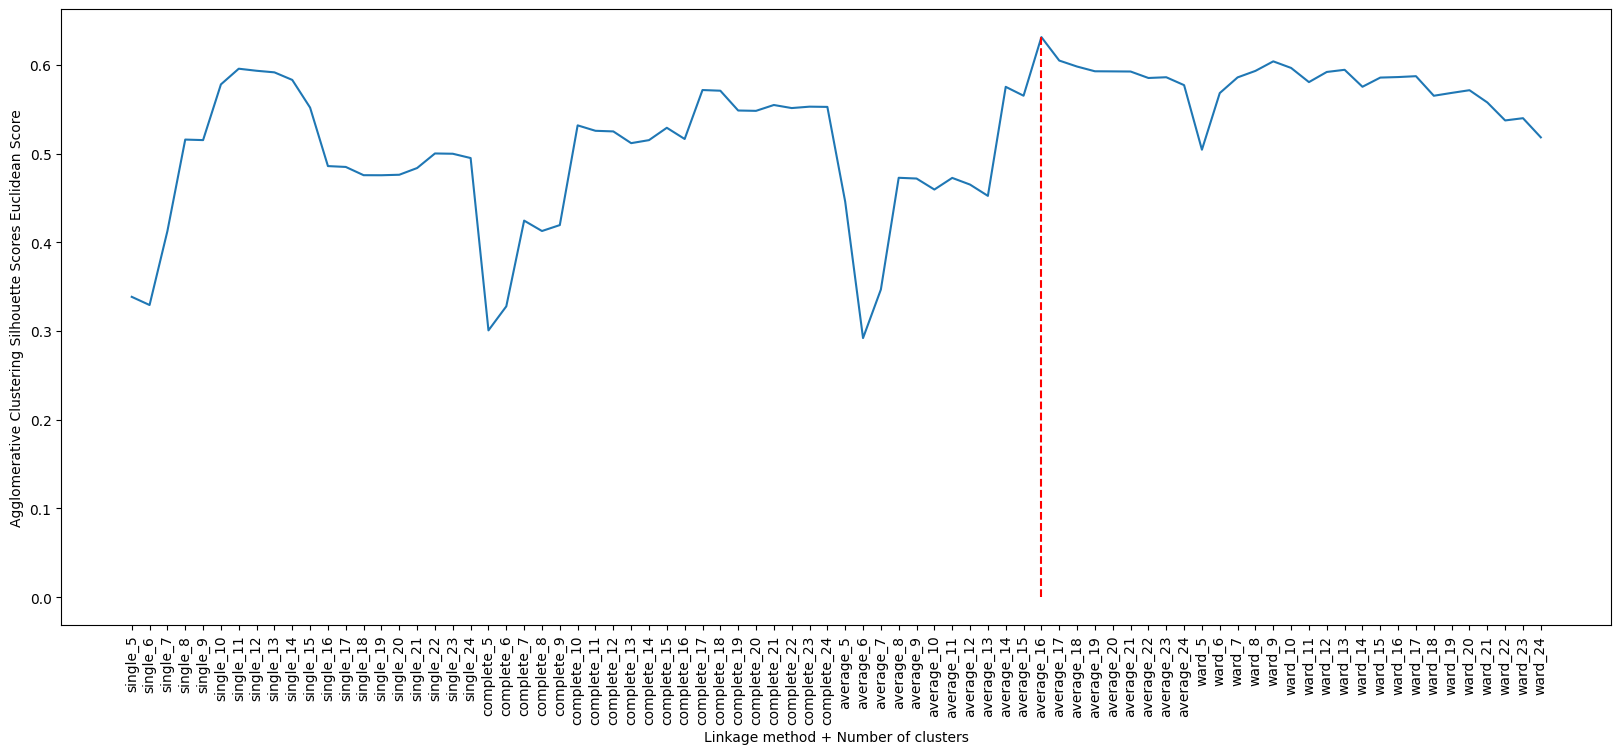

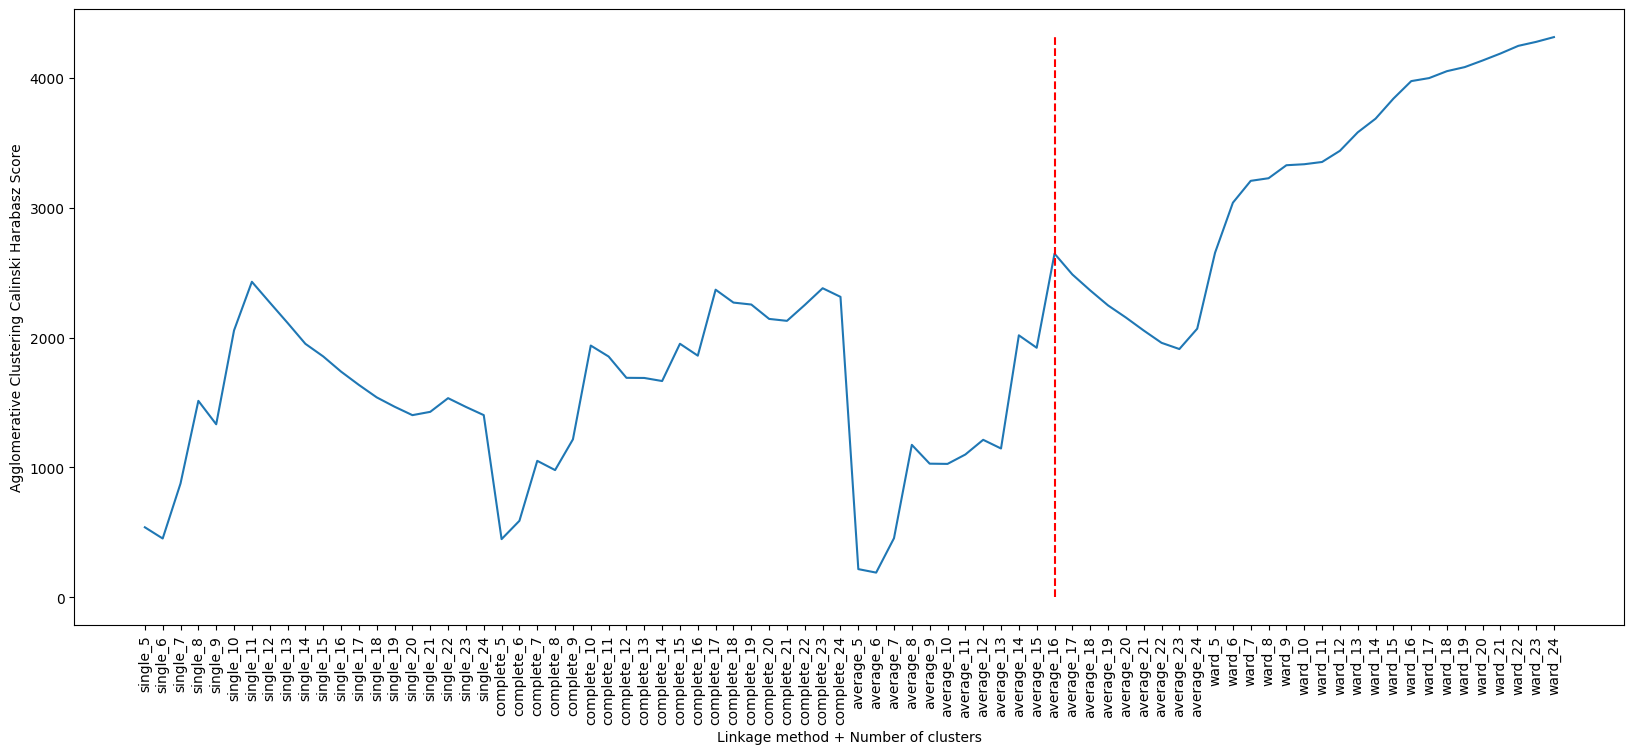

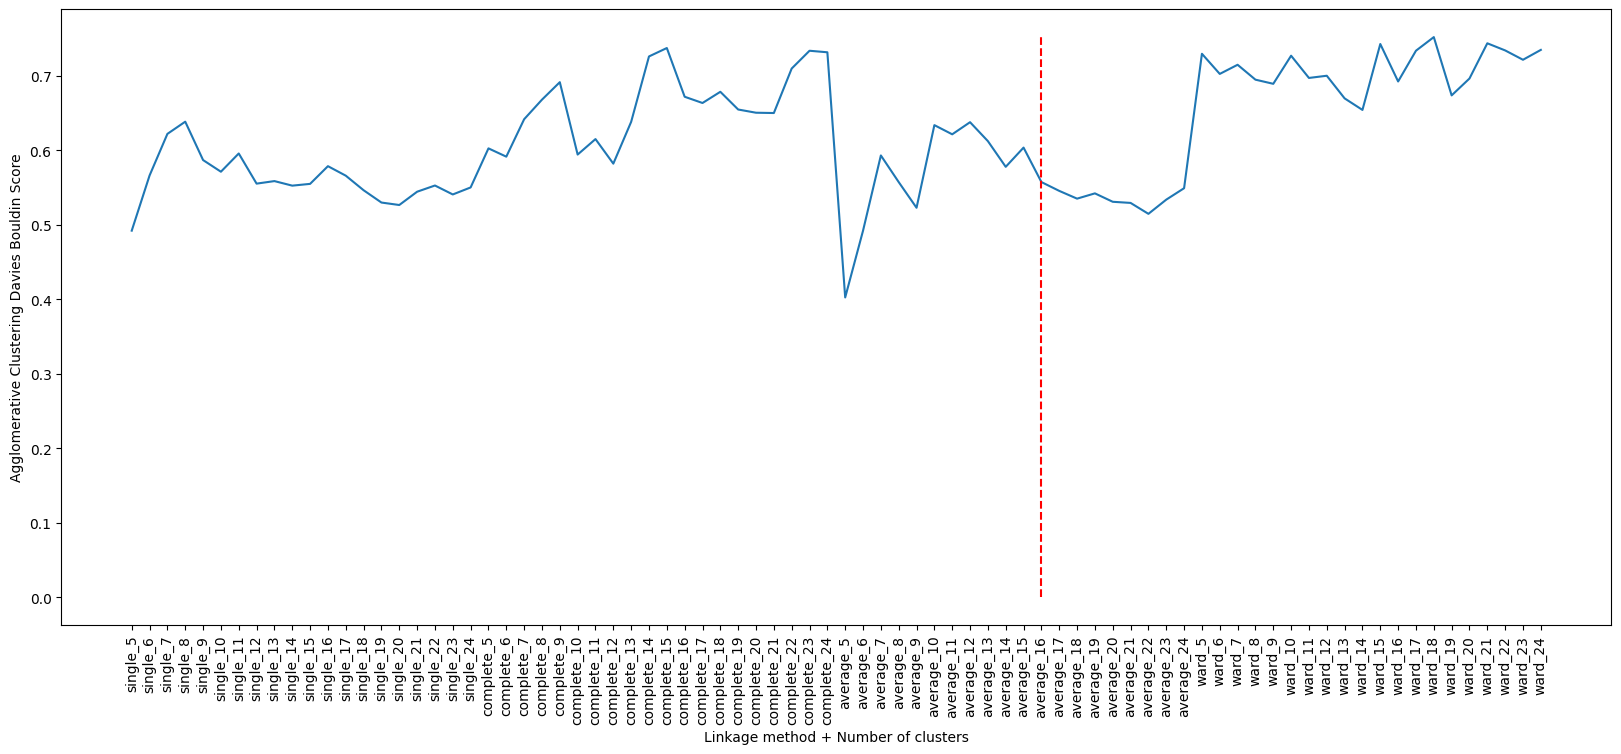

In [74]:
# Plot Silhouette Scores Euclidean
plt.figure(figsize=[20,8],dpi=100)
plt.plot(x_labels_for_scores, agg_clustering_silhouette_scores_euclidean)
plt.ylabel("Agglomerative Clustering Silhouette Scores Euclidean Score")
plt.xlabel("Linkage method + Number of clusters")
plt.xticks(rotation=90)
plt.vlines(x='average_16', ymax=np.array(agg_clustering_silhouette_scores_euclidean).max(), ymin=0, colors="red", linestyles="--")
plt.show()

# Plot Calinski Harabasz Scores
plt.figure(figsize=[20,8],dpi=100)
plt.plot(x_labels_for_scores, agg_clustering_calinski_harabasz_scores)
plt.ylabel("Agglomerative Clustering Calinski Harabasz Score")
plt.xlabel("Linkage method + Number of clusters")
plt.xticks(rotation=90)
plt.vlines(x='average_16', ymax=np.array(agg_clustering_calinski_harabasz_scores).max(), ymin=0, colors="red", linestyles="--")
plt.show()

# Plot Davies Bouldin Scores
plt.figure(figsize=[20,8],dpi=100)
plt.plot(x_labels_for_scores, agg_clustering_davies_bouldin_scores)
plt.ylabel("Agglomerative Clustering Davies Bouldin Score")
plt.xlabel("Linkage method + Number of clusters")
plt.xticks(rotation=90)
plt.vlines(x='average_16', ymax=np.array(agg_clustering_davies_bouldin_scores).max(), ymin=0, colors="red", linestyles="--")
plt.show()


All 3 metrics above are distance based however prioritizing Silhouette score over other scores because unlike Calinski
Harabasz score and Davies Bouldin score it has the upper and lower bound, so overall performance of the clustering can
be accurately gauged.\
Silhouette score = -1 => Incorrect clusters\
Silhouette score = 0 => Overlapping clusters\
Silhouette score = +1 => Highly dense clusters

Selecting number of clusters = 16 and linkage method = average

### [ii] Build clusters with best Hyperparameters

In [75]:
# Agglomerative Clustering with n_clusters=16, linkage='average'
num_of_clusters = 16
linkage_type = 'average'

agg_clustering = AgglomerativeClustering(n_clusters=num_of_clusters, linkage=linkage_type)
agg_clustering.fit(X)

AgglomerativeClustering(linkage='average', n_clusters=16)

### [iii] Evaluation

In [76]:
# Calinski Harabasz Score: (threshold: higher values indicate better clustering)
# For Calinski Harabasz Score, we should choose the num of clusters that give peak of the score or at least the
# elbow on the plot. Lesser value means well separated and dense clusters
agg_clustering_calinski_harabasz_score = calinski_harabasz_score(X, agg_clustering.labels_)
print("Agglomerative Clustering Calinski Harabasz Score: ", agg_clustering_calinski_harabasz_score)
# 2646.8218557961377

# Davies Bouldin Score: (threshold: lower values indicate better clustering)
# For Davies Bouldin Score, we should choose the num of clusters that gives the least value. Lesser value means well
# separated and more compact clusters
agg_clustering_davies_bouldin_score = davies_bouldin_score(X, agg_clustering.labels_)
print("Agglomerative Clustering Davies Bouldin Score: ", agg_clustering_davies_bouldin_score)
# 0.5576064480134977

# Silhouette Score: (threshold: >0.5)
# For Silhouette Score, the value of score should be as close to +1 as possible. Score close to +1 indicates that the
# vertices are well-matched to its own cluster and poorly matched to the neighboring cluster. For Silhouette score we
# are using 2 distance metrics, viz Euclidean distance and Manhattan distance. Euclidean distance is good for when
# features are normally distributed and Manhattan distance is good for discrete features. Since our data is normally
# distributed (single modal and multi-modal) we will prioritize Silhouette score using Euclidean distance over
# Silhouette score using Manhattan distance.
# Note: cosine distance not considered because it is not good for capturing the relative distance. Cosine distance is
# mostly use in NLP use cases when words are related to each other based on angles.

# Silhouette Score Euclidean
agg_clustering_silhouette_score_euclidean = silhouette_score(X, agg_clustering.labels_, metric='euclidean')
print("Agglomerative Clustering Silhouette Euclidean Score: ", agg_clustering_silhouette_score_euclidean)
# 0.6312896147792848

# Silhouette Score Manhattan
agg_clustering_silhouette_score_manhattan = silhouette_score(X, agg_clustering.labels_, metric='manhattan')
print("Agglomerative Clustering Silhouette Manhattan Score: ", agg_clustering_silhouette_score_manhattan)
# 0.6525158133313738

Agglomerative Clustering Calinski Harabasz Score:  2646.8218557961573
Agglomerative Clustering Davies Bouldin Score:  0.5576064528527968
Agglomerative Clustering Silhouette Euclidean Score:  0.6312896147774403
Agglomerative Clustering Silhouette Manhattan Score:  0.65251581333134


### [iv] Visualization

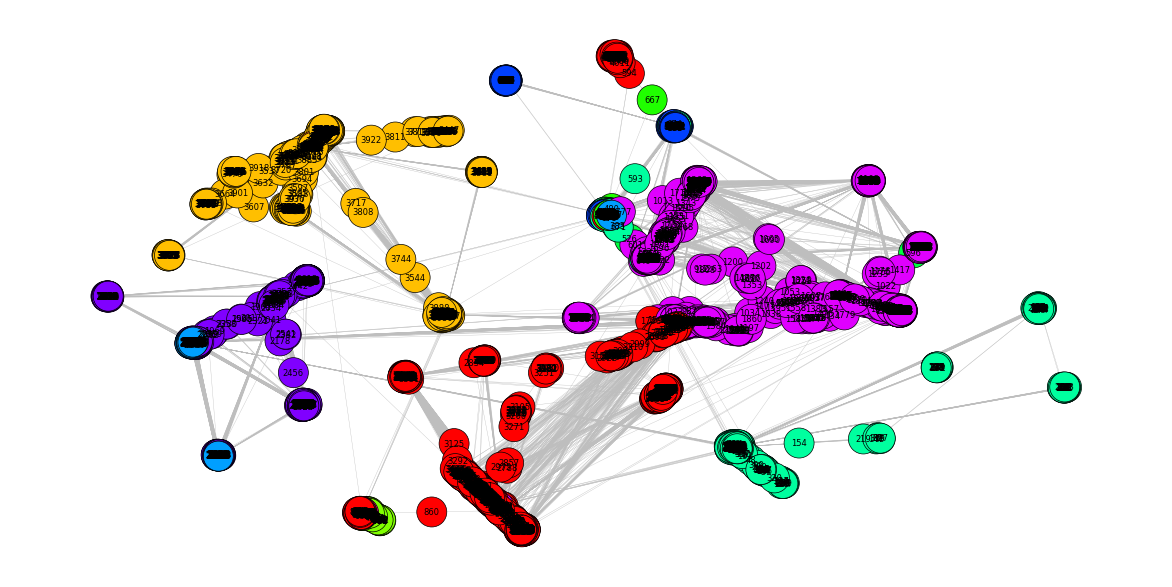

In [77]:
# Plot graph
labels_dict = build_labels_dict(agg_clustering.labels_)
add_attributes_and_plot_clustering_graph("agg_clustering_label", labels_dict, num_of_clusters)

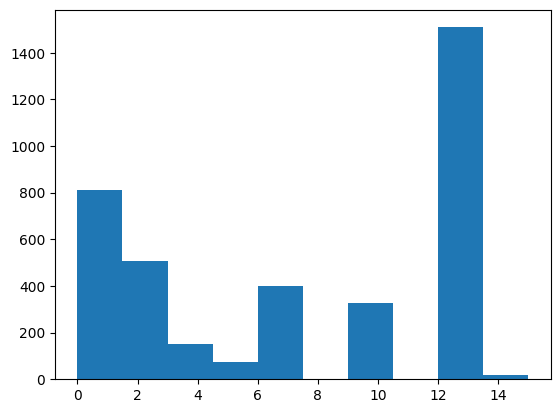

In [78]:
# Histogram of labels show us how many nodes are in each cluster
plt.hist(agg_clustering.labels_)
plt.show()

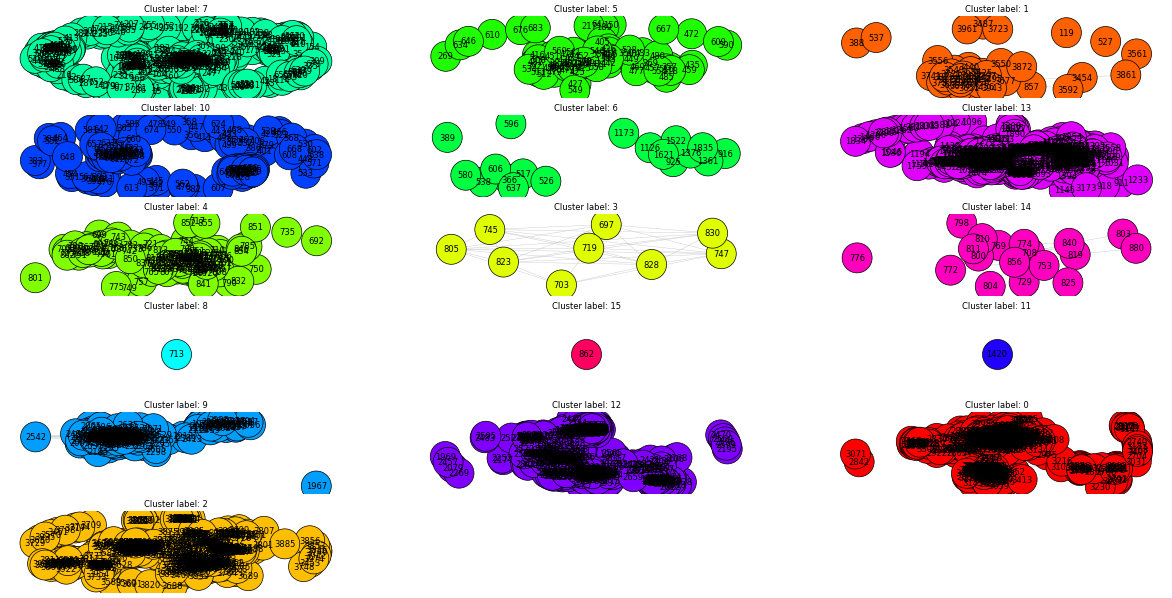

In [79]:
label_to_vertices_dict = build_label_to_vertices_dict('agg_clustering_label')
# Plot subgraphs for the cluster analysis
plot_clustered_subgraphs(num_of_clusters, label_to_vertices_dict, algorithm_name)

# [F] Interpretation and Analysis
---

Below are the Silhouette Euclidean Scores for different algorithms ran above:\
Agglomerative Clustering: 0.6312896147792848\
Affinity Propagation: 0.5124953984281666\
DBScan: 0.5890346476124516\
KMeans: 0.5601172444252062\
Birch: 0.6178413179638821

The clusters built by Agglomerative Clustering seems to have higher Silhouette Euclidean Score than other methods. Hence, using clusters created by Agglomerative Clustering for out interpretation


In [80]:
algorithm_name = 'agg_clustering'

# Create cluster data for cluster analysis
create_cluster_analysis_data(algorithm_name, label_to_vertices_dict)

## [1] Observations
--
Following are the observations based on the clustering results generated by the Agglomerative clustering algorithm. These are generated by the function "create_cluster_analysis_data" invoked in the code block above.

****************agg_clustering vertices in cluster 7****************

Feature name : inside cluster : entire graph : observation

degree : 15.272965879265092 : 41.72229534087918.
 Hence, degree of nodes in this cluster is at least 3 times less than global equivalent

closeness : 0.2632993262750556 : 0.276826146641166.
 Hence, closeness of nodes in this cluster is at least 1 times less than global equivalent

harmonic : 0.2856375122500522 : 0.3074717279751888.
 Hence, harmonic of nodes in this cluster is at least 1 times less than global equivalent

betweenness : 25.996703452678233 : 417.3283067871706.
 Hence, betweenness of nodes in this cluster is at least 16 times less than global equivalent

pagerank : 0.00020739085577513295 : 0.0002316876259804199.
 Hence, pagerank of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_num_of_nodes_2_hops : 340.1417322834646 : 725.8512766517505.
 Hence, num_of_nodes_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_num_of_edges_2_hops : 3189.1522309711286 : 17766.015003948407.
 Hence, num_of_edges_2_hops of nodes in this cluster is at least 6 times less than global equivalent

sub_graph_mean_degree_2_hops : 18.970167288601868 : 44.01423643131059.
 Hence, mean_degree_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_density_2_hops : 0.05736528534274394 : 0.06523851208422043.
 Hence, density_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_closeness_centrality_2_hops : 0.5072671414464525 : 0.511439818800921.
 Hence, mean_closeness_centrality_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality2_hops : 0.5223839150732023 : 0.5277807804927033.
 Hence, mean_harmonic_centrality2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_2_hops : 166.0412744833213 : 350.9702532452559.
 Hence, mean_betweenness_centrality_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_page_rank_2_hops : 0.0029671710608557157 : 0.0018002123935274728.
 Hence, page_rank_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_average_local_clustering_coefficient_2_hops : 0.6745088638679669 : 0.6154412482693045.
 Hence, average_local_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_2_hops : 0.3129581549906716 : 0.42629595602767406.
 Hence, average_global_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_count_motifs_2_hops : 124520.8188976378 : 1277503.157936299.
 Hence, count_motifs_2_hops of nodes in this cluster is at least 10 times less than global equivalent

sub_graph_num_of_nodes_3_hops : 1496.270341207349 : 1708.3295604106345.
 Hence, num_of_nodes_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_num_of_edges_3_hops : 33492.362204724406 : 39450.383785206635.
 Hence, num_of_edges_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_degree_3_hops : 44.812697430458854 : 44.50963191975749.
 Hence, mean_degree_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_density_3_hops : 0.03005743484026893 : 0.03249701318594032.
 Hence, density_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_closeness_centrality_3_hops : 0.4149386522057289 : 0.39593323091058263.
 Hence, mean_closeness_centrality_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_harmonic_centrality3_hops : 0.4389150338543563 : 0.42251001280019684.
 Hence, mean_harmonic_centrality3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_betweenness_centrality_3_hops : 1077.512765845114 : 1452.6068814407151.
 Hence, mean_betweenness_centrality_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_page_rank_3_hops : 0.0006695901307471136 : 0.0008552900199420677.
 Hence, page_rank_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_local_clustering_coefficient_3_hops : 0.6182097715495438 : 0.617899875433266.
 Hence, average_local_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_3_hops : 0.44020941736037145 : 0.4561466826191573.
 Hence, average_global_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_count_motifs_3_hops : 2412167.30183727 : 2747787.0281653064.
 Hence, count_motifs_3_hops of nodes in this cluster is at least 1 times less than global equivalent

===============================================================

****************agg_clustering vertices in cluster 5****************

Feature name : inside cluster : entire graph : observation

degree : 25.342105263157894 : 41.72229534087918.
 Hence, degree of nodes in this cluster is at least 2 times less than global equivalent

closeness : 0.2901752624371978 : 0.276826146641166.
 Hence, closeness of nodes in this cluster is at least 1 times more than global equivalent

harmonic : 0.30858972437285265 : 0.3074717279751888.
 Hence, harmonic of nodes in this cluster is at least 1 times more than global equivalent

betweenness : 688.8566058890583 : 417.3283067871706.
 Hence, betweenness of nodes in this cluster is at least 2 times more than global equivalent

pagerank : 0.00021341404899621053 : 0.0002316876259804199.
 Hence, pagerank of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_num_of_nodes_2_hops : 323.39473684210526 : 725.8512766517505.
 Hence, num_of_nodes_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_num_of_edges_2_hops : 4691.434210526316 : 17766.015003948407.
 Hence, num_of_edges_2_hops of nodes in this cluster is at least 4 times less than global equivalent

sub_graph_mean_degree_2_hops : 28.88087192897591 : 44.01423643131059.
 Hence, mean_degree_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_density_2_hops : 0.0927483741604214 : 0.06523851208422043.
 Hence, density_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_closeness_centrality_2_hops : 0.47912534567431414 : 0.511439818800921.
 Hence, mean_closeness_centrality_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality2_hops : 0.5116803979029768 : 0.5277807804927033.
 Hence, mean_harmonic_centrality2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_2_hops : 182.39295960211848 : 350.9702532452559.
 Hence, mean_betweenness_centrality_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_page_rank_2_hops : 0.003209455435207345 : 0.0018002123935274728.
 Hence, page_rank_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_average_local_clustering_coefficient_2_hops : 0.6384476035766752 : 0.6154412482693045.
 Hence, average_local_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_2_hops : 0.4287523010451929 : 0.42629595602767406.
 Hence, average_global_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_count_motifs_2_hops : 177405.4605263158 : 1277503.157936299.
 Hence, count_motifs_2_hops of nodes in this cluster is at least 7 times less than global equivalent

sub_graph_num_of_nodes_3_hops : 2227.9605263157896 : 1708.3295604106345.
 Hence, num_of_nodes_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_num_of_edges_3_hops : 62081.84210526316 : 39450.383785206635.
 Hence, num_of_edges_3_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_mean_degree_3_hops : 55.90022588991483 : 44.50963191975749.
 Hence, mean_degree_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_density_3_hops : 0.025387746377662355 : 0.03249701318594032.
 Hence, density_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_closeness_centrality_3_hops : 0.34222512997907006 : 0.39593323091058263.
 Hence, mean_closeness_centrality_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality3_hops : 0.3797156146924673 : 0.42251001280019684.
 Hence, mean_harmonic_centrality3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_3_hops : 2190.900947580548 : 1452.6068814407151.
 Hence, mean_betweenness_centrality_3_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_page_rank_3_hops : 0.00045292603591317893 : 0.0008552900199420677.
 Hence, page_rank_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_average_local_clustering_coefficient_3_hops : 0.622473866974849 : 0.617899875433266.
 Hence, average_local_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_3_hops : 0.5427452620471127 : 0.4561466826191573.
 Hence, average_global_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_count_motifs_3_hops : 4652240.828947368 : 2747787.0281653064.
 Hence, count_motifs_3_hops of nodes in this cluster is at least 2 times more than global equivalent

===============================================================

****************agg_clustering vertices in cluster 1****************

Feature name : inside cluster : entire graph : observation

degree : 34.875 : 41.72229534087918.
 Hence, degree of nodes in this cluster is at least 1 times less than global equivalent

closeness : 0.27613063930475457 : 0.276826146641166.
 Hence, closeness of nodes in this cluster is at least 1 times less than global equivalent

harmonic : 0.3028470158494399 : 0.3074717279751888.
 Hence, harmonic of nodes in this cluster is at least 1 times less than global equivalent

betweenness : 5652.383084076964 : 417.3283067871706.
 Hence, betweenness of nodes in this cluster is at least 14 times more than global equivalent

pagerank : 0.0003506544482187275 : 0.0002316876259804199.
 Hence, pagerank of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_num_of_nodes_2_hops : 569.025 : 725.8512766517505.
 Hence, num_of_nodes_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_num_of_edges_2_hops : 5752.375 : 17766.015003948407.
 Hence, num_of_edges_2_hops of nodes in this cluster is at least 3 times less than global equivalent

sub_graph_mean_degree_2_hops : 20.418357498974025 : 44.01423643131059.
 Hence, mean_degree_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_density_2_hops : 0.03680797634848907 : 0.06523851208422043.
 Hence, density_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_mean_closeness_centrality_2_hops : 0.48197813627888814 : 0.511439818800921.
 Hence, mean_closeness_centrality_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality2_hops : 0.49673094924517003 : 0.5277807804927033.
 Hence, mean_harmonic_centrality2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_2_hops : 309.8727412551342 : 350.9702532452559.
 Hence, mean_betweenness_centrality_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_page_rank_2_hops : 0.0017781926861825726 : 0.0018002123935274728.
 Hence, page_rank_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_local_clustering_coefficient_2_hops : 0.6467842819508764 : 0.6154412482693045.
 Hence, average_local_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_2_hops : 0.2815819107448891 : 0.42629595602767406.
 Hence, average_global_clustering_coefficient_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_count_motifs_2_hops : 251195.35 : 1277503.157936299.
 Hence, count_motifs_2_hops of nodes in this cluster is at least 5 times less than global equivalent

sub_graph_num_of_nodes_3_hops : 1645.575 : 1708.3295604106345.
 Hence, num_of_nodes_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_num_of_edges_3_hops : 31863.3 : 39450.383785206635.
 Hence, num_of_edges_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_degree_3_hops : 37.88726707442924 : 44.50963191975749.
 Hence, mean_degree_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_density_3_hops : 0.02300645383679278 : 0.03249701318594032.
 Hence, density_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_closeness_centrality_3_hops : 0.3442501205255403 : 0.39593323091058263.
 Hence, mean_closeness_centrality_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality3_hops : 0.3875735435478223 : 0.42251001280019684.
 Hence, mean_harmonic_centrality3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_3_hops : 1592.4729938161195 : 1452.6068814407151.
 Hence, mean_betweenness_centrality_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_page_rank_3_hops : 0.000626452941019965 : 0.0008552900199420677.
 Hence, page_rank_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_local_clustering_coefficient_3_hops : 0.61558295882222 : 0.617899875433266.
 Hence, average_local_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_global_clustering_coefficient_3_hops : 0.40810952486863783 : 0.4561466826191573.
 Hence, average_global_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_count_motifs_3_hops : 2232574.05 : 2747787.0281653064.
 Hence, count_motifs_3_hops of nodes in this cluster is at least 1 times less than global equivalent

===============================================================

****************agg_clustering vertices in cluster 10****************

Feature name : inside cluster : entire graph : observation

degree : 12.968 : 41.72229534087918.
 Hence, degree of nodes in this cluster is at least 3 times less than global equivalent

closeness : 0.2707142992051937 : 0.276826146641166.
 Hence, closeness of nodes in this cluster is at least 1 times less than global equivalent

harmonic : 0.2844850586098741 : 0.3074717279751888.
 Hence, harmonic of nodes in this cluster is at least 1 times less than global equivalent

betweenness : 11.94134259978482 : 417.3283067871706.
 Hence, betweenness of nodes in this cluster is at least 35 times less than global equivalent

pagerank : 0.0001666228538011554 : 0.0002316876259804199.
 Hence, pagerank of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_num_of_nodes_2_hops : 195.216 : 725.8512766517505.
 Hence, num_of_nodes_2_hops of nodes in this cluster is at least 4 times less than global equivalent

sub_graph_num_of_edges_2_hops : 2622.872 : 17766.015003948407.
 Hence, num_of_edges_2_hops of nodes in this cluster is at least 7 times less than global equivalent

sub_graph_mean_degree_2_hops : 26.31534225929713 : 44.01423643131059.
 Hence, mean_degree_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_density_2_hops : 0.13685108737304705 : 0.06523851208422043.
 Hence, density_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_mean_closeness_centrality_2_hops : 0.5327976247498721 : 0.511439818800921.
 Hence, mean_closeness_centrality_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_harmonic_centrality2_hops : 0.5640228489262803 : 0.5277807804927033.
 Hence, mean_harmonic_centrality2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_betweenness_centrality_2_hops : 86.64473078332603 : 350.9702532452559.
 Hence, mean_betweenness_centrality_2_hops of nodes in this cluster is at least 4 times less than global equivalent

sub_graph_page_rank_2_hops : 0.0052816577376737115 : 0.0018002123935274728.
 Hence, page_rank_2_hops of nodes in this cluster is at least 3 times more than global equivalent

sub_graph_average_local_clustering_coefficient_2_hops : 0.6808398108902487 : 0.6154412482693045.
 Hence, average_local_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_2_hops : 0.5147467758591011 : 0.42629595602767406.
 Hence, average_global_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_count_motifs_2_hops : 79490.632 : 1277503.157936299.
 Hence, count_motifs_2_hops of nodes in this cluster is at least 16 times less than global equivalent

sub_graph_num_of_nodes_3_hops : 1399.632 : 1708.3295604106345.
 Hence, num_of_nodes_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_num_of_edges_3_hops : 32530.384 : 39450.383785206635.
 Hence, num_of_edges_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_degree_3_hops : 46.57796509792841 : 44.50963191975749.
 Hence, mean_degree_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_density_3_hops : 0.03346441133088863 : 0.03249701318594032.
 Hence, density_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_closeness_centrality_3_hops : 0.43099667118252816 : 0.39593323091058263.
 Hence, mean_closeness_centrality_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_harmonic_centrality3_hops : 0.4536799304675586 : 0.42251001280019684.
 Hence, mean_harmonic_centrality3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_betweenness_centrality_3_hops : 947.6502777042548 : 1452.6068814407151.
 Hence, mean_betweenness_centrality_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_page_rank_3_hops : 0.0007167449714864963 : 0.0008552900199420677.
 Hence, page_rank_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_local_clustering_coefficient_3_hops : 0.6006010928376636 : 0.617899875433266.
 Hence, average_local_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_global_clustering_coefficient_3_hops : 0.4281709719125429 : 0.4561466826191573.
 Hence, average_global_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_count_motifs_3_hops : 2413029.272 : 2747787.0281653064.
 Hence, count_motifs_3_hops of nodes in this cluster is at least 1 times less than global equivalent

===============================================================

****************agg_clustering vertices in cluster 6****************

Feature name : inside cluster : entire graph : observation

degree : 124.61111111111111 : 41.72229534087918.
 Hence, degree of nodes in this cluster is at least 3 times more than global equivalent

closeness : 0.3357182682843251 : 0.276826146641166.
 Hence, closeness of nodes in this cluster is at least 1 times more than global equivalent

harmonic : 0.3768222717516894 : 0.3074717279751888.
 Hence, harmonic of nodes in this cluster is at least 1 times more than global equivalent

betweenness : 9985.764563815153 : 417.3283067871706.
 Hence, betweenness of nodes in this cluster is at least 24 times more than global equivalent

pagerank : 0.0005061652584762278 : 0.0002316876259804199.
 Hence, pagerank of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_num_of_nodes_2_hops : 1230.3333333333333 : 725.8512766517505.
 Hence, num_of_nodes_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_num_of_edges_2_hops : 32137.333333333332 : 17766.015003948407.
 Hence, num_of_edges_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_mean_degree_2_hops : 52.36340619490266 : 44.01423643131059.
 Hence, mean_degree_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_density_2_hops : 0.04279469515426326 : 0.06523851208422043.
 Hence, density_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_mean_closeness_centrality_2_hops : 0.461517003647572 : 0.511439818800921.
 Hence, mean_closeness_centrality_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality2_hops : 0.4824285403204514 : 0.5277807804927033.
 Hence, mean_harmonic_centrality2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_2_hops : 734.0516664592062 : 350.9702532452559.
 Hence, mean_betweenness_centrality_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_page_rank_2_hops : 0.0008146949541880278 : 0.0018002123935274728.
 Hence, page_rank_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_average_local_clustering_coefficient_2_hops : 0.5961915526271799 : 0.6154412482693045.
 Hence, average_local_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_global_clustering_coefficient_2_hops : 0.44806460517940383 : 0.42629595602767406.
 Hence, average_global_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_count_motifs_2_hops : 2400720.1666666665 : 1277503.157936299.
 Hence, count_motifs_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_num_of_nodes_3_hops : 3134.1111111111113 : 1708.3295604106345.
 Hence, num_of_nodes_3_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_num_of_edges_3_hops : 74917.0 : 39450.383785206635.
 Hence, num_of_edges_3_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_mean_degree_3_hops : 47.6169272771441 : 44.50963191975749.
 Hence, mean_degree_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_density_3_hops : 0.015226617763843105 : 0.03249701318594032.
 Hence, density_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_mean_closeness_centrality_3_hops : 0.3244124050380337 : 0.39593323091058263.
 Hence, mean_closeness_centrality_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality3_hops : 0.35105487553294734 : 0.42251001280019684.
 Hence, mean_harmonic_centrality3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_3_hops : 3324.3118909916034 : 1452.6068814407151.
 Hence, mean_betweenness_centrality_3_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_page_rank_3_hops : 0.00032108630031348333 : 0.0008552900199420677.
 Hence, page_rank_3_hops of nodes in this cluster is at least 3 times less than global equivalent

sub_graph_average_local_clustering_coefficient_3_hops : 0.608986263617441 : 0.617899875433266.
 Hence, average_local_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_global_clustering_coefficient_3_hops : 0.5052335037616245 : 0.4561466826191573.
 Hence, average_global_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_count_motifs_3_hops : 5264150.666666667 : 2747787.0281653064.
 Hence, count_motifs_3_hops of nodes in this cluster is at least 2 times more than global equivalent

===============================================================

****************agg_clustering vertices in cluster 13****************

Feature name : inside cluster : entire graph : observation

degree : 49.341810783316376 : 41.72229534087918.
 Hence, degree of nodes in this cluster is at least 1 times more than global equivalent

closeness : 0.31853201483529103 : 0.276826146641166.
 Hence, closeness of nodes in this cluster is at least 1 times more than global equivalent

harmonic : 0.3526293027362587 : 0.3074717279751888.
 Hence, harmonic of nodes in this cluster is at least 1 times more than global equivalent

betweenness : 288.8590057776969 : 417.3283067871706.
 Hence, betweenness of nodes in this cluster is at least 1 times less than global equivalent

pagerank : 0.0002310578717140558 : 0.0002316876259804199.
 Hence, pagerank of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_num_of_nodes_2_hops : 1070.8433367243133 : 725.8512766517505.
 Hence, num_of_nodes_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_num_of_edges_2_hops : 28308.81485249237 : 17766.015003948407.
 Hence, num_of_edges_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_mean_degree_2_hops : 52.85042330692595 : 44.01423643131059.
 Hence, mean_degree_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_density_2_hops : 0.04946865792476346 : 0.06523851208422043.
 Hence, density_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_closeness_centrality_2_hops : 0.5050382310098045 : 0.511439818800921.
 Hence, mean_closeness_centrality_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality2_hops : 0.5185199610622624 : 0.5277807804927033.
 Hence, mean_harmonic_centrality2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_2_hops : 529.6595210341621 : 350.9702532452559.
 Hence, mean_betweenness_centrality_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_page_rank_2_hops : 0.000935653788361677 : 0.0018002123935274728.
 Hence, page_rank_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_average_local_clustering_coefficient_2_hops : 0.5837810921458393 : 0.6154412482693045.
 Hence, average_local_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_global_clustering_coefficient_2_hops : 0.43373131014506366 : 0.42629595602767406.
 Hence, average_global_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_count_motifs_2_hops : 2221900.1017294 : 1277503.157936299.
 Hence, count_motifs_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_num_of_nodes_3_hops : 2747.9949135300103 : 1708.3295604106345.
 Hence, num_of_nodes_3_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_num_of_edges_3_hops : 60068.74465920651 : 39450.383785206635.
 Hence, num_of_edges_3_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_mean_degree_3_hops : 43.64055150123377 : 44.50963191975749.
 Hence, mean_degree_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_density_3_hops : 0.015916331065592978 : 0.03249701318594032.
 Hence, density_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_mean_closeness_centrality_3_hops : 0.3412195645306524 : 0.39593323091058263.
 Hence, mean_closeness_centrality_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality3_hops : 0.3656073378827881 : 0.42251001280019684.
 Hence, mean_harmonic_centrality3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_3_hops : 2710.818270902879 : 1452.6068814407151.
 Hence, mean_betweenness_centrality_3_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_page_rank_3_hops : 0.00036513875404033 : 0.0008552900199420677.
 Hence, page_rank_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_average_local_clustering_coefficient_3_hops : 0.6026881096179457 : 0.617899875433266.
 Hence, average_local_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_global_clustering_coefficient_3_hops : 0.45194552655809067 : 0.4561466826191573.
 Hence, average_global_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_count_motifs_3_hops : 4012819.459816887 : 2747787.0281653064.
 Hence, count_motifs_3_hops of nodes in this cluster is at least 1 times more than global equivalent

===============================================================

****************agg_clustering vertices in cluster 4****************

Feature name : inside cluster : entire graph : observation

degree : 17.985915492957748 : 41.72229534087918.
 Hence, degree of nodes in this cluster is at least 2 times less than global equivalent

closeness : 0.17840213487211176 : 0.276826146641166.
 Hence, closeness of nodes in this cluster is at least 2 times less than global equivalent

harmonic : 0.1961908274809676 : 0.3074717279751888.
 Hence, harmonic of nodes in this cluster is at least 2 times less than global equivalent

betweenness : 18.37706064561181 : 417.3283067871706.
 Hence, betweenness of nodes in this cluster is at least 23 times less than global equivalent

pagerank : 0.00021876769764781387 : 0.0002316876259804199.
 Hence, pagerank of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_num_of_nodes_2_hops : 172.74647887323943 : 725.8512766517505.
 Hence, num_of_nodes_2_hops of nodes in this cluster is at least 4 times less than global equivalent

sub_graph_num_of_edges_2_hops : 1843.0352112676057 : 17766.015003948407.
 Hence, num_of_edges_2_hops of nodes in this cluster is at least 10 times less than global equivalent

sub_graph_mean_degree_2_hops : 21.340259720866943 : 44.01423643131059.
 Hence, mean_degree_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_density_2_hops : 0.12430017797387494 : 0.06523851208422043.
 Hence, density_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_mean_closeness_centrality_2_hops : 0.5331920739713547 : 0.511439818800921.
 Hence, mean_closeness_centrality_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_harmonic_centrality2_hops : 0.5602985722651971 : 0.5277807804927033.
 Hence, mean_harmonic_centrality2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_betweenness_centrality_2_hops : 76.18767806604802 : 350.9702532452559.
 Hence, mean_betweenness_centrality_2_hops of nodes in this cluster is at least 5 times less than global equivalent

sub_graph_page_rank_2_hops : 0.005790363012260847 : 0.0018002123935274728.
 Hence, page_rank_2_hops of nodes in this cluster is at least 3 times more than global equivalent

sub_graph_average_local_clustering_coefficient_2_hops : 0.633153544188451 : 0.6154412482693045.
 Hence, average_local_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_2_hops : 0.4111880460611893 : 0.42629595602767406.
 Hence, average_global_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_count_motifs_2_hops : 51566.95070422535 : 1277503.157936299.
 Hence, count_motifs_2_hops of nodes in this cluster is at least 25 times less than global equivalent

sub_graph_num_of_nodes_3_hops : 211.0 : 1708.3295604106345.
 Hence, num_of_nodes_3_hops of nodes in this cluster is at least 8 times less than global equivalent

sub_graph_num_of_edges_3_hops : 1997.0 : 39450.383785206635.
 Hence, num_of_edges_3_hops of nodes in this cluster is at least 20 times less than global equivalent

sub_graph_mean_degree_3_hops : 18.92890995260663 : 44.50963191975749.
 Hence, mean_degree_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_density_3_hops : 0.09013766644098387 : 0.03249701318594032.
 Hence, density_3_hops of nodes in this cluster is at least 3 times more than global equivalent

sub_graph_mean_closeness_centrality_3_hops : 0.4707940990749656 : 0.39593323091058263.
 Hence, mean_closeness_centrality_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_harmonic_centrality3_hops : 0.5042052207928976 : 0.42251001280019684.
 Hence, mean_harmonic_centrality3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_betweenness_centrality_3_hops : 121.27962085308057 : 1452.6068814407151.
 Hence, mean_betweenness_centrality_3_hops of nodes in this cluster is at least 12 times less than global equivalent

sub_graph_page_rank_3_hops : 0.0047393364928908985 : 0.0008552900199420677.
 Hence, page_rank_3_hops of nodes in this cluster is at least 6 times more than global equivalent

sub_graph_average_local_clustering_coefficient_3_hops : 0.6620711651934265 : 0.617899875433266.
 Hence, average_local_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_3_hops : 0.4051493610330973 : 0.4561466826191573.
 Hence, average_global_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_count_motifs_3_hops : 54317.0 : 2747787.0281653064.
 Hence, count_motifs_3_hops of nodes in this cluster is at least 51 times less than global equivalent

===============================================================

****************agg_clustering vertices in cluster 3****************

Feature name : inside cluster : entire graph : observation

degree : 58.77777777777778 : 41.72229534087918.
 Hence, degree of nodes in this cluster is at least 1 times more than global equivalent

closeness : 0.2156219961841619 : 0.276826146641166.
 Hence, closeness of nodes in this cluster is at least 1 times less than global equivalent

harmonic : 0.24202890005267774 : 0.3074717279751888.
 Hence, harmonic of nodes in this cluster is at least 1 times less than global equivalent

betweenness : 22777.173965839604 : 417.3283067871706.
 Hence, betweenness of nodes in this cluster is at least 55 times more than global equivalent

pagerank : 0.0005971600071064888 : 0.0002316876259804199.
 Hence, pagerank of nodes in this cluster is at least 3 times more than global equivalent

sub_graph_num_of_nodes_2_hops : 211.0 : 725.8512766517505.
 Hence, num_of_nodes_2_hops of nodes in this cluster is at least 3 times less than global equivalent

sub_graph_num_of_edges_2_hops : 1997.0 : 17766.015003948407.
 Hence, num_of_edges_2_hops of nodes in this cluster is at least 9 times less than global equivalent

sub_graph_mean_degree_2_hops : 18.928909952606634 : 44.01423643131059.
 Hence, mean_degree_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_density_2_hops : 0.0901376664409839 : 0.06523851208422043.
 Hence, density_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_closeness_centrality_2_hops : 0.4707940990749656 : 0.511439818800921.
 Hence, mean_closeness_centrality_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality2_hops : 0.5042052207928978 : 0.5277807804927033.
 Hence, mean_harmonic_centrality2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_2_hops : 121.27962085308062 : 350.9702532452559.
 Hence, mean_betweenness_centrality_2_hops of nodes in this cluster is at least 3 times less than global equivalent

sub_graph_page_rank_2_hops : 0.0047393364928909 : 0.0018002123935274728.
 Hence, page_rank_2_hops of nodes in this cluster is at least 3 times more than global equivalent

sub_graph_average_local_clustering_coefficient_2_hops : 0.6620711651934266 : 0.6154412482693045.
 Hence, average_local_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_2_hops : 0.4051493610330973 : 0.42629595602767406.
 Hence, average_global_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_count_motifs_2_hops : 54317.0 : 1277503.157936299.
 Hence, count_motifs_2_hops of nodes in this cluster is at least 24 times less than global equivalent

sub_graph_num_of_nodes_3_hops : 756.0 : 1708.3295604106345.
 Hence, num_of_nodes_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_num_of_edges_3_hops : 7352.0 : 39450.383785206635.
 Hence, num_of_edges_3_hops of nodes in this cluster is at least 5 times less than global equivalent

sub_graph_mean_degree_3_hops : 19.44973544973545 : 44.50963191975749.
 Hence, mean_degree_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_density_3_hops : 0.0257612390062721 : 0.03249701318594032.
 Hence, density_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_closeness_centrality_3_hops : 0.3830071833620208 : 0.39593323091058263.
 Hence, mean_closeness_centrality_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality3_hops : 0.4207762477078139 : 0.42251001280019684.
 Hence, mean_harmonic_centrality3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_3_hops : 627.9351851851834 : 1452.6068814407151.
 Hence, mean_betweenness_centrality_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_page_rank_3_hops : 0.0013227513227513 : 0.0008552900199420677.
 Hence, page_rank_3_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_average_local_clustering_coefficient_3_hops : 0.6428940792860335 : 0.617899875433266.
 Hence, average_local_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_3_hops : 0.2873844750573432 : 0.4561466826191573.
 Hence, average_global_clustering_coefficient_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_count_motifs_3_hops : 301339.0 : 2747787.0281653064.
 Hence, count_motifs_3_hops of nodes in this cluster is at least 9 times less than global equivalent

===============================================================

****************agg_clustering vertices in cluster 14****************

Feature name : inside cluster : entire graph : observation

degree : 20.666666666666668 : 41.72229534087918.
 Hence, degree of nodes in this cluster is at least 2 times less than global equivalent

closeness : 0.21514669001127706 : 0.276826146641166.
 Hence, closeness of nodes in this cluster is at least 1 times less than global equivalent

harmonic : 0.23717455338307614 : 0.3074717279751888.
 Hence, harmonic of nodes in this cluster is at least 1 times less than global equivalent

betweenness : 4034.6329003673186 : 417.3283067871706.
 Hence, betweenness of nodes in this cluster is at least 10 times more than global equivalent

pagerank : 0.00026985134648208336 : 0.0002316876259804199.
 Hence, pagerank of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_num_of_nodes_2_hops : 207.72222222222223 : 725.8512766517505.
 Hence, num_of_nodes_2_hops of nodes in this cluster is at least 3 times less than global equivalent

sub_graph_num_of_edges_2_hops : 1976.2777777777778 : 17766.015003948407.
 Hence, num_of_edges_2_hops of nodes in this cluster is at least 9 times less than global equivalent

sub_graph_mean_degree_2_hops : 19.064438347052466 : 44.01423643131059.
 Hence, mean_degree_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_density_2_hops : 0.09299183620553246 : 0.06523851208422043.
 Hence, density_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_closeness_centrality_2_hops : 0.4712068475383858 : 0.511439818800921.
 Hence, mean_closeness_centrality_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality2_hops : 0.5054142216361102 : 0.5277807804927033.
 Hence, mean_harmonic_centrality2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_2_hops : 119.26993431445915 : 350.9702532452559.
 Hence, mean_betweenness_centrality_2_hops of nodes in this cluster is at least 3 times less than global equivalent

sub_graph_page_rank_2_hops : 0.004841537097087017 : 0.0018002123935274728.
 Hence, page_rank_2_hops of nodes in this cluster is at least 3 times more than global equivalent

sub_graph_average_local_clustering_coefficient_2_hops : 0.6631960104195946 : 0.6154412482693045.
 Hence, average_local_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_2_hops : 0.4088504027491506 : 0.42629595602767406.
 Hence, average_global_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_count_motifs_2_hops : 53496.11111111111 : 1277503.157936299.
 Hence, count_motifs_2_hops of nodes in this cluster is at least 24 times less than global equivalent

sub_graph_num_of_nodes_3_hops : 756.0 : 1708.3295604106345.
 Hence, num_of_nodes_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_num_of_edges_3_hops : 7352.0 : 39450.383785206635.
 Hence, num_of_edges_3_hops of nodes in this cluster is at least 5 times less than global equivalent

sub_graph_mean_degree_3_hops : 19.44973544973545 : 44.50963191975749.
 Hence, mean_degree_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_density_3_hops : 0.0257612390062721 : 0.03249701318594032.
 Hence, density_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_closeness_centrality_3_hops : 0.3830071833620208 : 0.39593323091058263.
 Hence, mean_closeness_centrality_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality3_hops : 0.42077624770781397 : 0.42251001280019684.
 Hence, mean_harmonic_centrality3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_3_hops : 627.9351851851833 : 1452.6068814407151.
 Hence, mean_betweenness_centrality_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_page_rank_3_hops : 0.0013227513227512997 : 0.0008552900199420677.
 Hence, page_rank_3_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_average_local_clustering_coefficient_3_hops : 0.6428940792860335 : 0.617899875433266.
 Hence, average_local_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_3_hops : 0.2873844750573432 : 0.4561466826191573.
 Hence, average_global_clustering_coefficient_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_count_motifs_3_hops : 301339.0 : 2747787.0281653064.
 Hence, count_motifs_3_hops of nodes in this cluster is at least 9 times less than global equivalent

===============================================================

****************agg_clustering vertices in cluster 8****************

Feature name : inside cluster : entire graph : observation

degree : 71.0 : 41.72229534087918.
 Hence, degree of nodes in this cluster is at least 2 times more than global equivalent

closeness : 0.2157627571466737 : 0.276826146641166.
 Hence, closeness of nodes in this cluster is at least 1 times less than global equivalent

harmonic : 0.2435423005259592 : 0.3074717279751888.
 Hence, harmonic of nodes in this cluster is at least 1 times less than global equivalent

betweenness : 40868.72821033046 : 417.3283067871706.
 Hence, betweenness of nodes in this cluster is at least 98 times more than global equivalent

pagerank : 0.0007525291207879 : 0.0002316876259804199.
 Hence, pagerank of nodes in this cluster is at least 3 times more than global equivalent

sub_graph_num_of_nodes_2_hops : 211.0 : 725.8512766517505.
 Hence, num_of_nodes_2_hops of nodes in this cluster is at least 3 times less than global equivalent

sub_graph_num_of_edges_2_hops : 1997.0 : 17766.015003948407.
 Hence, num_of_edges_2_hops of nodes in this cluster is at least 9 times less than global equivalent

sub_graph_mean_degree_2_hops : 18.928909952606634 : 44.01423643131059.
 Hence, mean_degree_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_density_2_hops : 0.0901376664409839 : 0.06523851208422043.
 Hence, density_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_closeness_centrality_2_hops : 0.4707940990749656 : 0.511439818800921.
 Hence, mean_closeness_centrality_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality2_hops : 0.5042052207928978 : 0.5277807804927033.
 Hence, mean_harmonic_centrality2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_2_hops : 121.2796208530806 : 350.9702532452559.
 Hence, mean_betweenness_centrality_2_hops of nodes in this cluster is at least 3 times less than global equivalent

sub_graph_page_rank_2_hops : 0.0047393364928909 : 0.0018002123935274728.
 Hence, page_rank_2_hops of nodes in this cluster is at least 3 times more than global equivalent

sub_graph_average_local_clustering_coefficient_2_hops : 0.6620711651934266 : 0.6154412482693045.
 Hence, average_local_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_2_hops : 0.4051493610330973 : 0.42629595602767406.
 Hence, average_global_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_count_motifs_2_hops : 54317.0 : 1277503.157936299.
 Hence, count_motifs_2_hops of nodes in this cluster is at least 24 times less than global equivalent

sub_graph_num_of_nodes_3_hops : 756.0 : 1708.3295604106345.
 Hence, num_of_nodes_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_num_of_edges_3_hops : 7352.0 : 39450.383785206635.
 Hence, num_of_edges_3_hops of nodes in this cluster is at least 5 times less than global equivalent

sub_graph_mean_degree_3_hops : 19.44973544973545 : 44.50963191975749.
 Hence, mean_degree_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_density_3_hops : 0.0257612390062721 : 0.03249701318594032.
 Hence, density_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_closeness_centrality_3_hops : 0.3830071833620208 : 0.39593323091058263.
 Hence, mean_closeness_centrality_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality3_hops : 0.4207762477078139 : 0.42251001280019684.
 Hence, mean_harmonic_centrality3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_3_hops : 627.9351851851834 : 1452.6068814407151.
 Hence, mean_betweenness_centrality_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_page_rank_3_hops : 0.0013227513227513 : 0.0008552900199420677.
 Hence, page_rank_3_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_average_local_clustering_coefficient_3_hops : 0.6428940792860335 : 0.617899875433266.
 Hence, average_local_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_3_hops : 0.2873844750573432 : 0.4561466826191573.
 Hence, average_global_clustering_coefficient_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_count_motifs_3_hops : 301339.0 : 2747787.0281653064.
 Hence, count_motifs_3_hops of nodes in this cluster is at least 9 times less than global equivalent

===============================================================

****************agg_clustering vertices in cluster 15****************

Feature name : inside cluster : entire graph : observation

degree : 24.0 : 41.72229534087918.
 Hence, degree of nodes in this cluster is at least 2 times less than global equivalent

closeness : 0.2818257956448911 : 0.276826146641166.
 Hence, closeness of nodes in this cluster is at least 1 times more than global equivalent

harmonic : 0.3093363051015467 : 0.3074717279751888.
 Hence, harmonic of nodes in this cluster is at least 1 times more than global equivalent

betweenness : 95752.64747294111 : 417.3283067871706.
 Hence, betweenness of nodes in this cluster is at least 229 times more than global equivalent

pagerank : 0.0002958623973448 : 0.0002316876259804199.
 Hence, pagerank of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_num_of_nodes_2_hops : 646.0 : 725.8512766517505.
 Hence, num_of_nodes_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_num_of_edges_2_hops : 5992.0 : 17766.015003948407.
 Hence, num_of_edges_2_hops of nodes in this cluster is at least 3 times less than global equivalent

sub_graph_mean_degree_2_hops : 18.55108359133127 : 44.01423643131059.
 Hence, mean_degree_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_density_2_hops : 0.0287613699090407 : 0.06523851208422043.
 Hence, density_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_mean_closeness_centrality_2_hops : 0.4525907724191687 : 0.511439818800921.
 Hence, mean_closeness_centrality_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality2_hops : 0.4700126398988787 : 0.5277807804927033.
 Hence, mean_harmonic_centrality2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_2_hops : 400.6857585139318 : 350.9702532452559.
 Hence, mean_betweenness_centrality_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_page_rank_2_hops : 0.001547987616099 : 0.0018002123935274728.
 Hence, page_rank_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_local_clustering_coefficient_2_hops : 0.660279042369964 : 0.6154412482693045.
 Hence, average_local_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_2_hops : 0.2690861044672479 : 0.42629595602767406.
 Hence, average_global_clustering_coefficient_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_count_motifs_2_hops : 255262.0 : 1277503.157936299.
 Hence, count_motifs_2_hops of nodes in this cluster is at least 5 times less than global equivalent

sub_graph_num_of_nodes_3_hops : 1844.0 : 1708.3295604106345.
 Hence, num_of_nodes_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_num_of_edges_3_hops : 36097.0 : 39450.383785206635.
 Hence, num_of_edges_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_degree_3_hops : 39.15075921908894 : 44.50963191975749.
 Hence, mean_degree_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_density_3_hops : 0.0212429512854524 : 0.03249701318594032.
 Hence, density_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_mean_closeness_centrality_3_hops : 0.3152193425422431 : 0.39593323091058263.
 Hence, mean_closeness_centrality_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality3_hops : 0.3659834224512919 : 0.42251001280019684.
 Hence, mean_harmonic_centrality3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_3_hops : 2064.486984815616 : 1452.6068814407151.
 Hence, mean_betweenness_centrality_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_page_rank_3_hops : 0.0005422993492407 : 0.0008552900199420677.
 Hence, page_rank_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_average_local_clustering_coefficient_3_hops : 0.6092682114776491 : 0.617899875433266.
 Hence, average_local_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_global_clustering_coefficient_3_hops : 0.417821539110502 : 0.4561466826191573.
 Hence, average_global_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_count_motifs_3_hops : 2544936.0 : 2747787.0281653064.
 Hence, count_motifs_3_hops of nodes in this cluster is at least 1 times less than global equivalent

===============================================================

****************agg_clustering vertices in cluster 11****************

Feature name : inside cluster : entire graph : observation

degree : 148.0 : 41.72229534087918.
 Hence, degree of nodes in this cluster is at least 4 times more than global equivalent

closeness : 0.3387015601409159 : 0.276826146641166.
 Hence, closeness of nodes in this cluster is at least 1 times more than global equivalent

harmonic : 0.3764404820868387 : 0.3074717279751888.
 Hence, harmonic of nodes in this cluster is at least 1 times more than global equivalent

betweenness : 49365.38493924598 : 417.3283067871706.
 Hence, betweenness of nodes in this cluster is at least 118 times more than global equivalent

pagerank : 0.0004497194273823 : 0.0002316876259804199.
 Hence, pagerank of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_num_of_nodes_2_hops : 1079.0 : 725.8512766517505.
 Hence, num_of_nodes_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_num_of_edges_2_hops : 28113.0 : 17766.015003948407.
 Hence, num_of_edges_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_mean_degree_2_hops : 52.10936051899908 : 44.01423643131059.
 Hence, mean_degree_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_density_2_hops : 0.0483389244146559 : 0.06523851208422043.
 Hence, density_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_closeness_centrality_2_hops : 0.500450924885746 : 0.511439818800921.
 Hence, mean_closeness_centrality_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality2_hops : 0.5145989982478806 : 0.5277807804927033.
 Hence, mean_harmonic_centrality2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_2_hops : 543.8962001853569 : 350.9702532452559.
 Hence, mean_betweenness_centrality_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_page_rank_2_hops : 0.0009267840593141 : 0.0018002123935274728.
 Hence, page_rank_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_average_local_clustering_coefficient_2_hops : 0.5879623932999626 : 0.6154412482693045.
 Hence, average_local_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_global_clustering_coefficient_2_hops : 0.4333322923806448 : 0.42629595602767406.
 Hence, average_global_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_count_motifs_2_hops : 2208805.0 : 1277503.157936299.
 Hence, count_motifs_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_num_of_nodes_3_hops : 3202.0 : 1708.3295604106345.
 Hence, num_of_nodes_3_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_num_of_edges_3_hops : 63110.0 : 39450.383785206635.
 Hence, num_of_edges_3_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_mean_degree_3_hops : 39.41911305434104 : 44.50963191975749.
 Hence, mean_degree_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_density_3_hops : 0.0123146245093224 : 0.03249701318594032.
 Hence, density_3_hops of nodes in this cluster is at least 3 times less than global equivalent

sub_graph_mean_closeness_centrality_3_hops : 0.306924631684335 : 0.39593323091058263.
 Hence, mean_closeness_centrality_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality3_hops : 0.3354575556527404 : 0.42251001280019684.
 Hence, mean_harmonic_centrality3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_3_hops : 3703.009681449111 : 1452.6068814407151.
 Hence, mean_betweenness_centrality_3_hops of nodes in this cluster is at least 3 times more than global equivalent

sub_graph_page_rank_3_hops : 0.000312304809494 : 0.0008552900199420677.
 Hence, page_rank_3_hops of nodes in this cluster is at least 3 times less than global equivalent

sub_graph_average_local_clustering_coefficient_3_hops : 0.6058998650545432 : 0.617899875433266.
 Hence, average_local_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_global_clustering_coefficient_3_hops : 0.4352800771935072 : 0.4561466826191573.
 Hence, average_global_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_count_motifs_3_hops : 4090781.0 : 2747787.0281653064.
 Hence, count_motifs_3_hops of nodes in this cluster is at least 1 times more than global equivalent

===============================================================

****************agg_clustering vertices in cluster 9****************

Feature name : inside cluster : entire graph : observation

degree : 92.0049504950495 : 41.72229534087918.
 Hence, degree of nodes in this cluster is at least 2 times more than global equivalent

closeness : 0.2804721699563563 : 0.276826146641166.
 Hence, closeness of nodes in this cluster is at least 1 times more than global equivalent

harmonic : 0.32297860331566347 : 0.3074717279751888.
 Hence, harmonic of nodes in this cluster is at least 1 times more than global equivalent

betweenness : 1265.627940412869 : 417.3283067871706.
 Hence, betweenness of nodes in this cluster is at least 3 times more than global equivalent

pagerank : 0.0003088841838423052 : 0.0002316876259804199.
 Hence, pagerank of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_num_of_nodes_2_hops : 800.2623762376238 : 725.8512766517505.
 Hence, num_of_nodes_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_num_of_edges_2_hops : 31096.247524752474 : 17766.015003948407.
 Hence, num_of_edges_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_mean_degree_2_hops : 77.77800375267672 : 44.01423643131059.
 Hence, mean_degree_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_density_2_hops : 0.09749191539499666 : 0.06523851208422043.
 Hence, density_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_closeness_centrality_2_hops : 0.5077027023471284 : 0.511439818800921.
 Hence, mean_closeness_centrality_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality2_hops : 0.534477031659258 : 0.5277807804927033.
 Hence, mean_harmonic_centrality2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_betweenness_centrality_2_hops : 395.56400627550386 : 350.9702532452559.
 Hence, mean_betweenness_centrality_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_page_rank_2_hops : 0.0012508833549066307 : 0.0018002123935274728.
 Hence, page_rank_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_local_clustering_coefficient_2_hops : 0.6689108646742713 : 0.6154412482693045.
 Hence, average_local_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_2_hops : 0.6635170978299436 : 0.42629595602767406.
 Hence, average_global_clustering_coefficient_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_count_motifs_2_hops : 2388475.9851485146 : 1277503.157936299.
 Hence, count_motifs_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_num_of_nodes_3_hops : 1971.539603960396 : 1708.3295604106345.
 Hence, num_of_nodes_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_num_of_edges_3_hops : 58084.08910891089 : 39450.383785206635.
 Hence, num_of_edges_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_degree_3_hops : 58.92159499886902 : 44.50963191975749.
 Hence, mean_degree_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_density_3_hops : 0.030865355829414153 : 0.03249701318594032.
 Hence, density_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_closeness_centrality_3_hops : 0.35363531077109583 : 0.39593323091058263.
 Hence, mean_closeness_centrality_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality3_hops : 0.3930036573464856 : 0.42251001280019684.
 Hence, mean_harmonic_centrality3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_3_hops : 1830.4068332730126 : 1452.6068814407151.
 Hence, mean_betweenness_centrality_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_page_rank_3_hops : 0.0005245184369184173 : 0.0008552900199420677.
 Hence, page_rank_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_average_local_clustering_coefficient_3_hops : 0.6316599435974396 : 0.617899875433266.
 Hence, average_local_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_3_hops : 0.5755314618042552 : 0.4561466826191573.
 Hence, average_global_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_count_motifs_3_hops : 4393097.846534654 : 2747787.0281653064.
 Hence, count_motifs_3_hops of nodes in this cluster is at least 2 times more than global equivalent

===============================================================

****************agg_clustering vertices in cluster 12****************

Feature name : inside cluster : entire graph : observation

degree : 71.04562737642586 : 41.72229534087918.
 Hence, degree of nodes in this cluster is at least 2 times more than global equivalent

closeness : 0.26097627966374315 : 0.276826146641166.
 Hence, closeness of nodes in this cluster is at least 1 times less than global equivalent

harmonic : 0.2981819039063772 : 0.3074717279751888.
 Hence, harmonic of nodes in this cluster is at least 1 times less than global equivalent

betweenness : 40.86336243599011 : 417.3283067871706.
 Hence, betweenness of nodes in this cluster is at least 10 times less than global equivalent

pagerank : 0.0002106654804486906 : 0.0002316876259804199.
 Hence, pagerank of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_num_of_nodes_2_hops : 756.0 : 725.8512766517505.
 Hence, num_of_nodes_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_num_of_edges_2_hops : 30780.0 : 17766.015003948407.
 Hence, num_of_edges_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_mean_degree_2_hops : 81.42857142857142 : 44.01423643131059.
 Hence, mean_degree_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_density_2_hops : 0.10785241248817397 : 0.06523851208422043.
 Hence, density_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_mean_closeness_centrality_2_hops : 0.5298986661063474 : 0.511439818800921.
 Hence, mean_closeness_centrality_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_harmonic_centrality2_hops : 0.5539262062440872 : 0.5277807804927033.
 Hence, mean_harmonic_centrality2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_betweenness_centrality_2_hops : 336.7857142857141 : 350.9702532452559.
 Hence, mean_betweenness_centrality_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_page_rank_2_hops : 0.0013227513227512997 : 0.0018002123935274728.
 Hence, page_rank_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_local_clustering_coefficient_2_hops : 0.6694776088812125 : 0.6154412482693045.
 Hence, average_local_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_2_hops : 0.6646208433776967 : 0.42629595602767406.
 Hence, average_global_clustering_coefficient_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_count_motifs_2_hops : 2378863.0 : 1277503.157936299.
 Hence, count_motifs_2_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_num_of_nodes_3_hops : 1003.0 : 1708.3295604106345.
 Hence, num_of_nodes_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_num_of_edges_3_hops : 33999.0 : 39450.383785206635.
 Hence, num_of_edges_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_degree_3_hops : 67.79461615154537 : 44.50963191975749.
 Hence, mean_degree_3_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_density_3_hops : 0.0676592975564325 : 0.03249701318594032.
 Hence, density_3_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_mean_closeness_centrality_3_hops : 0.4383095883057117 : 0.39593323091058263.
 Hence, mean_closeness_centrality_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_harmonic_centrality3_hops : 0.4703457823469019 : 0.42251001280019684.
 Hence, mean_harmonic_centrality3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_betweenness_centrality_3_hops : 659.4426719840478 : 1452.6068814407151.
 Hence, mean_betweenness_centrality_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_page_rank_3_hops : 0.0009970089730807 : 0.0008552900199420677.
 Hence, page_rank_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_local_clustering_coefficient_3_hops : 0.6622152436379689 : 0.617899875433266.
 Hence, average_local_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_3_hops : 0.6580031254561728 : 0.4561466826191573.
 Hence, average_global_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_count_motifs_3_hops : 2480273.0 : 2747787.0281653064.
 Hence, count_motifs_3_hops of nodes in this cluster is at least 1 times less than global equivalent

===============================================================

****************agg_clustering vertices in cluster 0****************

Feature name : inside cluster : entire graph : observation

degree : 37.07532467532467 : 41.72229534087918.
 Hence, degree of nodes in this cluster is at least 1 times less than global equivalent

closeness : 0.283342943091983 : 0.276826146641166.
 Hence, closeness of nodes in this cluster is at least 1 times more than global equivalent

harmonic : 0.31600689017109446 : 0.3074717279751888.
 Hence, harmonic of nodes in this cluster is at least 1 times more than global equivalent

betweenness : 100.42712353791364 : 417.3283067871706.
 Hence, betweenness of nodes in this cluster is at least 4 times less than global equivalent

pagerank : 0.00023986246264306058 : 0.0002316876259804199.
 Hence, pagerank of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_num_of_nodes_2_hops : 795.6818181818181 : 725.8512766517505.
 Hence, num_of_nodes_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_num_of_edges_2_hops : 14834.028571428571 : 17766.015003948407.
 Hence, num_of_edges_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_degree_2_hops : 37.289288015593876 : 44.01423643131059.
 Hence, mean_degree_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_density_2_hops : 0.04693285226119507 : 0.06523851208422043.
 Hence, density_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_closeness_centrality_2_hops : 0.5112101477224822 : 0.511439818800921.
 Hence, mean_closeness_centrality_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality2_hops : 0.5224760703791755 : 0.5277807804927033.
 Hence, mean_harmonic_centrality2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_2_hops : 381.1450047651727 : 350.9702532452559.
 Hence, mean_betweenness_centrality_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_page_rank_2_hops : 0.0012569369039347224 : 0.0018002123935274728.
 Hence, page_rank_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_local_clustering_coefficient_2_hops : 0.5412580454698387 : 0.6154412482693045.
 Hence, average_local_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_global_clustering_coefficient_2_hops : 0.3544553625218406 : 0.42629595602767406.
 Hence, average_global_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_count_motifs_2_hops : 876585.5831168831 : 1277503.157936299.
 Hence, count_motifs_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_num_of_nodes_3_hops : 1836.8142857142857 : 1708.3295604106345.
 Hence, num_of_nodes_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_num_of_edges_3_hops : 42814.12077922078 : 39450.383785206635.
 Hence, num_of_edges_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_degree_3_hops : 46.611207956269155 : 44.50963191975749.
 Hence, mean_degree_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_density_3_hops : 0.025393484544639727 : 0.03249701318594032.
 Hence, density_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_closeness_centrality_3_hops : 0.4065252464953322 : 0.39593323091058263.
 Hence, mean_closeness_centrality_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_harmonic_centrality3_hops : 0.4312150950770873 : 0.42251001280019684.
 Hence, mean_harmonic_centrality3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_betweenness_centrality_3_hops : 1345.0393513454605 : 1452.6068814407151.
 Hence, mean_betweenness_centrality_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_page_rank_3_hops : 0.000544570270447798 : 0.0008552900199420677.
 Hence, page_rank_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_average_local_clustering_coefficient_3_hops : 0.5651079264215421 : 0.617899875433266.
 Hence, average_local_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_average_global_clustering_coefficient_3_hops : 0.412685551439028 : 0.4561466826191573.
 Hence, average_global_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_count_motifs_3_hops : 3094938.57012987 : 2747787.0281653064.
 Hence, count_motifs_3_hops of nodes in this cluster is at least 1 times more than global equivalent

===============================================================

****************agg_clustering vertices in cluster 2****************

Feature name : inside cluster : entire graph : observation

degree : 17.381422924901187 : 41.72229534087918.
 Hence, degree of nodes in this cluster is at least 2 times less than global equivalent

closeness : 0.23945090154732307 : 0.276826146641166.
 Hence, closeness of nodes in this cluster is at least 1 times less than global equivalent

harmonic : 0.26495253262649926 : 0.3074717279751888.
 Hence, harmonic of nodes in this cluster is at least 1 times less than global equivalent

betweenness : 22.130665104615158 : 417.3283067871706.
 Hence, betweenness of nodes in this cluster is at least 19 times less than global equivalent

pagerank : 0.0002236311812741918 : 0.0002316876259804199.
 Hence, pagerank of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_num_of_nodes_2_hops : 548.0256916996047 : 725.8512766517505.
 Hence, num_of_nodes_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_num_of_edges_2_hops : 5360.081027667984 : 17766.015003948407.
 Hence, num_of_edges_2_hops of nodes in this cluster is at least 3 times less than global equivalent

sub_graph_mean_degree_2_hops : 19.561425451934646 : 44.01423643131059.
 Hence, mean_degree_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_density_2_hops : 0.03575962376556106 : 0.06523851208422043.
 Hence, density_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_mean_closeness_centrality_2_hops : 0.5096213642868014 : 0.511439818800921.
 Hence, mean_closeness_centrality_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_harmonic_centrality2_hops : 0.517864896252946 : 0.5277807804927033.
 Hence, mean_harmonic_centrality2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_betweenness_centrality_2_hops : 263.75673019459083 : 350.9702532452559.
 Hence, mean_betweenness_centrality_2_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_page_rank_2_hops : 0.001824732384143607 : 0.0018002123935274728.
 Hence, page_rank_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_local_clustering_coefficient_2_hops : 0.638811465427246 : 0.6154412482693045.
 Hence, average_local_clustering_coefficient_2_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_2_hops : 0.2580886808750127 : 0.42629595602767406.
 Hence, average_global_clustering_coefficient_2_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_count_motifs_2_hops : 246969.73122529645 : 1277503.157936299.
 Hence, count_motifs_2_hops of nodes in this cluster is at least 5 times less than global equivalent

sub_graph_num_of_nodes_3_hops : 703.0 : 1708.3295604106345.
 Hence, num_of_nodes_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_num_of_edges_3_hops : 6886.0 : 39450.383785206635.
 Hence, num_of_edges_3_hops of nodes in this cluster is at least 6 times less than global equivalent

sub_graph_mean_degree_3_hops : 19.590327169274534 : 44.50963191975749.
 Hence, mean_degree_3_hops of nodes in this cluster is at least 2 times less than global equivalent

sub_graph_density_3_hops : 0.02790644895908051 : 0.03249701318594032.
 Hence, density_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_mean_closeness_centrality_3_hops : 0.43070759034462075 : 0.39593323091058263.
 Hence, mean_closeness_centrality_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_harmonic_centrality3_hops : 0.450992152746536 : 0.42251001280019684.
 Hence, mean_harmonic_centrality3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_mean_betweenness_centrality_3_hops : 477.9146514935992 : 1452.6068814407151.
 Hence, mean_betweenness_centrality_3_hops of nodes in this cluster is at least 3 times less than global equivalent

sub_graph_page_rank_3_hops : 0.0014224751066856003 : 0.0008552900199420677.
 Hence, page_rank_3_hops of nodes in this cluster is at least 2 times more than global equivalent

sub_graph_average_local_clustering_coefficient_3_hops : 0.6663421592974554 : 0.617899875433266.
 Hence, average_local_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times more than global equivalent

sub_graph_average_global_clustering_coefficient_3_hops : 0.30467284805356426 : 0.4561466826191573.
 Hence, average_global_clustering_coefficient_3_hops of nodes in this cluster is at least 1 times less than global equivalent

sub_graph_count_motifs_3_hops : 272788.0 : 2747787.0281653064.
 Hence, count_motifs_3_hops of nodes in this cluster is at least 10 times less than global equivalent

===============================================================

## [2] Conclusions of the clustering based on observations above

Conclusions below are derived from the comparison of data above.
In this problem, node represents a person. Attributes of a person are not given in the graph. So I cannot infer any specific information about the network. However, the relation between the nodes in the cluster can be defined. Hence in the conclusions below the language is more technical but still interpretations below contain the characteristics of all the nodes in the respective cluster

********************************************************

Cluster 7:

- Globally these nodes are less connected to other nodes than an average node in the graph.
- Globally and locally these nodes are NOT well-connected between different social circles
- These nodes are less connected to their immediate neighborhood than an average node in the graph

********************************************************

Cluster 5:

- Globally these are the nodes that are less connected to the other nodes in their immediate neighborhood than an average node.
- These nodes are globally more connected between different social circles than an average node, but the difference is small.
- These nodes are close to the behavior of an average node except for the above 2 behaviors

********************************************************

Cluster 1:

- Globally these nodes are the connectors between different social circles. These spread the information between different groups. These nodes are key players in the information dissemination. These nodes are connected to 13 times more social circles than an average node
- They are not really central node. It means to reach a node in the graph, on an average they still have to travel the same distance as compared to an average node in the graph

********************************************************

Cluster 10:

- Globally these nodes are 37 times less connected to the other social circles compared to an average node.
- These nodes are similar to nodes in the cluster 7, however these are lesser connected to many social circles compared to nodes in cluster with label 7
- Locally and globally, they are connected to smaller number of nodes than an average node. Hence they have small social circle and less number of connections between social circles locally and globally both.
- These are not really central nodes.

********************************************************

Cluster 6:

- Globally these nodes are 23 times more connected to the other social circles compared to an average node. Hence, these spread the information between different groups. These nodes are key players in the information dissemination. On an average these nodes are more connected to different social circles than nodes in cluster 1
- Locally these nodes are connected to 2 times more social circles than an average node. So locally these nodes can also spread the information better than an average node.
- Globally these are connected to 3 times more number of nodes compared to an average node.
- Locally these nodes are connected to more number of nodes compared to an average node.
- Hence overal they are globally more influencential than locally compared to an average node.

********************************************************

Cluster 13:

- These are the nodes that are more connected to the other nodes in their immediate neighborhood and globally, but the difference is not large.
- They have more number of connections between social circles locally, compared to globally
- They have less number of connections between social circles globally.
- These nodes have 1.5 times higher number of connections to other nodes in the local social groups, as compared to an average node. Clusters 1 and 6 are better in information dissemination compared to this cluster.


********************************************************

Cluster 4:

- Globally these nodes are NOT the great connectors between different social circles.
- Globally, these nodes don't have a lot of connections to the other nodes
- Globally these nodes are most central nodes in the graph than other nodes in the graph. It means these nodes don't have to travel the long distance to reach to the other nodes in the network. They can communicate to different nodes very quickly and easily.
- Locally these nodes are neither central nodes nor social circle connectors.

********************************************************

Cluster 3:

- Globally these nodes connect the social circles. These spread the information between different groups. These nodes are key players in the information dissemination. These nodes connect different social circles 54 times more than an average node.
- However these nodes don't connect the social circles well in their immediate neighborhood.
- Globally these nodes are more central nodes i.e. they have to travel lesser distance to other nodes to reach another node in the network
- Locally these nodes are slighly more central nodes i.e. they have to travel lesser distance to other nodes to reach another node in the network

********************************************************

Cluster 14:

- Globally these nodes connect the social circles. These spread the information between different groups. These nodes are key players in the information dissemination. These nodes connect 9 times more social circles than an average node in the graph. However the nodes in this cluster cannot pass as much information as it can be passed by nodes in cluster 3.
- These nodes don't connect the social circles in their immediate neighborhood as good as an average node in the graph.
- Globally these nodes are more central nodes i.e. they have to travel lesser distance to reach other nodes in the network, as compared to an average node.

********************************************************

Cluster 8:

- This cluster contains only 1 node
- Globally this node is connected to more number of number of nodes than an average node in the graph
- Globally this node connects 98 times more social circles than an average node. This node can spread the information between different groups. This node is a key player in the information dissemination.
- This node doesn't connect a lot of the social circles in its immediate neighborhood.
- This node is more central node i.e. it has to travel lesser distance to other nodes to reach them
- This node is one of the global influencers


********************************************************

Cluster 15:


- This cluster contains only 1 node
- Globally this node is connected to less number of number of nodes than an average node in the graph
- Globally this node connects 229 times more social circles than an average node. This node can spread the information between different groups. This node is a key player in the information dissemination.
- This node connects slightly more number of social circles in its immediate neighborhood.
- Locally this is more central node than an average node, however globally it is less central than an average node. This means that in the immediate neighborhood, this node can pass the information faster but globally it cannot pass the information faster than an average node
- This node is one of the global influencers (Bigger influencer than node in cluster 8)


********************************************************

Cluster 11:


- Globally this node is connected to more number of number of nodes than an average node in the graph
- Globally this node connects 118 times more social circles than an average node. This node can spread the information between different groups (more than node in cluster 8 but less than node in cluster 15). This node is a key player in the information dissemination.
- This node connects slightly more number of social circles in its immediate neighborhood.
- This node is one of the global influencers


********************************************************

Cluster 9:

- These nodes are generally more connected to the other nodes (globally and in immediate neighborhood) than an average node.
- Globally these nodes connect 3 times more social circles than an average node. so they can pass information better than an average node.
Locally these nodes connect more social circles than an average node.
- Locally, these nodes are slightly less central than an average node
- Locally, these nodes are slighltly connected to more social circles than an average node


********************************************************

Cluster 12:

- These nodes are generally more connected to the other nodes (globally and in immediate neighborhood) than an average node.
- Globally these nodes connect 10 times less number of social circles than an average node. So passing information to these nodes could take multiple hops.
- Locally these nodes connect less social circles than an average node.

********************************************************

Cluster 0:

- These nodes are generally more connected to the other nodes globally than an average node.
- These nodes are less connected to the other nodes locally than an average node.
- Globally these nodes connect 4 times less number of social circles than an average node.
- Locally these nodes connect slightly less number of social circles than an average node.

********************************************************

Cluster 2:

- These nodes are generally less connected to the other nodes (globally and in immediate neighborhood) than an average node.
- Globally these nodes connect 18 times less number of social circles than an average node.
- Locally these nodes connect less social circles than an average node.


## [3] Community Detection Algorithm
---

Running the Graph based community detection algorithm to create the clusters. This algorithm is maily focussed on network analysis which depends on edges in the graph. Community detection algorithm is used here to compare with the outcome of clustering results.

In [ ]:
# Limiting the number of communities to 16 because Agglomerative clustering has found 16 clusters

communities = igraph_li.community_edge_betweenness(clusters = 16)
vertex_dendogram = communities.as_clustering()

n_comm = len(vertex_dendogram)
print("Number of communities", n_comm)

palette = ig.RainbowPalette(n=n_comm)
for i, community in enumerate(vertex_dendogram):
    igraph_li.vs[community]["color"] = i
    community_edges = igraph_li.es.select(_within=community)
    community_edges["color"] = i

fig, ax = plt.subplots()
ig.plot( vertex_dendogram, target=ax, palette=palette, edge_width=1, vertex_size=15, vertex_label=igraph_li.vs['node_id'],)

# Create legends in the graph
legend_handles = []
for i in range(n_comm):
    handle = ax.scatter([], [], s=100, facecolor=palette.get(i), edgecolor="k", label=i,)
    legend_handles.append(handle)

ax.legend(handles=legend_handles, title='Community:', bbox_to_anchor=(0, 1.0), bbox_transform=ax.transAxes)

plt.savefig(fname= "/content/drive/MyDrive/community_detection_algorithm_clusters.png")
plt.show()

Note: The Community Detection algorithm takes enormous time to execute. I executed code in the last box above on my computer (using PyCharm) and below are the graphs
- First graph doesn't contain node id as an label to the vertex and hence it looks cleaner
- Second graph contains the node ids as labels of the vertices but it doesn't look very good.

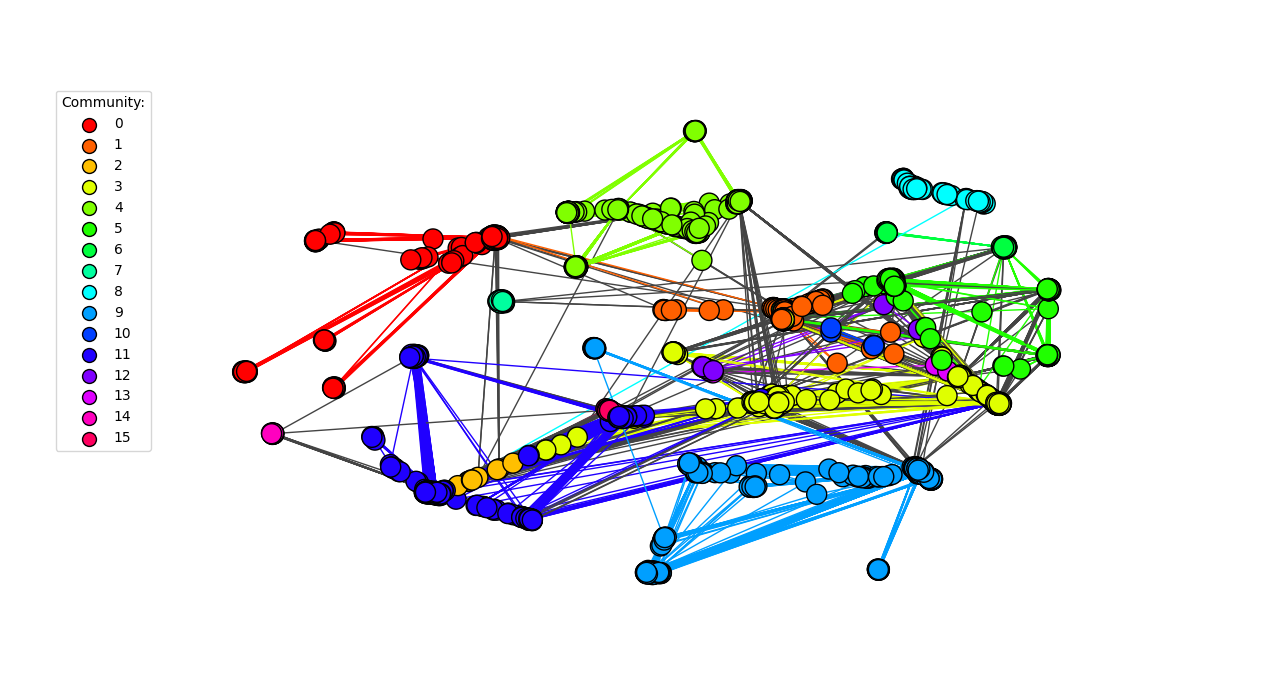

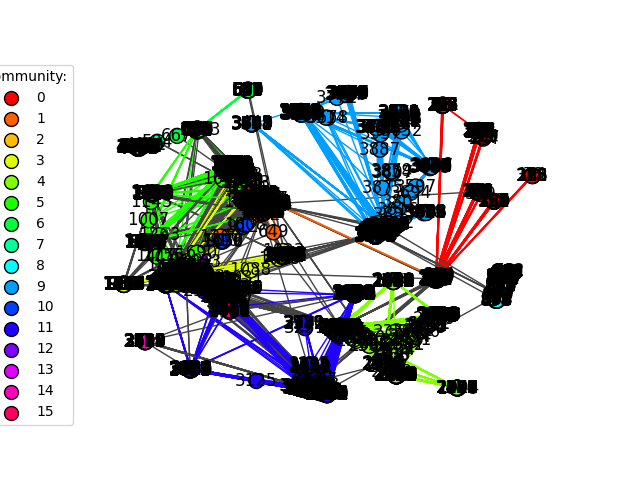

# [G] Refinement and Iteration
---

- After the outliers are found using z score recalculate the feature values and pass those values to the algorithms
- After the influencers (central nodes) are found in the network, new features can be added to the graph like "distance to the closest influencer", "average distance to the all influencers in the graph" etc and then perform clustering on the entire dataset including these features
- Use Node2Vec which represents nodes in the graph as vectors. These are calculated based on the random walks in the graph.